# RAPPORT PHONOCARDIO

# Introduction

Ce rapport présente une analyse de signaux audio WAV pour l'identification et l'analyse des pics cardiaques. L'objectif est de développer un ensemble d'outils Python pour extraire des informations précieuses sur le cycle cardiaque à partir de données audio. Le rapport décrit les différentes étapes de traitement du signal, de la représentation temporelle à l'analyse fréquentielle, en passant par le filtrage et la détection des pics cardiaques. De plus, une analyse comparative des énergies cardiaques entre différents enregistrements est effectuée.


## Sommaire

I. **Affichage**
   - Charge un fichier audio WAV et affiche son signal en temps.
   
II. **Représentation en fréquence**
   - Calcule le spectre en fréquence à l'aide de la transformée de Fourier et affiche le spectogramme.
   
III. **Filtrage et Débruitage**
   - Normalise le signal audio et applique un filtre passe-bande Butterworth.
   
IV. **Analyse de l'énergie par époque**
   - Améliore l'analyse de l'énergie par époque du signal filtré passe-bande.
   
V. **Filtrage**
   - Effectue plusieurs opérations telles que la correction de l'axe des temps et la détection des pics.
   
VI. **Calcul des Distances entre les Pics**
   - Calcule les distances en temps entre les pics détectés dans le signal lissé.
   
VII. **Identification des Pics B1 et B2**
   - Identifie les pics B1 et B2 à partir de la liste des pics détectés.
   
VIII. **Calcul des Points B1 et B2 avec Marges**
   - Calcule les points B1 et B2 avec des marges d'erreur pour une analyse plus robuste du signal.
   
IX. **Calcul des Valeurs Moyennes au Carré pour les Phases Cardiaques**
   - Calcule les valeurs moyennes au carré pour les phases cardiaques à partir des groupes de points B1 et B2 avec leurs marges d'erreur.
   
X. **Analyse et comparaison des énergies de tous les audios du fichier Records**
   - Réitère toutes les étapes précédentes pour tous les signaux du fichier Records, puis analyse et compare les résultats.

# Bibliothèques

In [1]:
# Pour le traçage de graphiques et de visualisations à partir de données.
import matplotlib.pyplot as plt

# Pour le calcul numérique et la manipulation de tableaux multidimensionnels.
import numpy as np

# Pour lire et écrire des fichiers audio au format WAV.
import scipy.io.wavfile as wav

# Pour effectuer des opérations sur des fichiers audio au format WAV.
import wave

# Pour calculer le spectrogramme d'un signal audio.
from scipy.signal import spectrogram

# Pour générer une fenêtre de type Kaiser, utilisée dans le traitement du signal.
from scipy.signal import kaiser

# Pour effectuer un rééchantillonnage d'un signal audio.
from scipy.signal import resample

# Pour concevoir et appliquer des filtres numériques.
from scipy.signal import butter, filtfilt

# Pour générer une fenêtre de type Hamming, utilisée dans le traitement du signal.
from scipy.signal import hamming

# Pour détecter les pics dans un signal.
from scipy.signal import find_peaks

# Pour interagir avec le système d'exploitation.
import os

# Pour effectuer des opérations mathématiques avancées.
import math

# I. Affichage

Ce code charge un fichier audio WAV, représente son signal en temps, et affiche l'amplitude en fonction du temps. Il prend en charge les signaux stéréo en les combinant en un signal complexe.

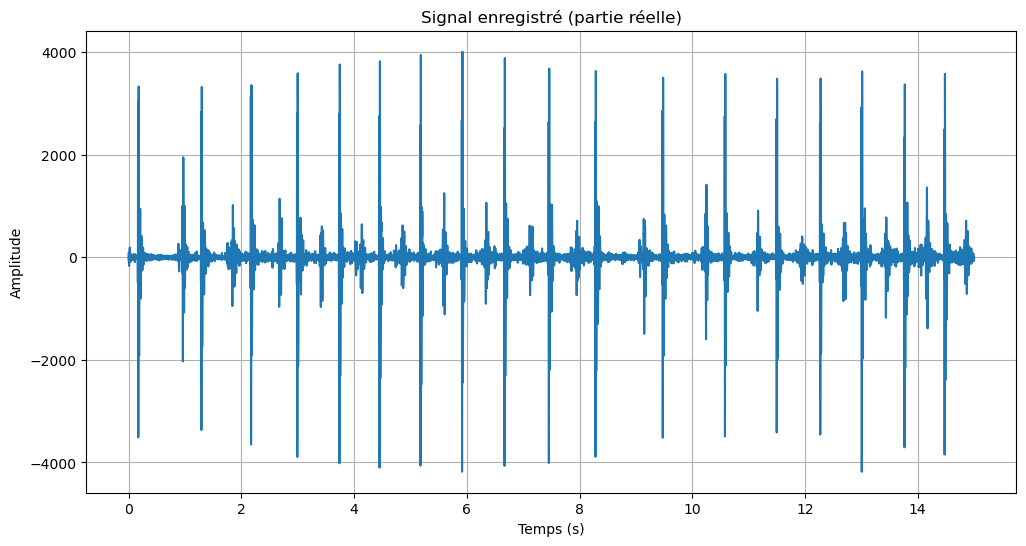

In [2]:
# Chemin du fichier audio WAV
filename = r'Records2\Eko Recording Sound Export ad apex 1.wav'

# Charger le fichier audio WAV
with wave.open(filename, 'rb') as wave_file:
    # Obtenir les informations sur le fichier audio
    framerate = wave_file.getframerate()
    frames = wave_file.getnframes()
    channels = wave_file.getnchannels()
    width = wave_file.getsampwidth()

    # Lire les données audio
    audio_data = wave_file.readframes(frames)

    # Convertir les données audio en tableau numpy
    audio_data = np.frombuffer(audio_data, dtype=np.int16)

    # Calculer la durée du signal en secondes
    duration = frames / float(framerate)

    # Créer une séquence temporelle pour le signal
    time = np.linspace(0, duration, frames)
    
    
# Charger le fichier audio WAV
Fs, y = wav.read(filename)

# Vérifier si le fichier audio est stéréo ou mono (ca peut arriver qu'il y ai 2 canaux
if len(y.shape) == 1:  # Mono
    X = y
elif len(y.shape) == 2:  # Stéréo
    X = y[:, 0] - 1j * y[:, 1]  # Combinaison en un signal complexe

Nmax = len(X)
TotalDuration = Nmax / Fs

# Affichage du signal
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, TotalDuration, Nmax), X)
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Signal enregistré (partie réelle)')
plt.grid(True)
plt.show()

# II. Représentation en fréquence

On extrait une époque du signal audio, calcule son spectre en fréquence à l'aide de la transformée de Fourier, et affiche la magnitude du spectre en fonction de la fréquence. On affiche aussi le spectogramme.

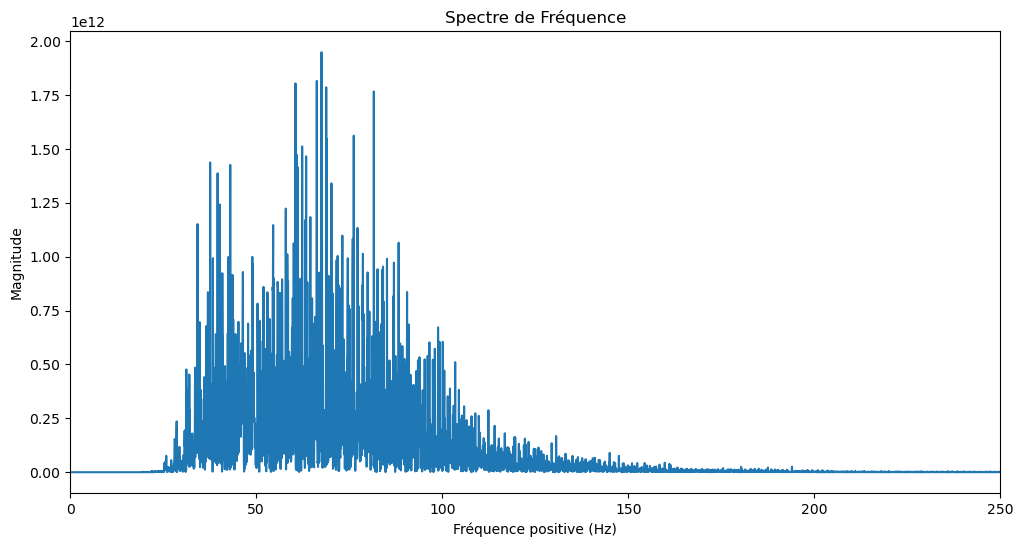

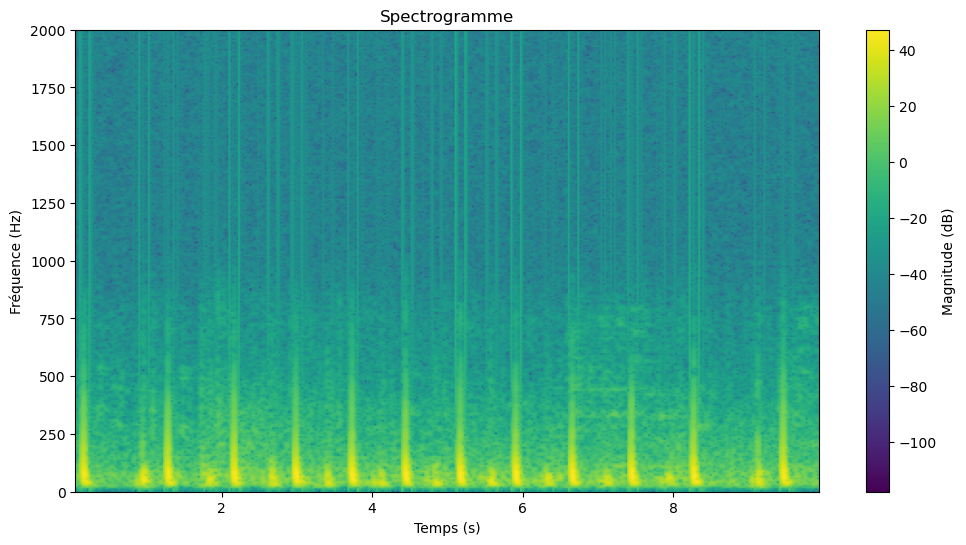

In [3]:
Overlap = 80 / 100
Lwind = 512
Delay = round(Lwind - (Lwind * Overlap))
ED = 10  # EpoqueDuration
NObs = int(ED * Fs)
k = 1
x = X[(k - 1) * NObs:k * NObs]
tx = np.linspace(0, ED, len(x))

# Représentation en fréquence
X = np.fft.fft(audio_data - np.mean(audio_data))
Xspec_fp = np.abs(X[:len(X) // 2]) ** 2
fp = np.linspace(0, framerate / 2, len(Xspec_fp))

plt.figure(figsize=(12, 6))
plt.plot(fp, Xspec_fp)
plt.xlabel('Fréquence positive (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectre de Fréquence')
plt.xlim([0, 250])  # Limiter la plage de fréquences pour une meilleure visualisation
plt.show()



# Affichage du spectrogramme
plt.figure(figsize=(12, 6))
plt.specgram(x, NFFT=512  , Fs=Fs, window=kaiser(512, 5),  noverlap=round(512 * Overlap))
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (s)')
plt.colorbar(label='Magnitude (dB)')
plt.title('Spectrogramme')
plt.show()

# III. Filtrage et Débruitage

Ici, on normalise d'abord le signal audio en divisant par sa valeur maximale absolue. Ensuite, il définit des fonctions pour créer un filtre passe-bande Butterworth et appliquer ce filtre au signal audio. Les fréquences de coupure du filtre sont spécifiées. Le signal audio est filtré à l'aide de ces fréquences deLe graphique final compare le signal original et le signal filtré passe-bande en fonction du temps.

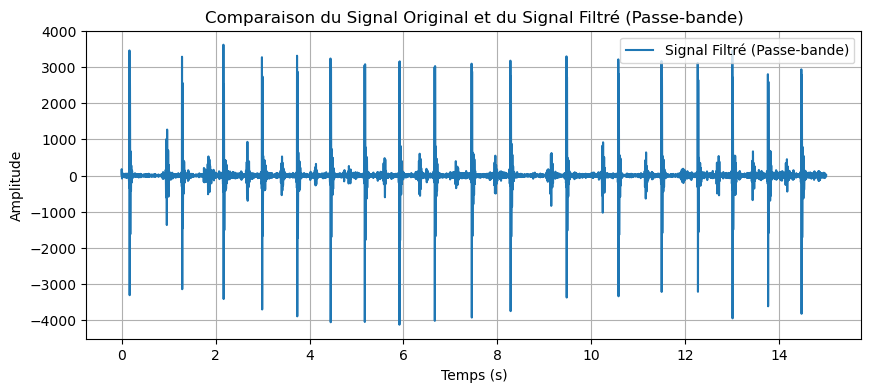

In [4]:
# Normalisation (diviser par la valeur maximale absolue)
normalized_audio_data = audio_data / np.max(np.abs(audio_data))

# Fonction pour créer un filtre passe-bande Butterworth
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

# Fonction pour appliquer le filtre passe-bande Butterworth au signal audio
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Définition des fréquences de coupure du filtre passe-bande
lowcut_frequency = 50  # Fréquence de coupure basse en Hz
highcut_frequency = 1000  # Fréquence de coupure haute en Hz

# Application du filtre passe-bande au signal audio
filtered_audio_data_bandpass = butter_bandpass_filter(audio_data, lowcut_frequency, highcut_frequency, framerate)
# Débruitage (par exemple, seuillage simple)
#threshold = 100  # Seuil pour la détection du bruit
#denoised_audio_data = np.where(np.abs(audio_data) > threshold, audio_data, 0)
# Affichage des signaux original et filtré passe-bande
plt.figure(figsize=(10, 4))
plt.plot(time, filtered_audio_data_bandpass, label='Signal Filtré (Passe-bande)')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Comparaison du Signal Original et du Signal Filtré (Passe-bande)')
plt.legend()
plt.grid(True)
plt.show()

# IV. Analyse de l'énergie par époque

Les modifications de cette partie visent à améliorer l'analyse de l'énergie par époque du signal filtré passe-bande. La réduction de la longueur de la fenêtre de Hamming, l'augmentation de la longueur de la transformée de Fourier, et la diminution du taux de recouvrement contribuent à une meilleure résolution temporelle et fréquentielle de l'analyse.


Le code calcule ensuite l'énergie par époque du signal filtré à l'aide de ces nouvelles configurations. La transformation de Fourier est appliquée à chaque époque avec une fenêtre de Hamming, et l'énergie est calculée. Le graphique final montre l'évolution de l'énergie par époque en fonction du temps normalisé.

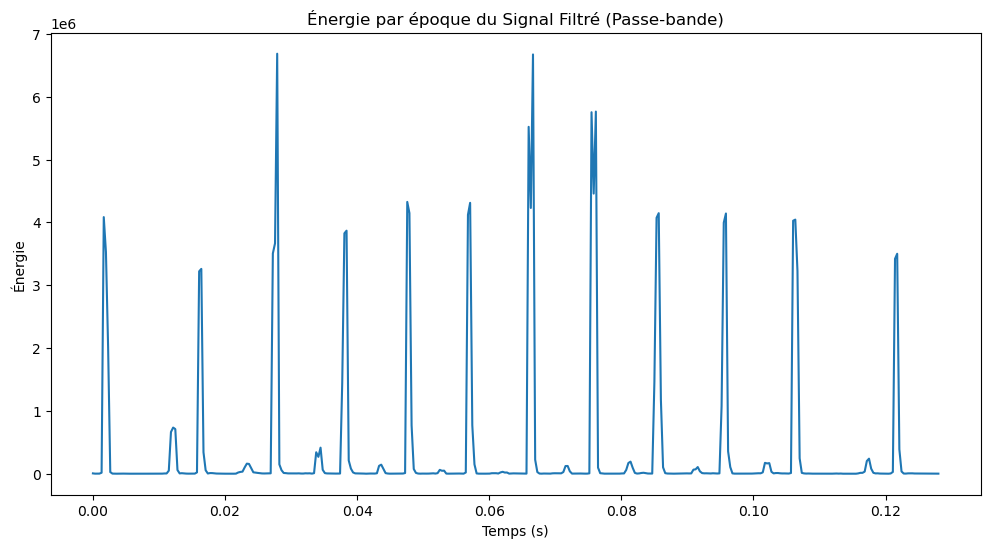

In [5]:
EpoqueDuration = Lwind / Fs


# Réduire la longueur de la fenêtre de Hamming
Lwind = 128  # Par exemple, réduire la longueur de la fenêtre de Hamming à 128

# Augmenter la longueur de la transformée de Fourier
NFFT = 2048  # Par exemple, augmenter la longueur de la transformée de Fourier à 2048

# Diminuer le taux de recouvrement
Overlap = 50 / 100  # Par exemple, réduire le taux de recouvrement à 50%

# Affichage de l'énergie par époque avec les nouvelles modifications
Energy = []

l = 1

while (l - 1) * Delay + Lwind < NObs:
    x_wind = filtered_audio_data_bandpass[(l - 1) * Delay:l * Delay + Lwind]
    S = np.abs(np.fft.fft(x_wind, NFFT))
    FrpPos = np.arange(len(S) // 2)
    Energy.append([np.sum((S[FrpPos] * hamming(len(FrpPos))) ** 2) / len(FrpPos)])
    l += 1

Energy = np.array(Energy)
Sgl = Energy[:, 0]
tx = np.linspace(0, EpoqueDuration, len(Sgl))

# Affichage de l'énergie par époque avec les nouvelles modifications
plt.figure(figsize=(12, 6))
plt.plot(tx, Sgl)
plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Énergie par époque du Signal Filtré (Passe-bande)')
plt.show()


# V. Filtrage

On effectue ici plusieurs opérations :

- **Correction de l'axe des temps** : L'axe des temps est recalculé en fonction du délai entre les époques et la fréquence d'échantillonnage pour correspondre à l'échelle temporelle correcte.

- **Création d'un filtre passe-bas** : Un filtre passe-bas Butterworth est créé pour lisser le signal d'énergie par époque. Les paramètres tels que l'ordre du filtre et la fréquence de coupure sont spécifiés.

- **Application du filtre passe-bas** : Le filtre passe-bas est appliqué à l'énergie par époque pour lisser le signal.

### Identification des pics automatique :

- **Identification des Pics Initiaux** : 
  - Tous les pics du signal lissé sont identifiés sans seuil initial, offrant une vue d'ensemble des amplitudes des pics.

- **Suppression du Pic le Plus Grand** : 
  - Le pic le plus grand est supprimé pour éviter l'influence excessive des valeurs extrêmes. Le deuxième plus grand pic est utilisé pour déterminer un seuil de hauteur (`height`) plus représentatif.

- **Définition du Seuil de Hauteur (`height`)** : 
  - Le seuil est fixé comme une fraction du deuxième plus grand pic, garantissant la détection des pics significatifs sans être influencé par un seul pic anormalement élevé.

- **Paramètres Adaptatifs** :
  - **Distance Minimale Entre les Pics** : Calculée en fonction de la longueur totale du signal pour éviter la détection multiple de pics proches.
  - **Prominence** : Basée sur l'écart interquartile (IQR), offrant une mesure robuste de la proéminence.
  - **Largeur Minimale des Pics** : Fixée à une valeur minimale pour éviter la détection de pics trop étroits, susceptibles de représenter du bruit.

- **Analyse Comparative des Signaux de Record2** :
  - Les paramètres de détection ont été optimisés après une analyse comparative des signaux du fichier Record2. Cette approche adaptative garantit que les seuils et paramètres de la fonction `find_peaks` sont ajustés en fonction des caractéristiques spécifiques de chaque segment, assurant une détection fiable et robuste des pics à travers divers segments de signaux.


- **Affichage des signaux** : Les signaux original et filtré passe-bande sont affichés, ainsi que le signal d'énergie par époque lissé avec les pics détectés.


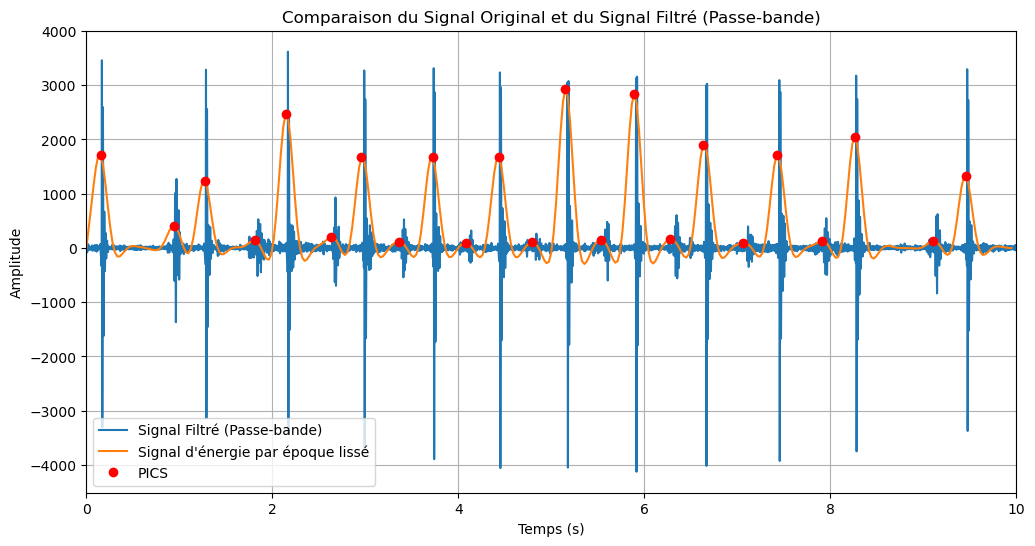

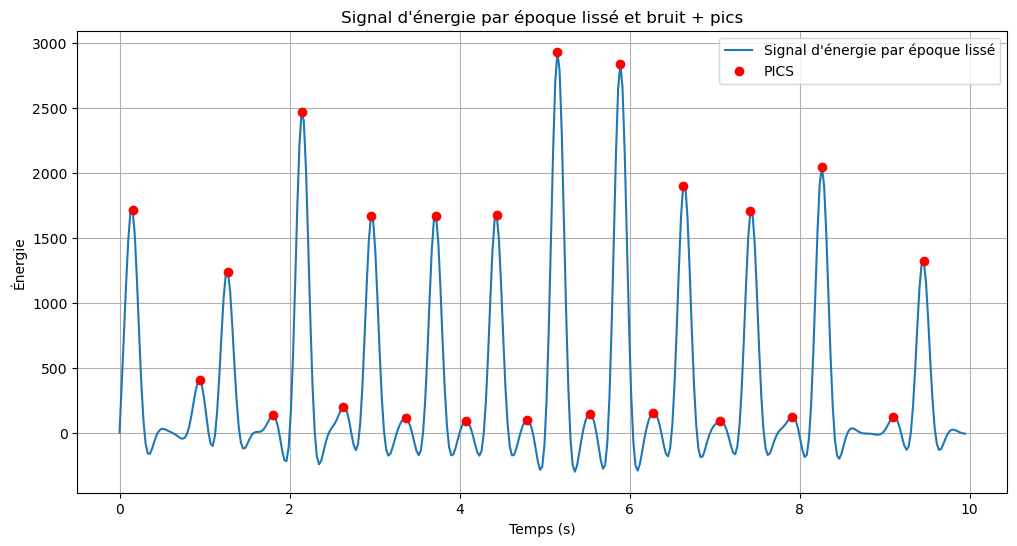

In [6]:
# Correction de l'axe des temps
epoch_times = np.arange(len(Sgl)) * (Delay / Fs)

# Définition des paramètres du filtre passe-bas
order = 3  # Ordre du filtre
cutoff_freq = 0.09  # Fréquence de coupure du filtre (en Hz)

# Création du filtre passe-bas
b, a = butter(order, cutoff_freq, fs=1)

# Application du filtre passe-bas à l'énergie par époque pour lisser le signal
smoothed_energy = filtfilt(b, a, Sgl)

# Trouver tous les pics initiaux pour analyser les amplitudes
initial_peaks, _ = find_peaks(smoothed_energy)

# Si au moins deux pics sont trouvés
if len(initial_peaks) > 1:
    # Obtenir les valeurs des pics trouvés
    peak_values = smoothed_energy[initial_peaks]
    # Trouver l'indice du plus grand pic
    max_peak_index = np.argmax(peak_values)
    # Supprimer le plus grand pic pour obtenir le deuxième plus grand
    peak_values = np.delete(peak_values, max_peak_index)
    # Trouver la valeur du deuxième plus grand pic
    second_max_peak = np.max(peak_values)
else:
    # Si moins de deux pics, utiliser le maximum existant pour éviter les erreurs
    second_max_peak = np.max(smoothed_energy)

# Définir height comme une fraction du deuxième plus grand pic
height_threshold = second_max_peak / 50

# Définir d'autres paramètres de manière adaptative
distance = len(smoothed_energy) // 50  # Vous pouvez ajuster ce facteur selon le signal
prominence = (np.percentile(smoothed_energy, 50) - np.percentile(smoothed_energy, 25))  # Utilisation de l'IQR comme estimation de la prominence
width = 5  # Valeur de largeur minimale (peut être ajustée)

# Trouver les pics avec les paramètres calculés
peaks, properties = find_peaks(smoothed_energy, distance=distance, height=height_threshold, prominence=prominence, width=width)

# Affichage du signal lissé, du bruit et des pics
plt.figure(figsize=(12, 6))
plt.plot(time, filtered_audio_data_bandpass, label='Signal Filtré (Passe-bande)')
plt.xlim([0,10])
plt.plot(epoch_times, smoothed_energy/1000, label='Signal d\'énergie par époque lissé')
plt.plot(epoch_times[peaks], smoothed_energy[peaks]/1000,'ro',  label='PICS')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Comparaison du Signal Original et du Signal Filtré (Passe-bande)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epoch_times, smoothed_energy/1000, label='Signal d\'énergie par époque lissé')
plt.plot(epoch_times[peaks], smoothed_energy[peaks]/1000,'ro',  label='PICS')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Signal d\'énergie par époque lissé et bruit + pics')
plt.legend()
plt.grid(True)

plt.show()

# VI. Calcul des Distances entre les Pics

Le code ci-dessous permet de calculer les distances en temps entre les pics détectés dans le signal lissé. Ensuite, il identifie la distance minimale et trouve les indices des pics correspondant à cette distance minimale pour déterminer les pics B1 et B2.

- **Calcul des distances en temps entre les pics** : Une boucle parcourt les indices des pics détectés et calcule la différence de temps entre chaque paire de pics.

- **Trouver la distance la plus petite** : La distance minimale entre les pics est déterminée en utilisant la fonction `min()`.

- **Recherche des indices des pics correspondant à la distance minimale** : Les indices des pics B1 et B2 sont trouvés en recherchant la distance minimale dans la liste des distances et en utilisant ces indices pour accéder aux indices correspondants dans la liste des pics.

- **Affichage du signal lissé avec les pics B1 et B2 marqués** : Le signal d'énergie par époque lissé est tracé, et les pics B1 et B2 sont marqués sur le graphique.

Entre 1 & 2 : 0.79 secondes
Entre 2 & 3 : 0.33 secondes
Entre 3 & 4 : 0.54 secondes
Entre 4 & 5 : 0.33 secondes
Entre 5 & 6 : 0.48 secondes
Entre 6 & 7 : 0.33 secondes
Entre 7 & 8 : 0.41 secondes
Entre 8 & 9 : 0.36 secondes
Entre 9 & 10 : 0.36 secondes
Entre 10 & 11 : 0.36 secondes
Entre 11 & 12 : 0.36 secondes
Entre 12 & 13 : 0.36 secondes
Entre 13 & 14 : 0.38 secondes
Entre 14 & 15 : 0.36 secondes
Entre 15 & 16 : 0.38 secondes
Entre 16 & 17 : 0.36 secondes
Entre 17 & 18 : 0.43 secondes
Entre 18 & 19 : 0.36 secondes
Entre 19 & 20 : 0.48 secondes
Entre 20 & 21 : 0.36 secondes
Entre 21 & 22 : 0.84 secondes
Entre 22 & 23 : 0.36 secondes


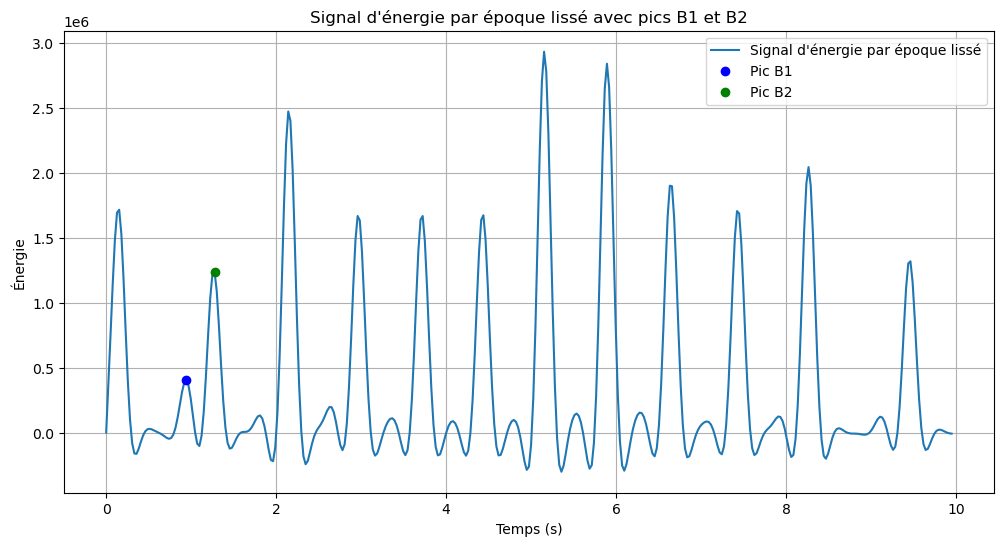

indice pic B2 : 50
indice pic B1 : 37


In [7]:
distances = []


# Calcul des distances en temps entre les pics
for i in range(len(peaks) - 1):
    distance_time = epoch_times[peaks[i+1]] - epoch_times[peaks[i]]
    print(f"Entre {i+1} & {i+2} : {distance_time:.2f} secondes")
    distances.append(distance_time)

# Trouver la distance la plus petite
distance_min = min(distances)

# Recherche des indices des pics correspondant à la distance minimale
min_distance_index = distances.index(distance_min)
pic_B1_index = peaks[min_distance_index]
pic_B2_index = peaks[min_distance_index + 1]

# Affichage du signal lissé avec les pics B1 et B2 marqués
plt.figure(figsize=(12, 6))
plt.plot(epoch_times, smoothed_energy, label='Signal d\'énergie par époque lissé')

# Marquage des pics B1 et B2
plt.plot(epoch_times[pic_B1_index], smoothed_energy[pic_B1_index], 'bo', label='Pic B1')
plt.plot(epoch_times[pic_B2_index], smoothed_energy[pic_B2_index], 'go', label='Pic B2')

plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Signal d\'énergie par époque lissé avec pics B1 et B2')
plt.legend()
plt.grid(True)
plt.show()

print("indice pic B2 :", pic_B2_index)
print("indice pic B1 :",pic_B1_index)


# VII. Identification des Pics B1 et B2

On identifie ensuite les pics B1 et B2 à partir de la liste des pics détectés. Il divise la liste des pics en deux listes distinctes, l'une pour les pics B1 et l'autre pour les pics B2.

- **Itération sur les indices des pics B1 et B2** : Une boucle parcourt les indices des pics détectés. Si l'indice est pair, il est ajouté à la liste des pics B2 ; sinon, il est ajouté à la liste des pics B1.

- **Vérification de la correspondance du premier pic** : Le premier pic de la liste globale est comparé avec les premiers pics des listes B1 et B2 pour s'assurer que la détection des pics est correcte.

- **Tri des listes des pics B1 et B2** : Les listes des pics B1 et B2 sont triées par ordre croissant pour faciliter l'analyse.

- **Affichage des listes des pics B1 et B2** : Les listes des pics B1 et B2 sont affichées pour vérification.

- **Affichage du signal lissé avec les pics B1 et B2 marqués** : Le signal d'énergie par époque lissé est tracé, avec les pics B1 et B2 marqués sur le graphique.

Liste des pics B1 : [37, 71, 103, 132, 160, 188, 217, 246, 277, 310, 357]
Liste des pics B2 : [6, 50, 84, 116, 146, 174, 202, 231, 260, 291, 324, 371]


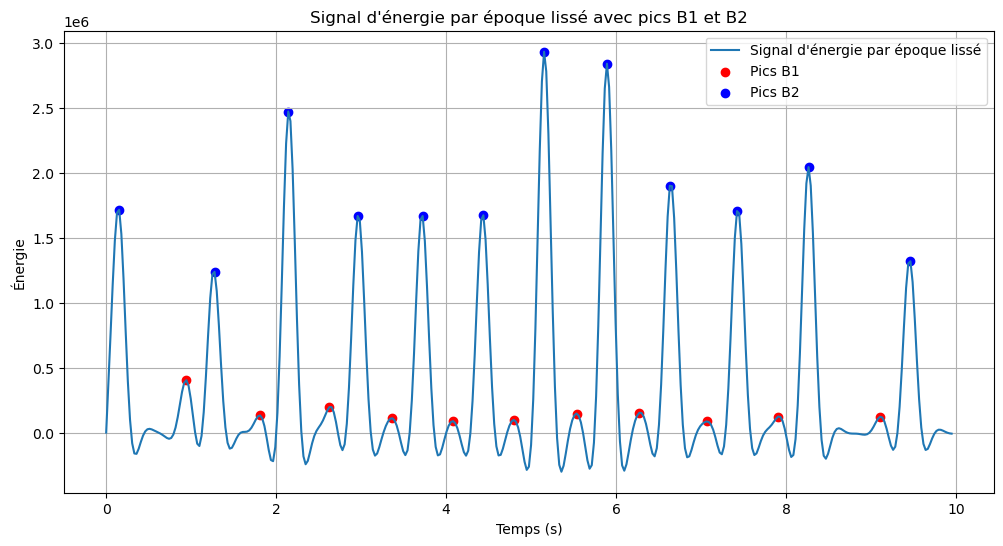

In [8]:
# Définir des listes pour stocker les pics B1 et B2
peaks_B1 = []
peaks_B2 = []

# Itérer sur les indices des pics B1 et B2
for i in range(1, len(peaks)):
    if i % 2 == 0:
        # Si l'indice est pair, ajouter à la liste des pics B2
        peaks_B2.append(peaks[i])
    else:
        # Sinon, ajouter à la liste des pics B1
        peaks_B1.append(peaks[i])

# Vérifier si le deuxième pic de la liste globale est égal au premier pic de B1 ou B2

if peaks[1] == peaks_B1[0]:

    peaks_B2.append(peaks[0])

elif peaks[1] == peaks_B2[0]:

    peaks_B1.append(peaks[0])
# Trier les listes des pics B1 et B2 par ordre croissant
peaks_B1.sort()
peaks_B2.sort()

# Afficher les listes des pics B1 et B2
print("Liste des pics B1 :", peaks_B1)
print("Liste des pics B2 :", peaks_B2)

# Affichage du signal lissé avec les pics B1 et B2 marqués
plt.figure(figsize=(12, 6))

# Plot du signal d'énergie par époque lissé
plt.plot(epoch_times, smoothed_energy, label='Signal d\'énergie par époque lissé')

# Plot des pics B1
plt.scatter(epoch_times[peaks_B1], smoothed_energy[peaks_B1], color='red', label='Pics B1')

# Plot des pics B2
plt.scatter(epoch_times[peaks_B2], smoothed_energy[peaks_B2], color='blue', label='Pics B2')

plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Signal d\'énergie par époque lissé avec pics B1 et B2')
plt.legend()
plt.grid(True)
plt.show()


# VIII. Calcul des Points B1 et B2 avec marges

Ce code calcule les points B1 et B2 avec des marges d'erreur pour une analyse plus robuste du signal. Voici les étapes :

1. **Calcul des distances entre chaque paire de pics B1 consécutifs** : Les distances en temps entre chaque paire de pics B1 consécutifs sont calculées pour avoir le cycle cardiaque.

2. **Calcul de la moyenne des distances** : La moyenne des distances entre les pics B1 est calculée pour estimer la durée moyenne d'un cycle pour une portion du signal.

3. **Calcul de 10% de cette moyenne pour obtenir le seuil** : Un seuil est définie comme 10% de la moyenne du cycle.

4. **Enregistrement des points B1 et B2 avec marges d'erreur** : Les points B1 et B2 sont enregistrés avec des seuil pour tenir compte de la durée réel des pics.

5. **Triage et suppression des doublons** : Les points B1 et B2 sont triés et les doublons sont supprimés pour une analyse propre.

6. **Regroupement des indices consécutifs** : Les indices des points B1 et B2 sont regroupés s'ils sont consécutifs, ce qui fournit une mesure du nombre de positions qu'ils comprennent.

In [9]:
distances_B1 = []

# Calcul des distances entre chaque paire de pics B1 consécutifs
for i in range(len(peaks_B1) - 1):
    distance_B1 = epoch_times[peaks_B1[i+1]] - epoch_times[peaks_B1[i]]
    distances_B1.append(distance_B1)

# Calcul de la moyenne des distances
moyenne_distance_B1 = sum(distances_B1) / len(distances_B1)

# Calcul de 10% de cette moyenne pour obtenir le seuil
marge_erreur = int(moyenne_distance_B1 * 0.10)+1# Définir la marge d'erreur


# Enregistrement des points B1 avec marges d'erreur
points_B1 = []
for pic_B1 in peaks_B1:
    points_B1.extend(range(pic_B1 - marge_erreur, pic_B1 + marge_erreur + 1))

# Enregistrement des points B2 avec seuil
points_B2 = []
for pic_B2 in peaks_B2:
    points_B2.extend(range(pic_B2 - marge_erreur, pic_B2 + marge_erreur + 1))

# Trier et supprimer les doublons
points_B1 = sorted(set(points_B1))
points_B2 = sorted(set(points_B2))

# Fonction pour regrouper les indices consécutifs
def regrouper_indices(indices):
    groups = []
    temp_group = [indices[0]]
    for i in range(1, len(indices)):
        if indices[i] - indices[i-1] == 1:
            temp_group.append(indices[i])
        else:
            groups.append(temp_group)
            temp_group = [indices[i]]
    groups.append(temp_group)
    return groups

# Enregistrement des points B1 avec marges d'erreur et le nombre de positions qu'ils comprennent
points_B1_groupes = regrouper_indices(points_B1)
# Enregistrement des points B2 avec marges d'erreur et le nombre de positions qu'ils comprennent
points_B2_groupes = regrouper_indices(points_B2)

# Affichage des points B1 et B2 avec marges d'erreur et le nombre de positions qu'ils comprennent
print("Points avec B1 et marges d'erreur (et nombre de positions) :", points_B1_groupes)
print("Points avec B2 et marges d'erreur (et nombre de positions) :", points_B2_groupes)



Points avec B1 et marges d'erreur (et nombre de positions) : [[36, 37, 38], [70, 71, 72], [102, 103, 104], [131, 132, 133], [159, 160, 161], [187, 188, 189], [216, 217, 218], [245, 246, 247], [276, 277, 278], [309, 310, 311], [356, 357, 358]]
Points avec B2 et marges d'erreur (et nombre de positions) : [[5, 6, 7], [49, 50, 51], [83, 84, 85], [115, 116, 117], [145, 146, 147], [173, 174, 175], [201, 202, 203], [230, 231, 232], [259, 260, 261], [290, 291, 292], [323, 324, 325], [370, 371, 372]]


On trace le signal d'énergie par époque lissé avec les pics B1 et B2, ainsi que leurs marges d'erreur.

- **Plot des marges des pics B1 et B2** : Les marges d'erreur des pics B1 et B2 sont représentées par des zones ombrées autour de chaque pic. Les marges sont calculées pour tenir compte de la variabilité dans la détection des pics.

- **Plot des pics B1 et B2** : Les pics B1 et B2 sont marqués sur le graphique avec des points rouges et bleus respectivement.

Ce graphique permet une visualisation claire des pics B1 et B2 du signal d'énergie par époque, ainsi que de leurs marges d'erreur, ce qui facilite l'analyse des phases du cycle cardiaque.


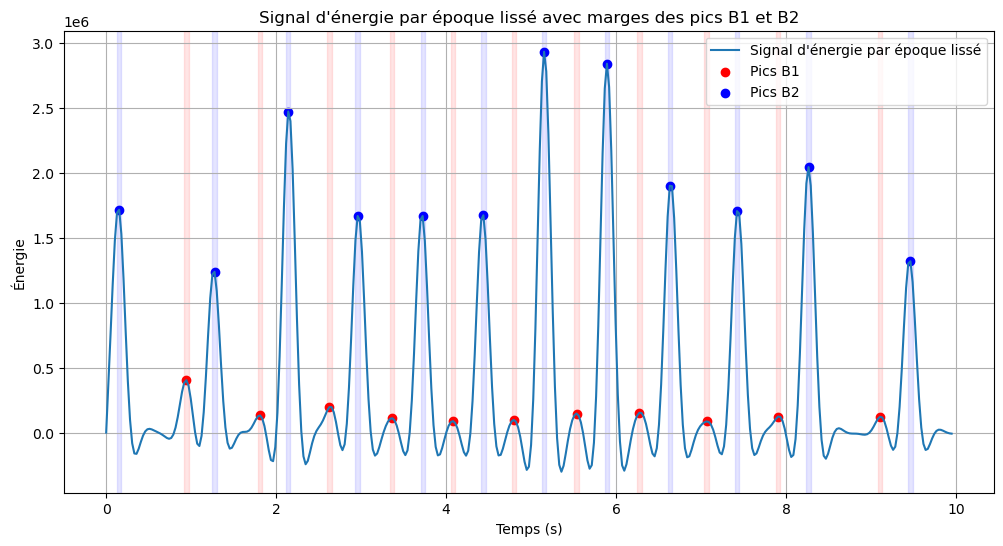

In [10]:
# Affichage du signal lissé avec les pics B1 et B2 marqués avec leurs marges
plt.figure(figsize=(12, 6))

# Plot du signal d'énergie par époque lissé
plt.plot(epoch_times, smoothed_energy, label='Signal d\'énergie par époque lissé')

# Plot des marges des pics B1
for groupe in points_B1_groupes:
    premier_point = groupe[0]
    dernier_point = groupe[-1]
    plt.axvspan(epoch_times[premier_point], epoch_times[dernier_point], color='red', alpha=0.1)

# Plot des marges des pics B2
for groupe in points_B2_groupes:
    premier_point = groupe[0]
    dernier_point = groupe[-1]
    plt.axvspan(epoch_times[premier_point], epoch_times[dernier_point], color='blue', alpha=0.1)
# Plot des pics B1
plt.scatter(epoch_times[peaks_B1], smoothed_energy[peaks_B1], color='red', label='Pics B1')

# Plot des pics B2
plt.scatter(epoch_times[peaks_B2], smoothed_energy[peaks_B2], color='blue', label='Pics B2')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Signal d\'énergie par époque lissé avec marges des pics B1 et B2')
plt.legend()
plt.grid(True)

plt.show()

# IX. Calcul des Valeurs Moyennes au Carré pour les Phases Cardiaques

On calcule les valeurs moyennes au carré pour les phases cardiaques (B2, Diastole, B1, Systole) à partir des groupes de points B1 et B2 avec leurs marges d'erreur.

- **Itération sur les groupes B1 et B2** : Une boucle parcourt les groupes de points B1 et B2.

- **Extraction des indices de début et de fin pour chaque groupe B1 et B2** : Les indices de début et de fin sont extraits pour chaque groupe B1 et B2.

- **Calcul de la moyenne de chaque point élevé au carré pour chaque segment** : La moyenne des valeurs au carré est calculée pour chaque phase cardiaque en fonction des segments délimités par les groupes B1 et B2.

- **Ajout des valeurs moyennes aux listes correspondantes** : Les valeurs moyennes au carré sont ajoutées aux listes correspondantes (B2, Diastole, B1, Systole).

- **Affichage des valeurs moyennes** : Les valeurs moyennes au carré pour chaque phase cardiaque sont affichées pour vérification.

In [11]:
# Initialisation des listes pour stocker les valeurs moyennes
B2 = []
diastole = []
B1 = []
systole = []

# Itérer sur les groupes B1 et B2
for i in range(len(points_B1_groupes)):
    # Extraire les indices de début et de fin pour chaque groupe B1 et B2
    start_B1 = points_B1_groupes[i][0]
    end_B1 = points_B1_groupes[i][-1]
    start_B2 = points_B2_groupes[i][0]
    end_B2 = points_B2_groupes[i][-1]
    
    # Calculer la moyenne de chaque point élevé au carré pour chaque segment
    mean_squared_B2 = np.mean(filtered_audio_data_bandpass[start_B2:end_B2+1] ** 2)
    mean_squared_diastole = np.mean(filtered_audio_data_bandpass[end_B2+1:start_B1] ** 2)
    mean_squared_B1 = np.mean(filtered_audio_data_bandpass[start_B1:end_B1+1] ** 2)
    
    # Vérifier si ce n'est pas la dernière itération
    if i != len(points_B1_groupes) - 1:
        mean_squared_systole = np.mean(filtered_audio_data_bandpass[end_B1+1:points_B1_groupes[i+1][0]] ** 2)
    else:
        # Si c'est la dernière itération, définir la valeur de mean_squared_systole à 0
        mean_squared_systole = 0
    
         
        
    # Ajouter les valeurs moyennes aux listes correspondantes
    B2.append(mean_squared_B2)
    diastole.append(mean_squared_diastole)
    B1.append(mean_squared_B1)
    systole.append(mean_squared_systole)
    

        
    # Afficher les valeurs moyennes
    print("Groupe B2 - Valeur moyenne au carré :", mean_squared_B2)
    print("Diastole - Valeur moyenne au carré :", mean_squared_diastole)
    print("Groupe B1 - Valeur moyenne au carré :", mean_squared_B1)
    print("Systole - Valeur moyenne au carré :", mean_squared_systole)

# Supprimer les premiers éléments de chaque liste
del B2[0]
del diastole[0]
del B1[0]
del systole[0]

Groupe B2 - Valeur moyenne au carré : 28583.94006385155
Diastole - Valeur moyenne au carré : 4818.862943376141
Groupe B1 - Valeur moyenne au carré : 2635.8673897940694
Systole - Valeur moyenne au carré : 753.4500434620873
Groupe B2 - Valeur moyenne au carré : 159.82985039383757
Diastole - Valeur moyenne au carré : 670.347136281383
Groupe B1 - Valeur moyenne au carré : 2477.675525965465
Systole - Valeur moyenne au carré : 1747.9249472547492
Groupe B2 - Valeur moyenne au carré : 200.88086521777777
Diastole - Valeur moyenne au carré : 1104.7795256804625
Groupe B1 - Valeur moyenne au carré : 778.0333997330804
Systole - Valeur moyenne au carré : 233.0867844290716
Groupe B2 - Valeur moyenne au carré : 39.22835901275456
Diastole - Valeur moyenne au carré : 50.23345954461269
Groupe B1 - Valeur moyenne au carré : 578.8981785379677
Systole - Valeur moyenne au carré : 473.0661891765051
Groupe B2 - Valeur moyenne au carré : 100.34373947297574
Diastole - Valeur moyenne au carré : 403.59727101662816

Ce code crée un graphique à barres pour visualiser les valeurs moyennes au carré pour chaque phase cardiaque (B2, Diastole, B1, Systole).

- **Création des listes** : Une liste contenant les noms des segments, une liste contenant les valeurs moyennes pour chaque segment, et une liste contenant les couleurs correspondant à chaque segment sont créées.

- **Création de la figure et des sous-graphiques** : Une figure et des sous-graphiques sont créés pour afficher les barres pour chaque segment.

- **Itération sur chaque segment pour créer les graphiques** : Une boucle parcourt chaque segment et crée un graphique à barres pour représenter les valeurs moyennes au carré.

- **Affichage des noms des segments sur l'axe des x** : Les noms des segments sont affichés sur l'axe des x du dernier graphique pour une meilleure lisibilité.

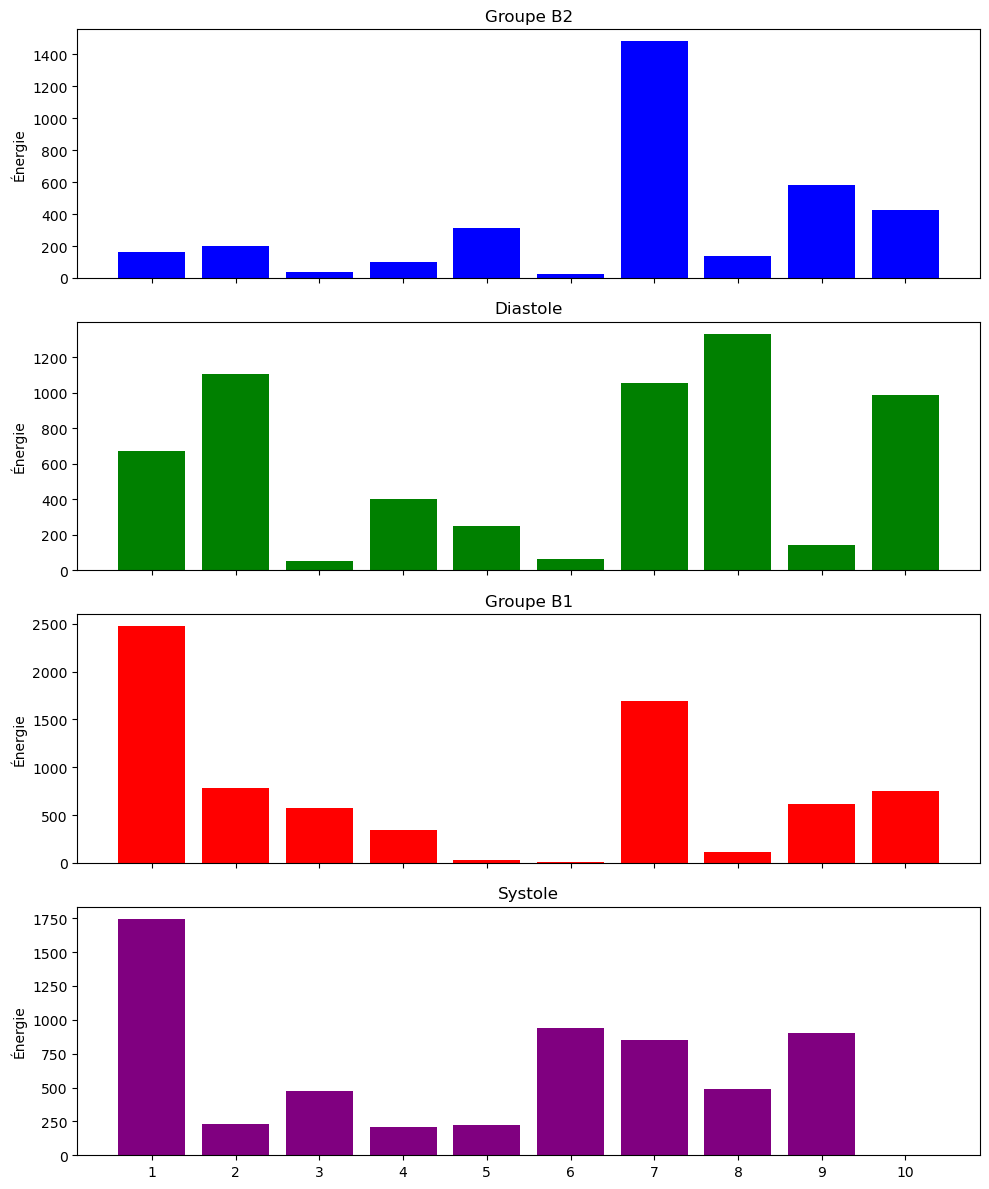

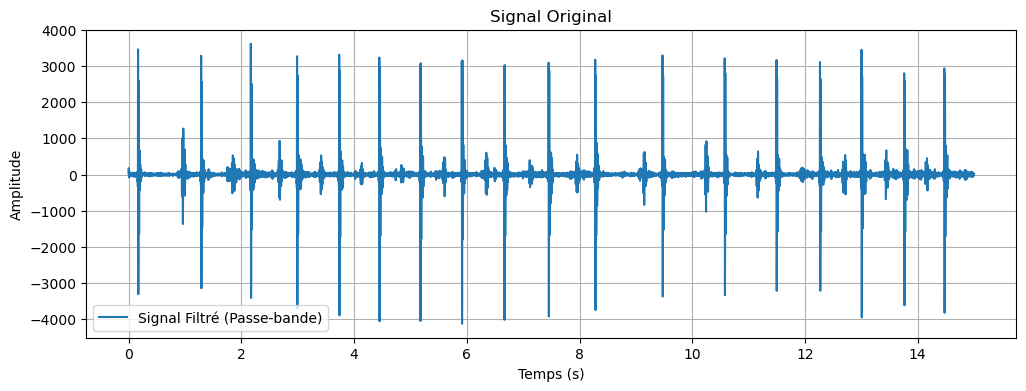

In [12]:
# Créer une liste contenant les noms des segments
segments = ['Groupe B2', 'Diastole', 'Groupe B1', 'Systole']

# Créer une liste contenant les valeurs moyennes pour chaque segment
mean_squared_values = [B2, diastole, B1, systole]

# Créer une liste contenant les couleurs à utiliser pour chaque segment
colors = ['blue', 'green', 'red', 'purple']

# Créer une figure et des sous-graphiques
fig, axs = plt.subplots(4, figsize=(10, 12), sharex=True)

# Itérer sur chaque segment pour créer les graphiques
for i in range(4):
    axs[i].bar(range(len(mean_squared_values[i])), mean_squared_values[i], color=colors[i])
    axs[i].set_ylabel('Énergie')
    axs[i].set_title(segments[i])

# Afficher les noms des segments sur l'axe des x du dernier graphique
axs[3].set_xticks(range(len(mean_squared_values[0])))
axs[3].set_xticklabels(range(1, len(mean_squared_values[0])+1))

# Afficher les graphiques
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(time, filtered_audio_data_bandpass, label='Signal Filtré (Passe-bande)')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Signal Original')
plt.legend()
plt.grid(True)
plt.show()

# X. Analyse et comparaison des énergies de tous les audios du fichiers Records

### Cette portion de code réitère toutes les étapes précédentes pour tous les signaux du fichier Records
##### Traitement des fichiers audio

- Charge les fichiers audio WAV.
- Applique un filtre passe-bande Butterworth au signal audio.
- Calcule l'énergie par époque du signal filtré.

##### Détection des pics cardiaques

- Lisse le signal d'énergie par époque.
- Trouve les pics cardiaques en utilisant la fonction `find_peaks`.
- Identifie les pics B1 et B2 les plus proches en analysant les distances temporelles entre les pics.

##### Calcul des segments cardiaques

- Détermine les groupes de pics B1 et B2 avec marges d'erreur.
- Calcule les valeurs moyennes au carré pour chaque segment cardiaque (B2, Diastole, B1, Systole).
- Stocke les moyennes pour chaque segment pour chaque patient.

##### Analyse des résultats

- Calcul des moyennes de chaque segment pour tous les patients.
- Affiche les moyennes de chaque segment pour tous les patients sous forme de graphique à barres.


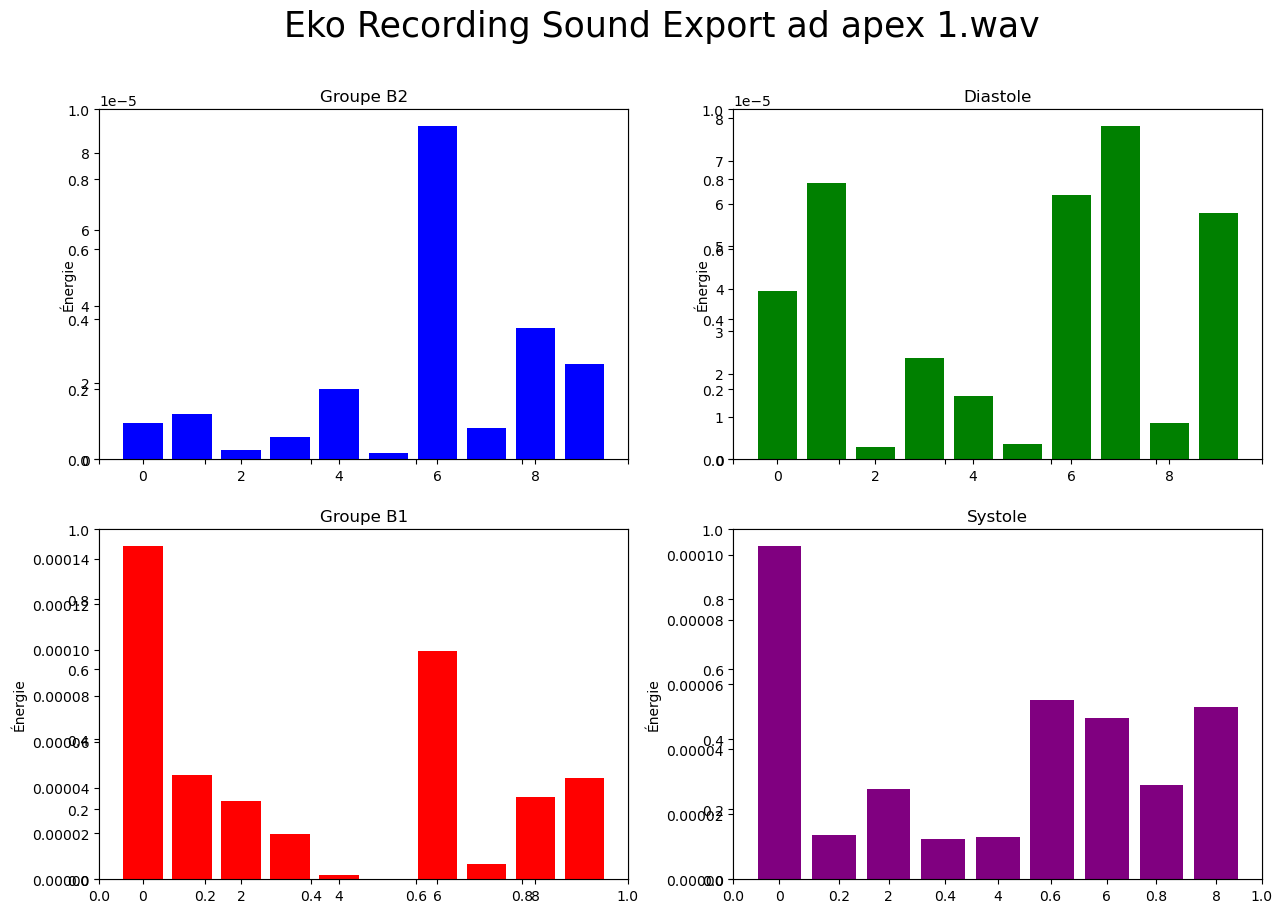

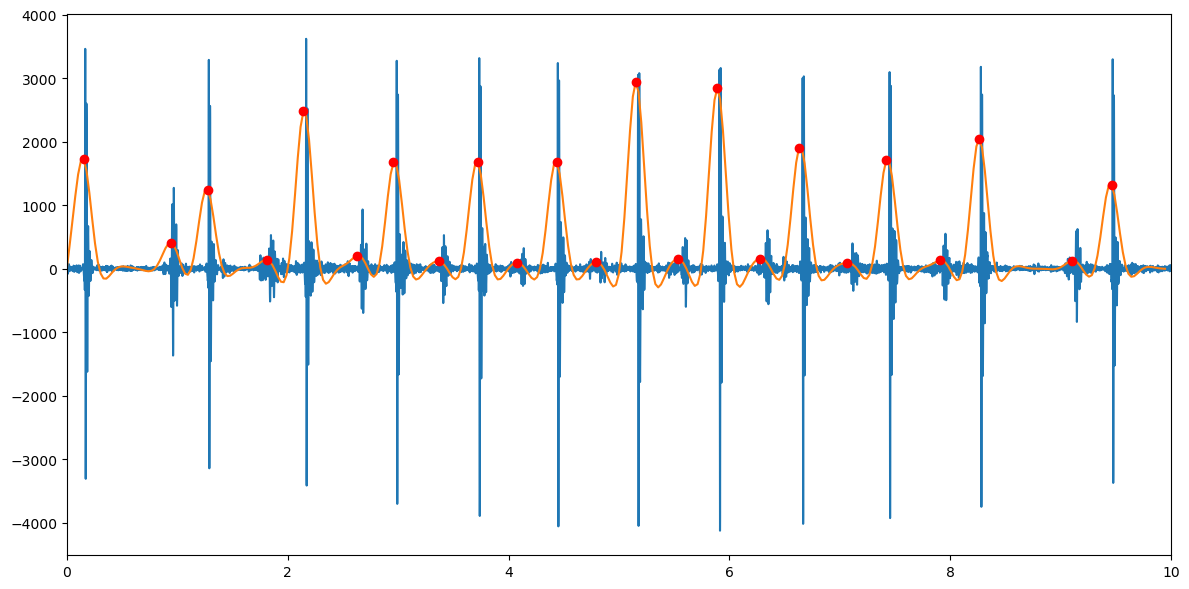

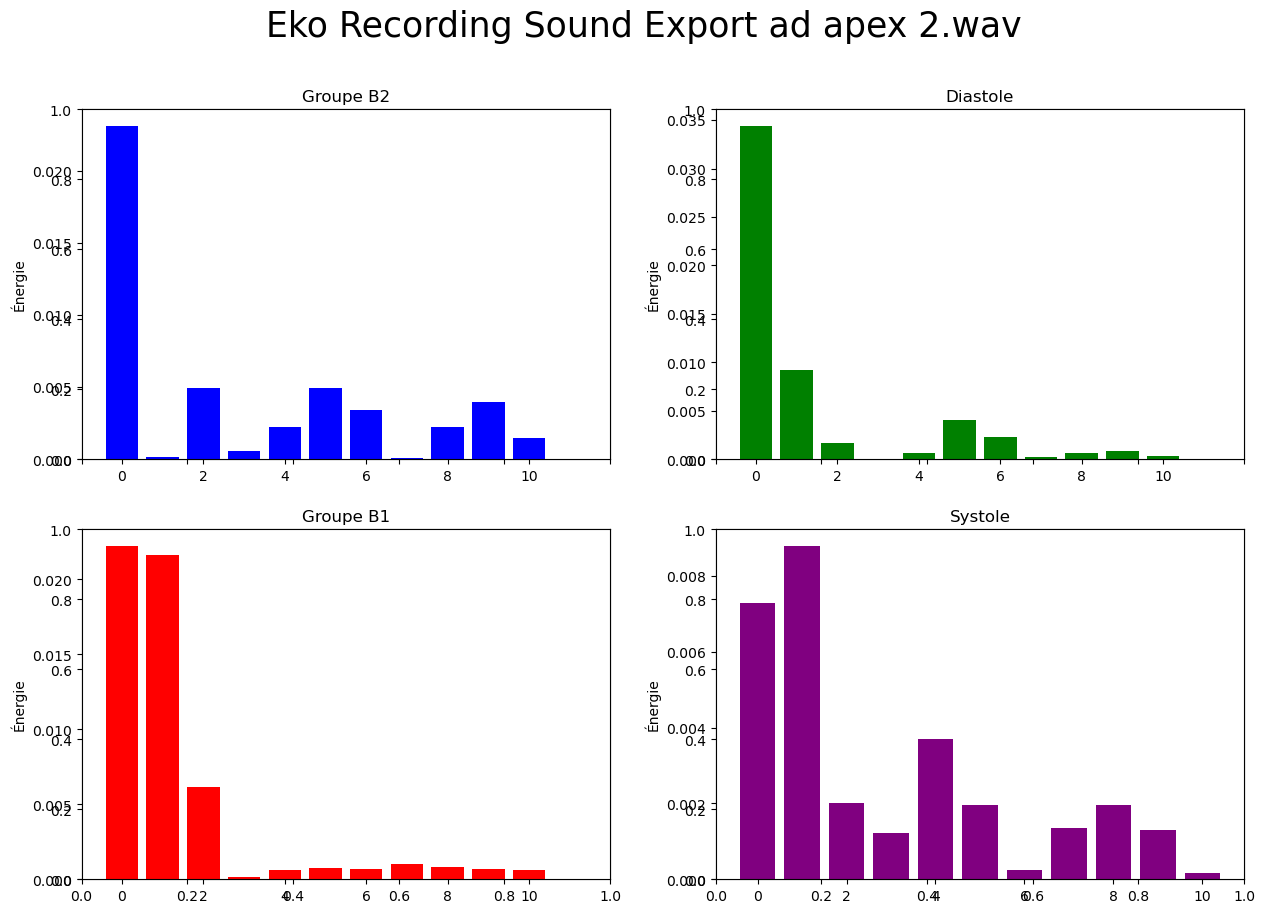

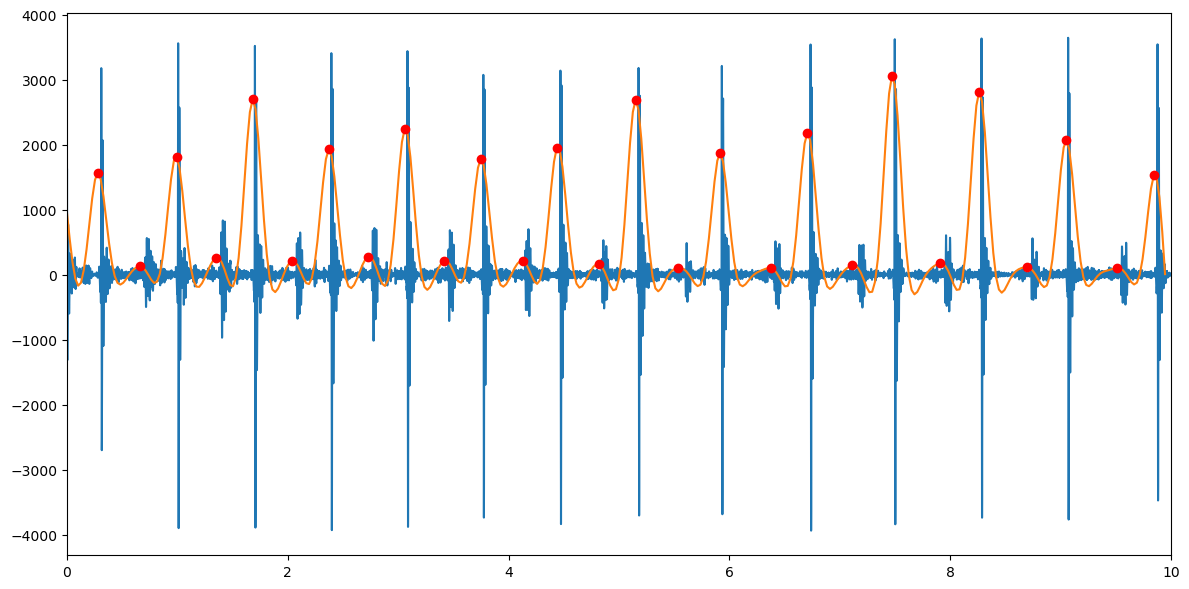

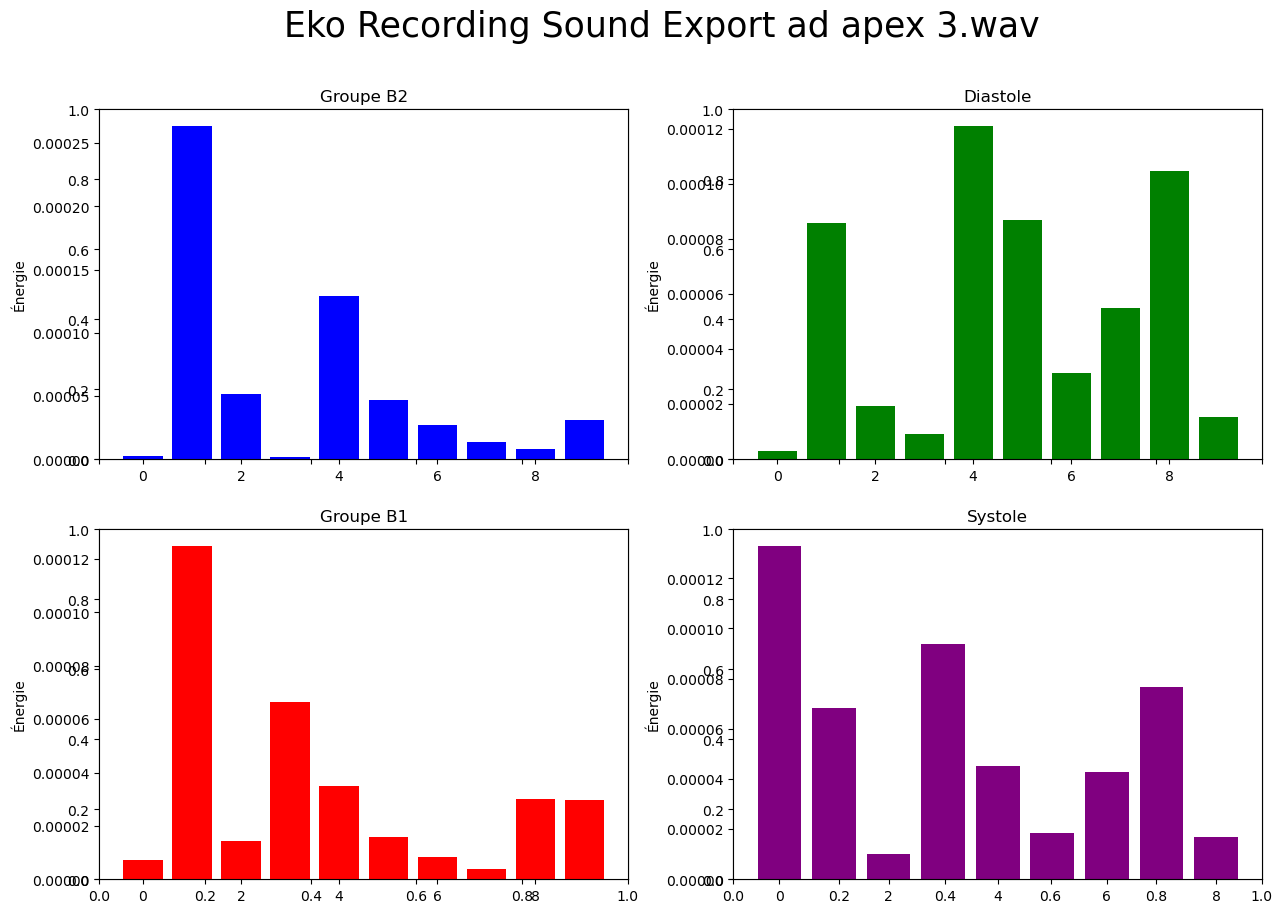

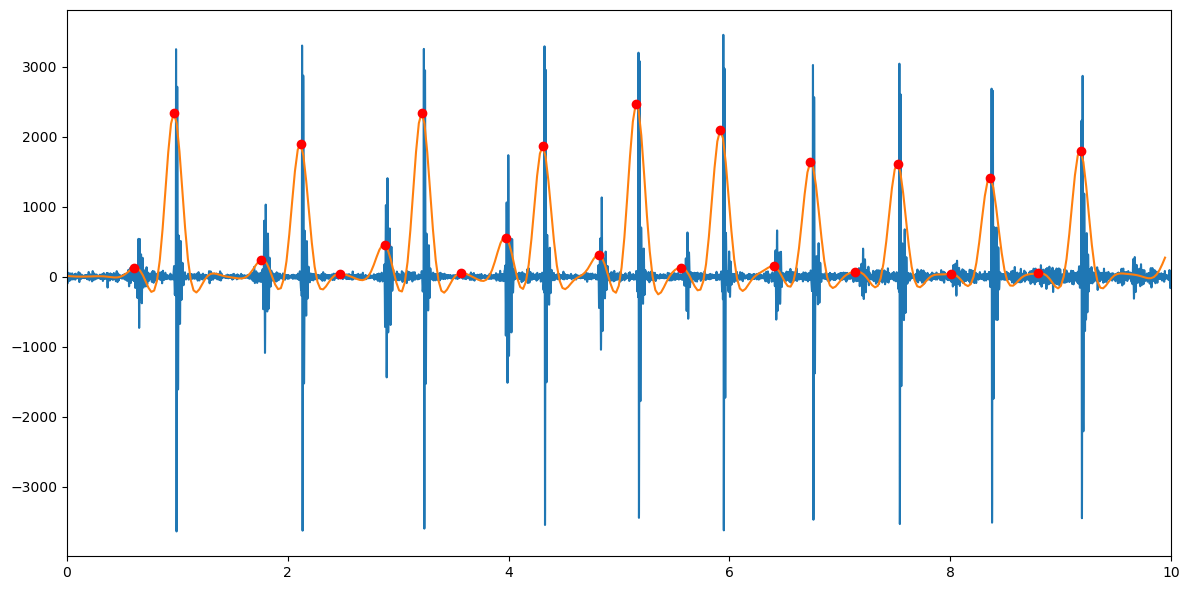

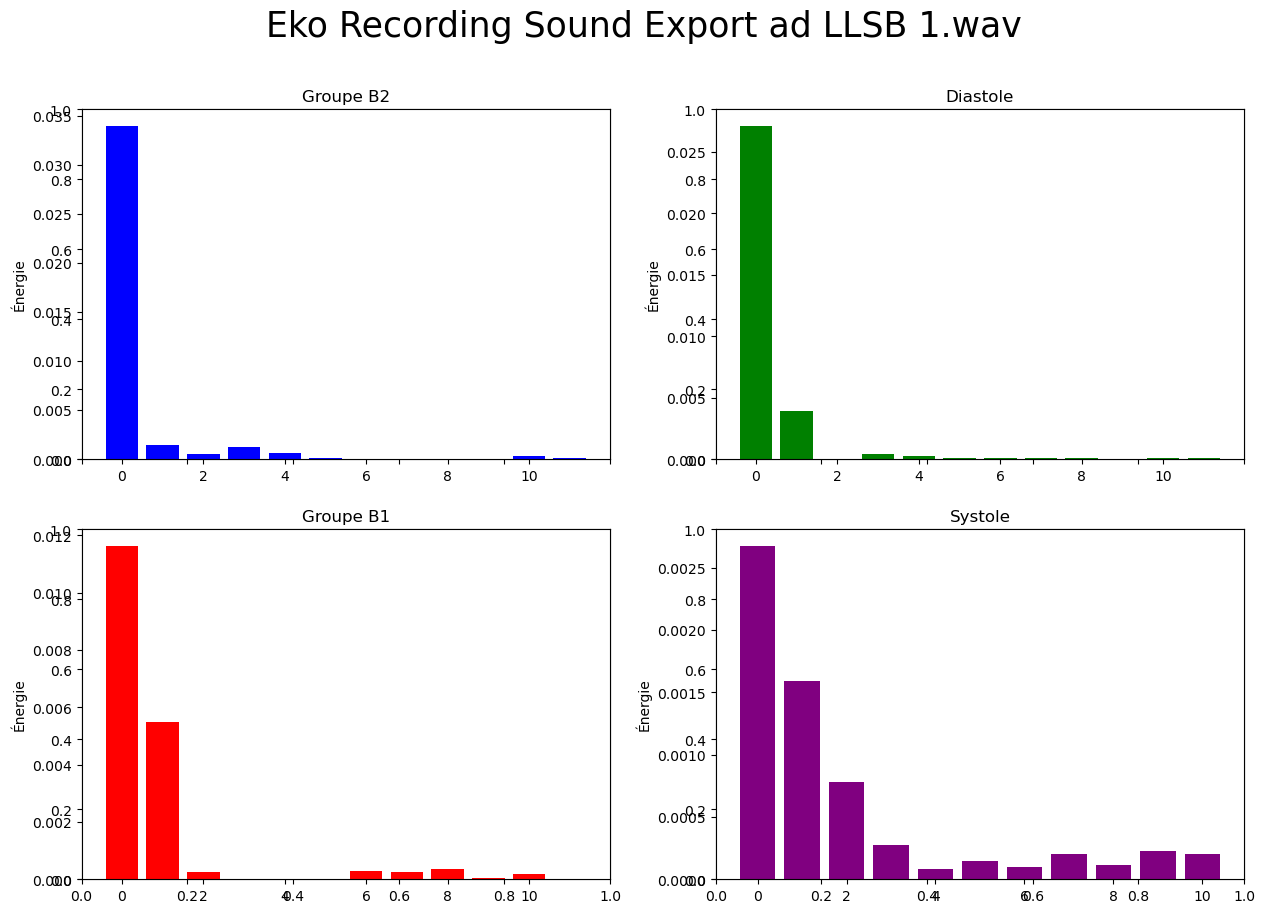

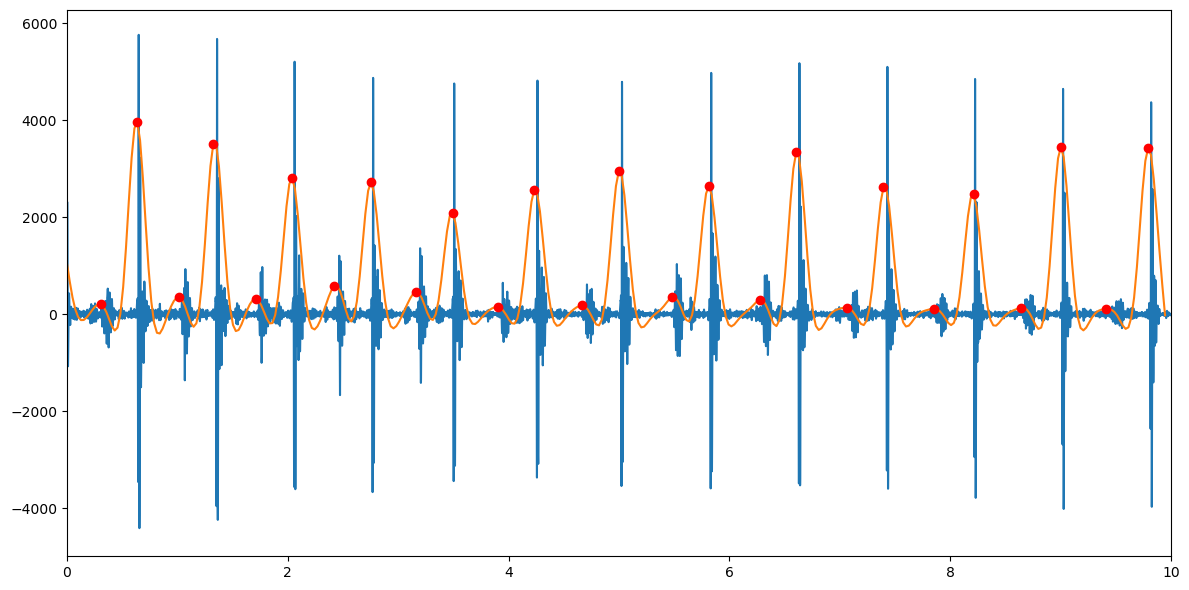

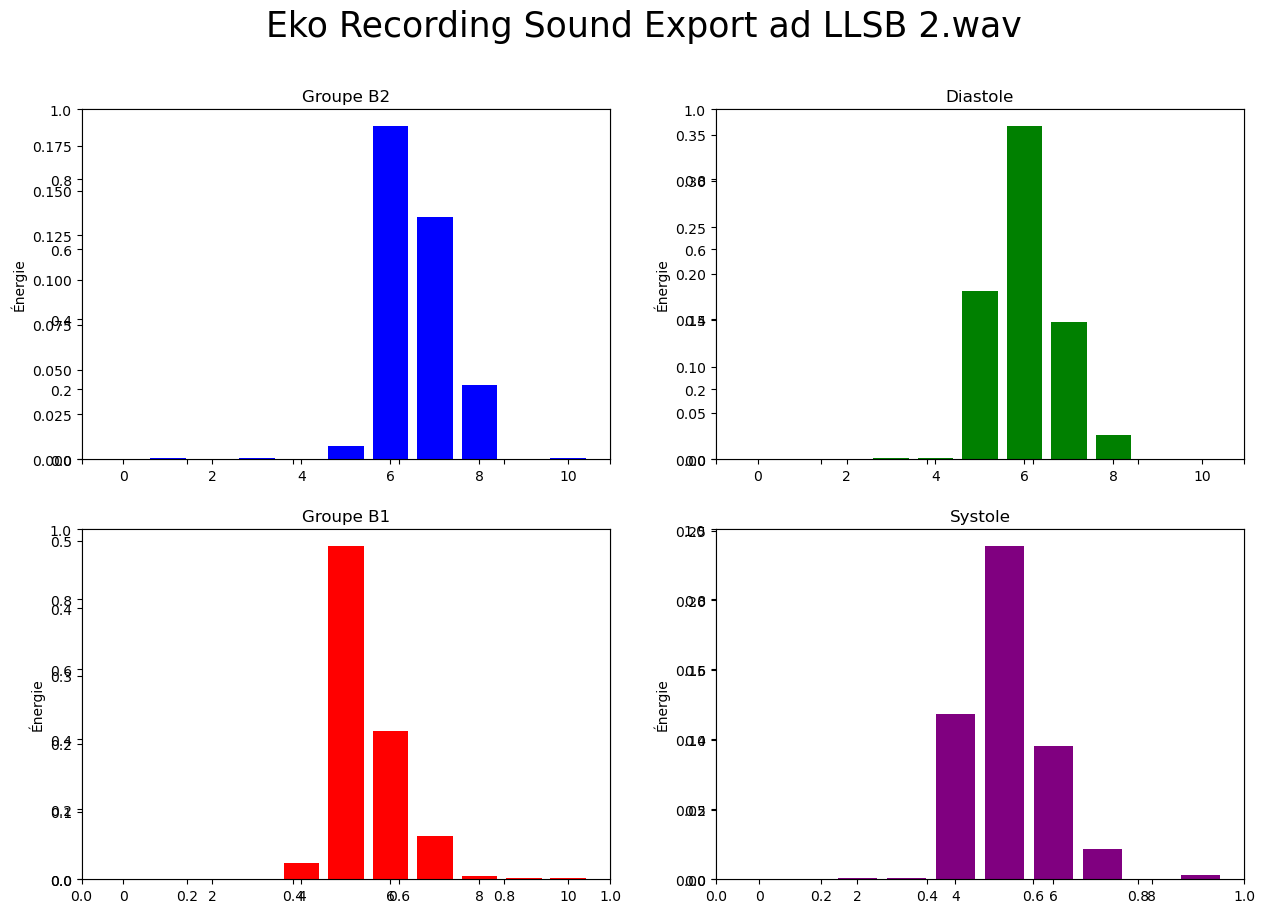

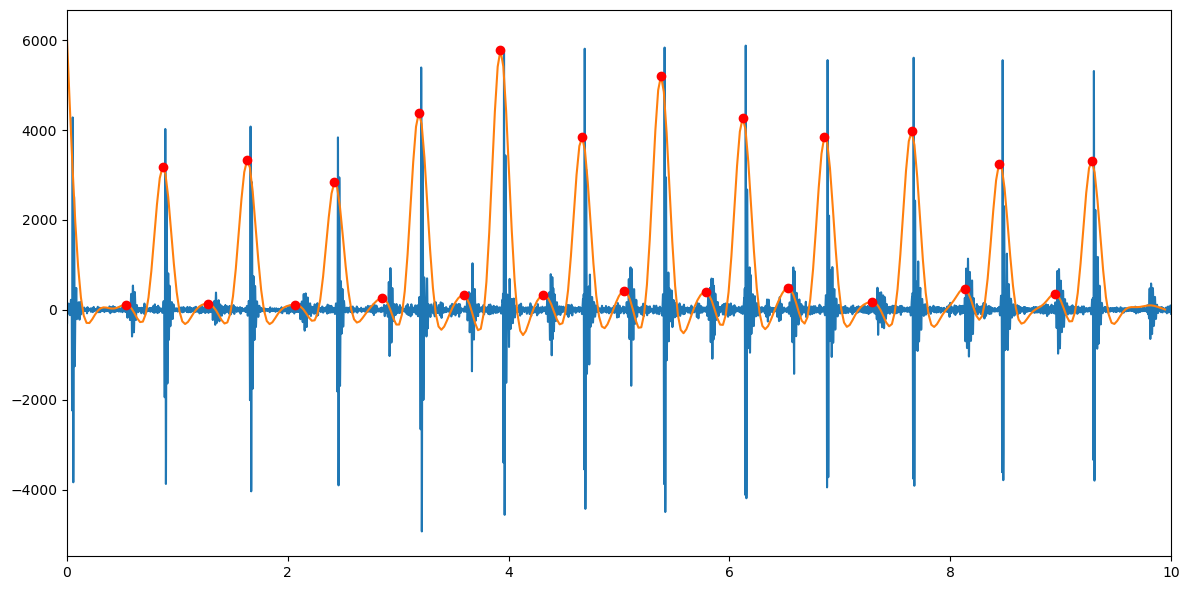

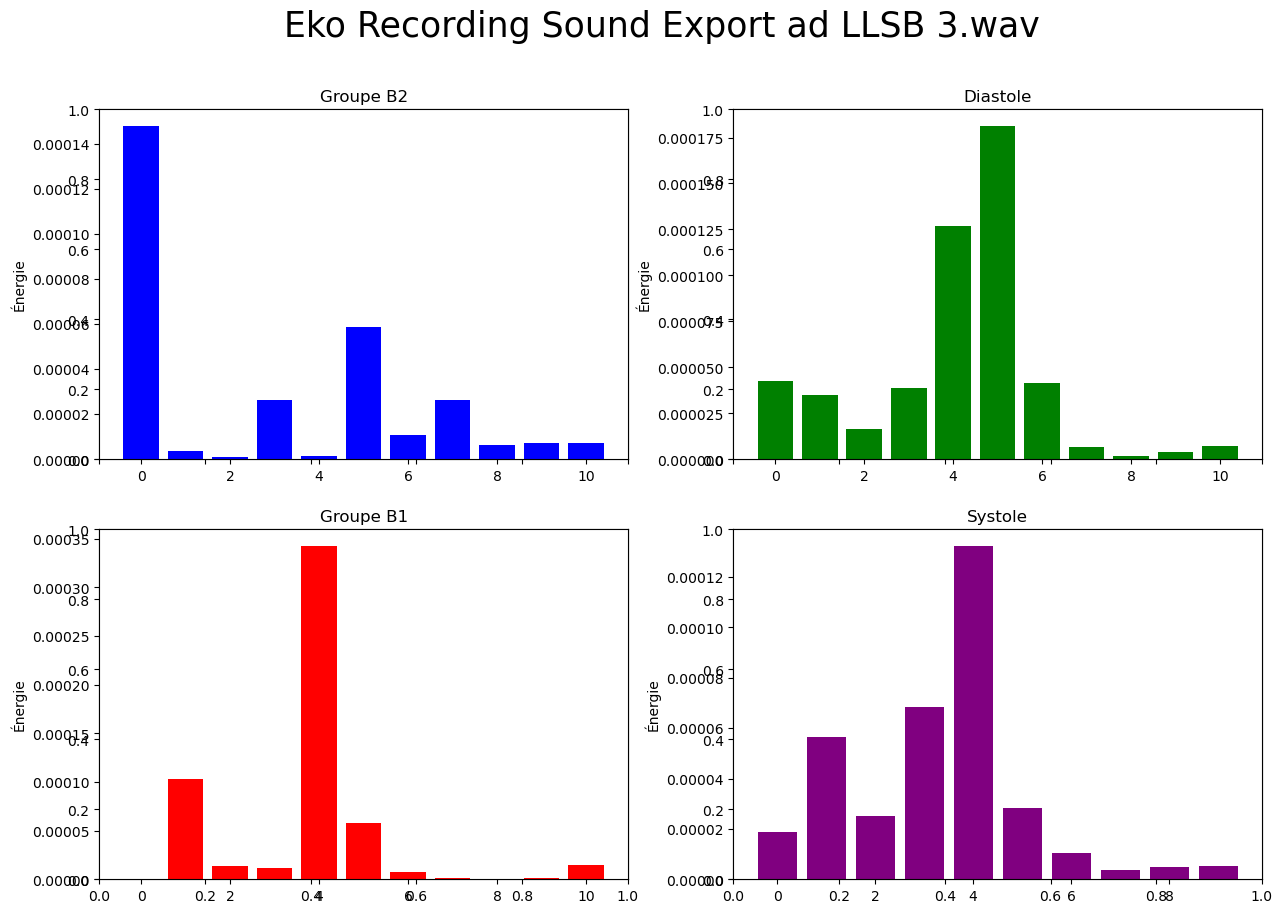

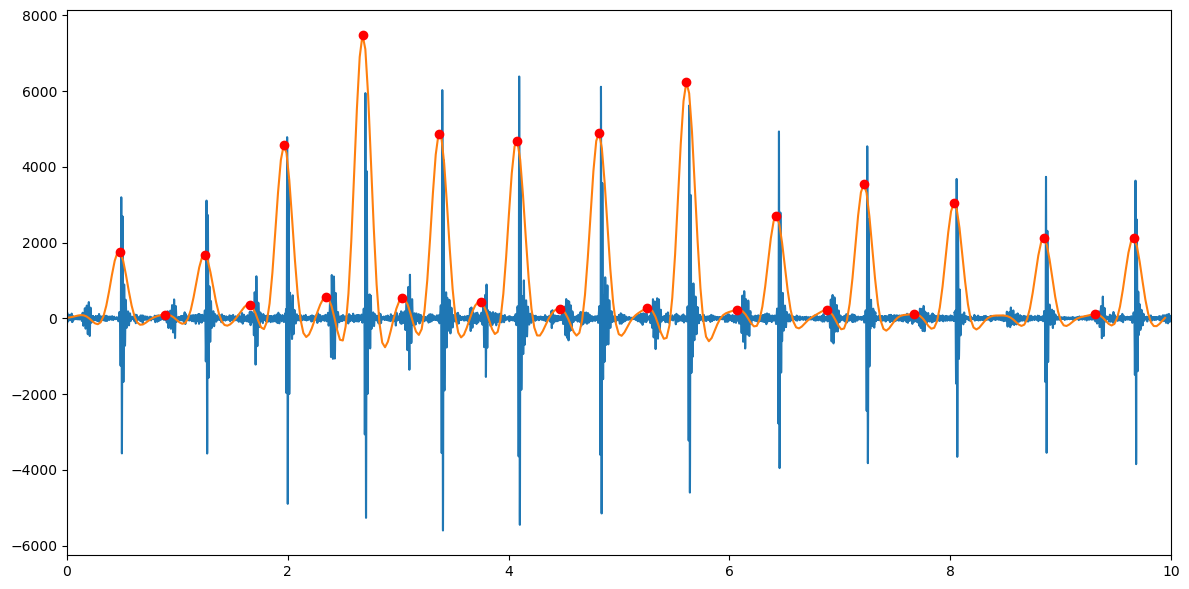

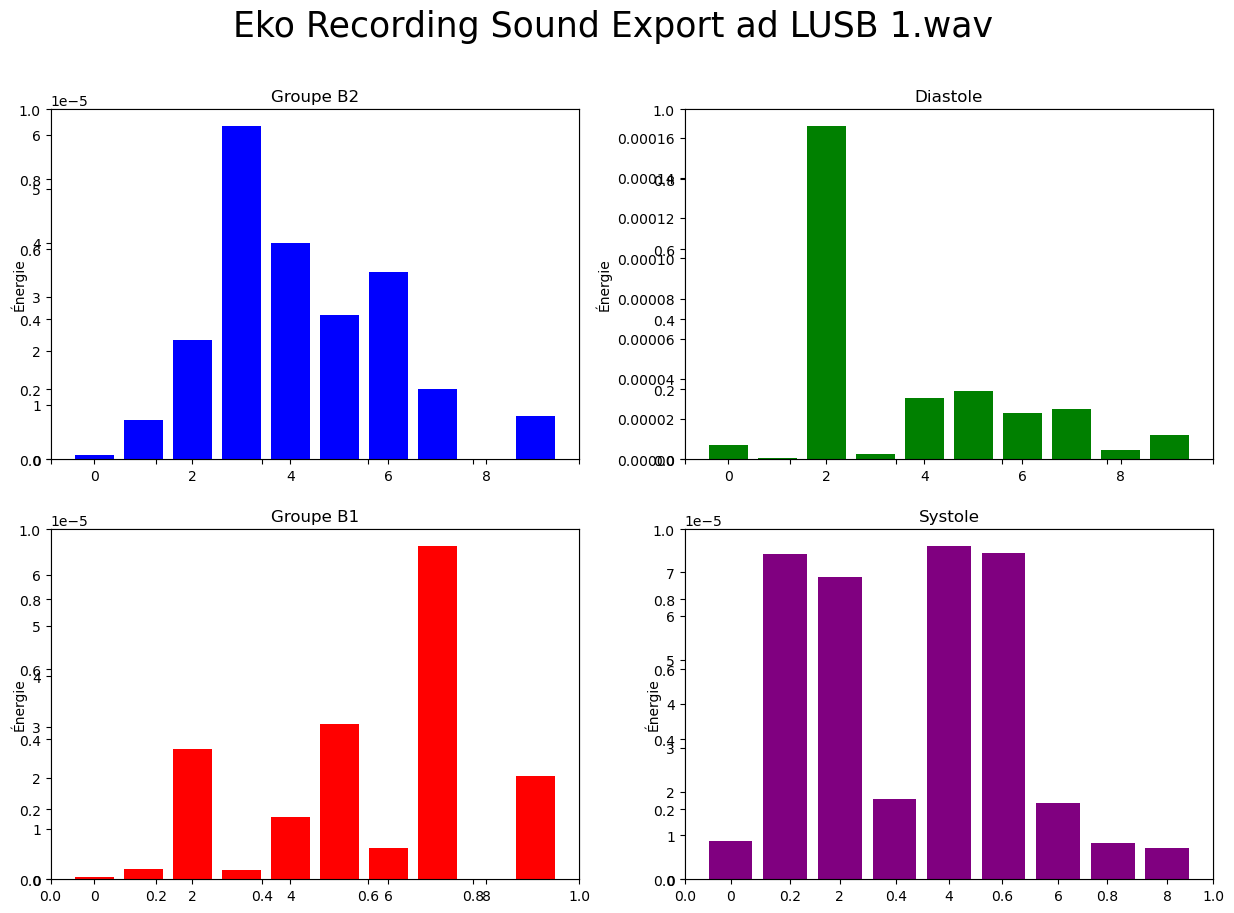

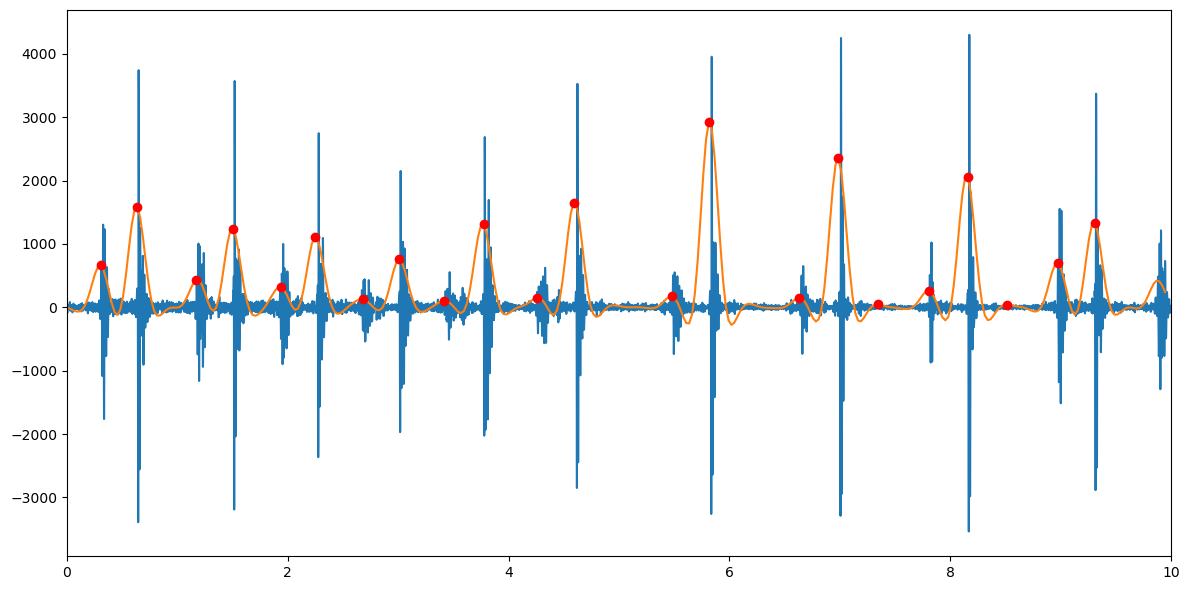

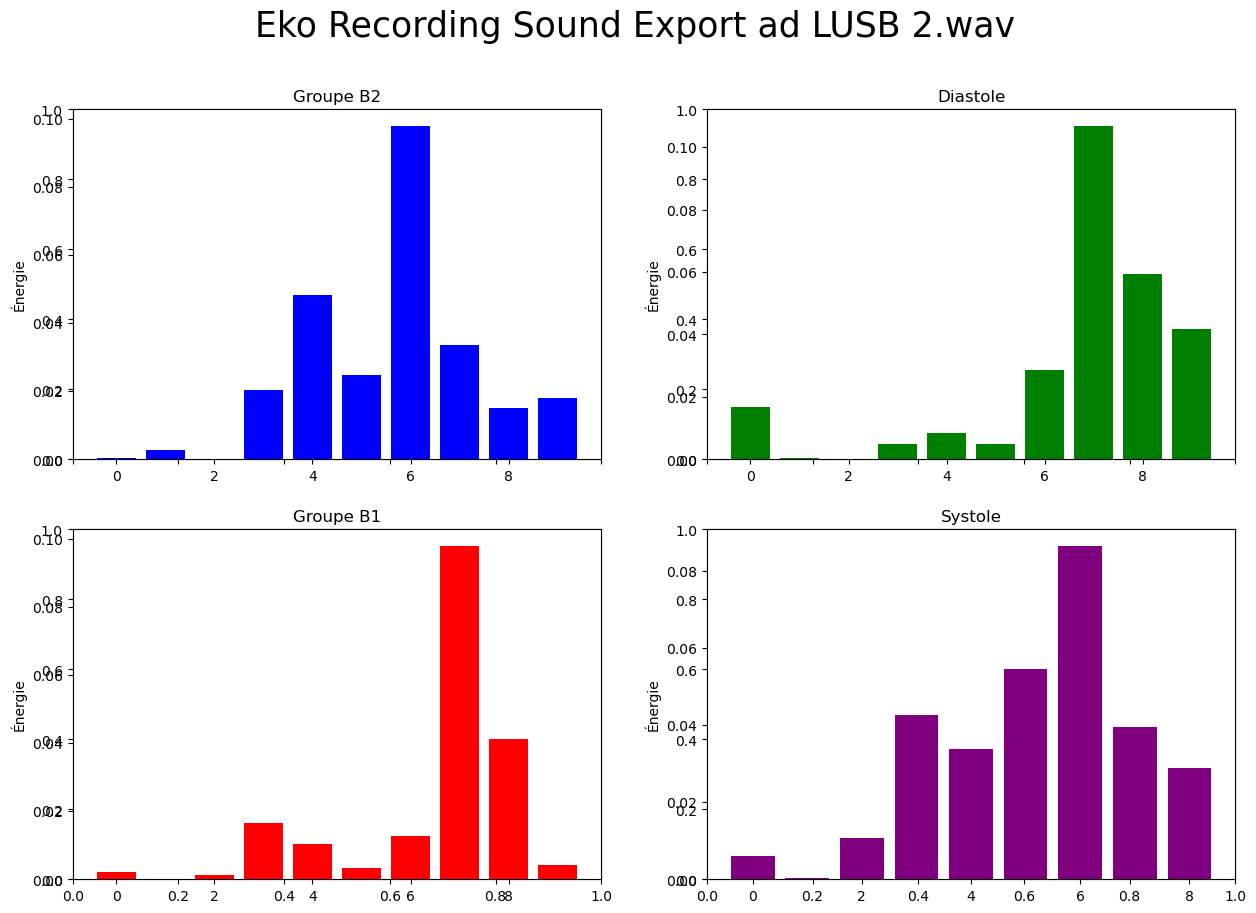

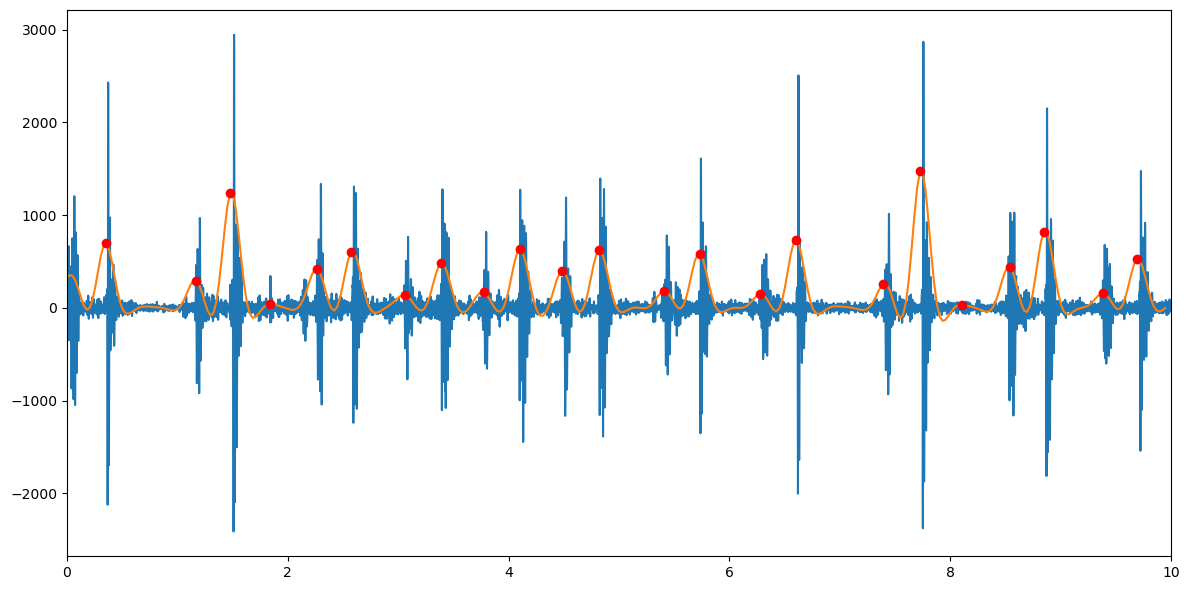

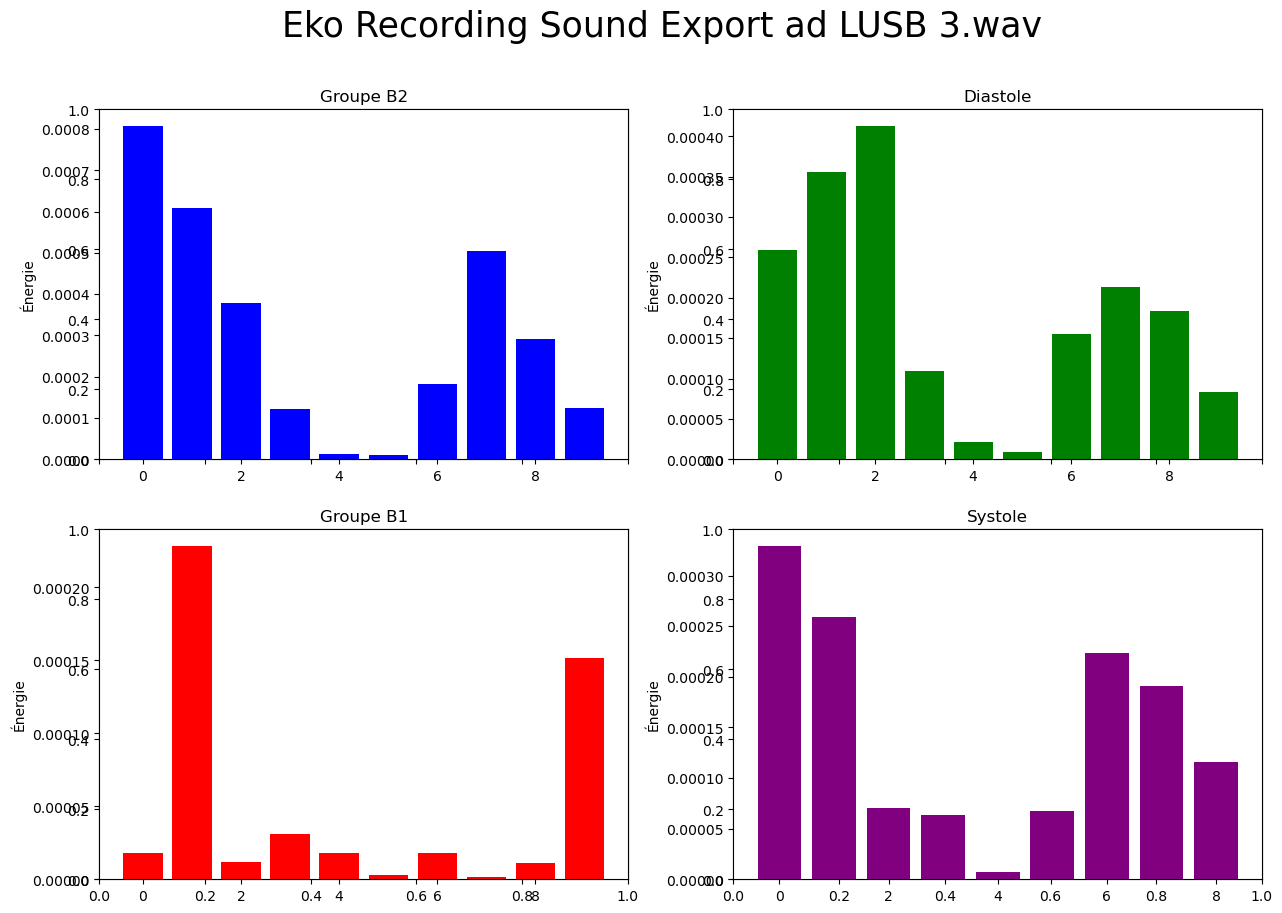

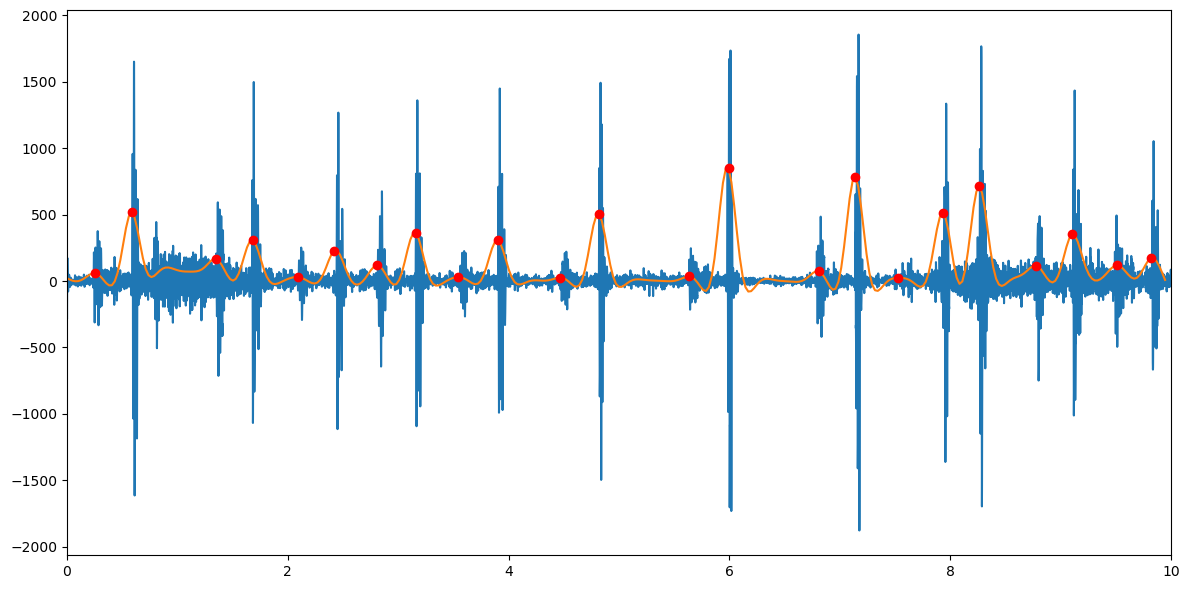

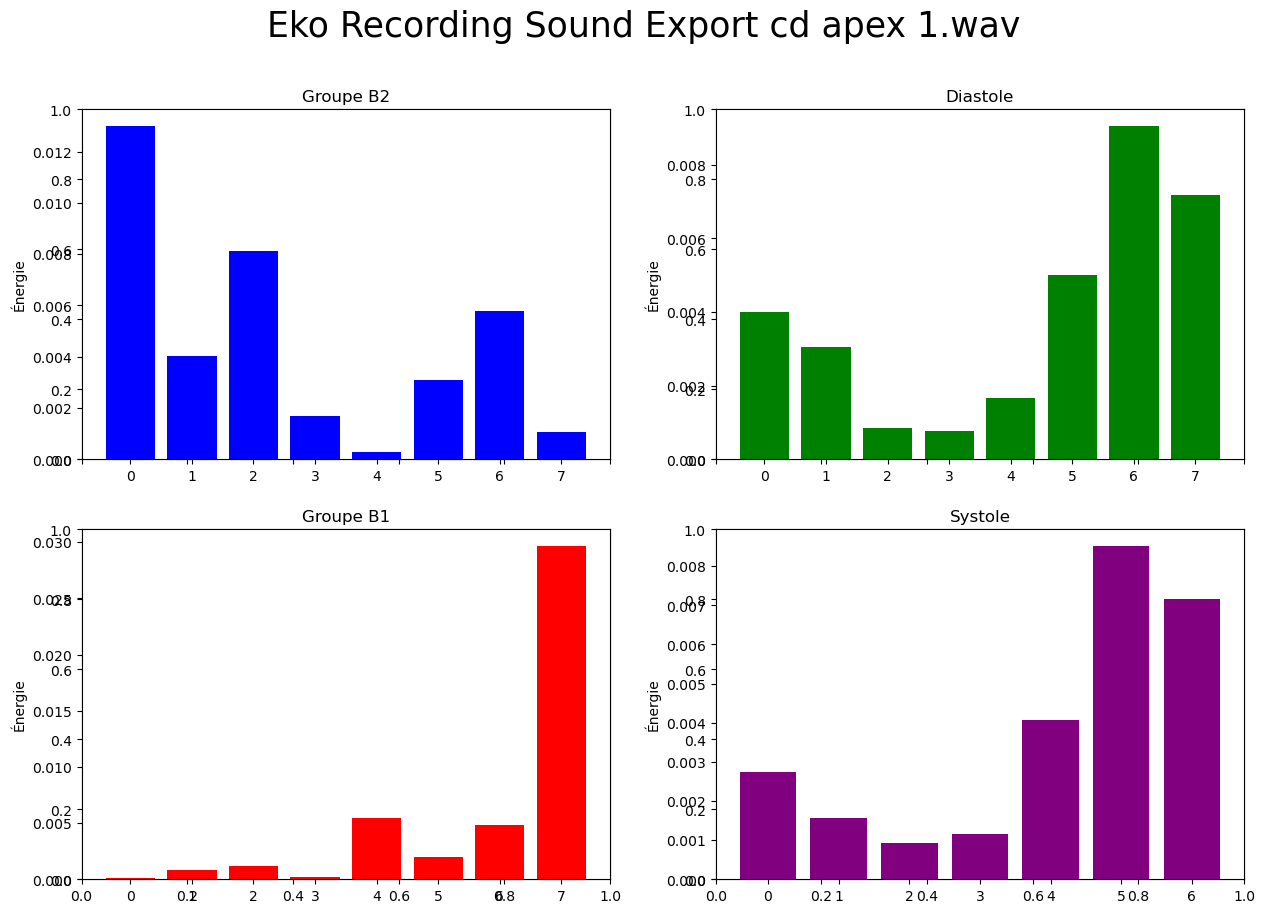

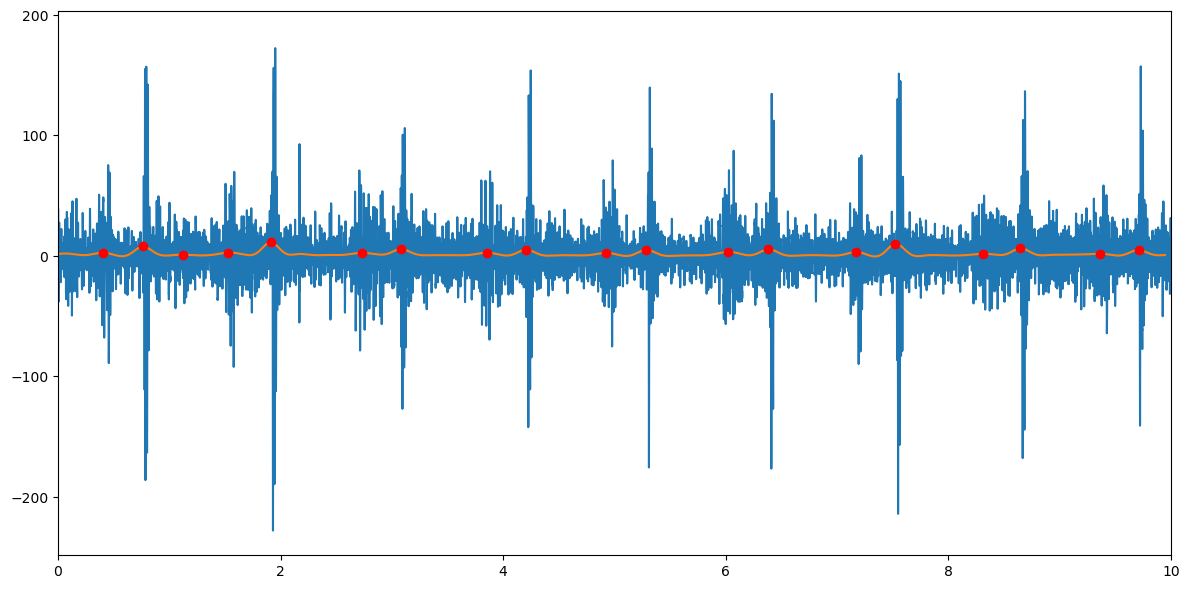

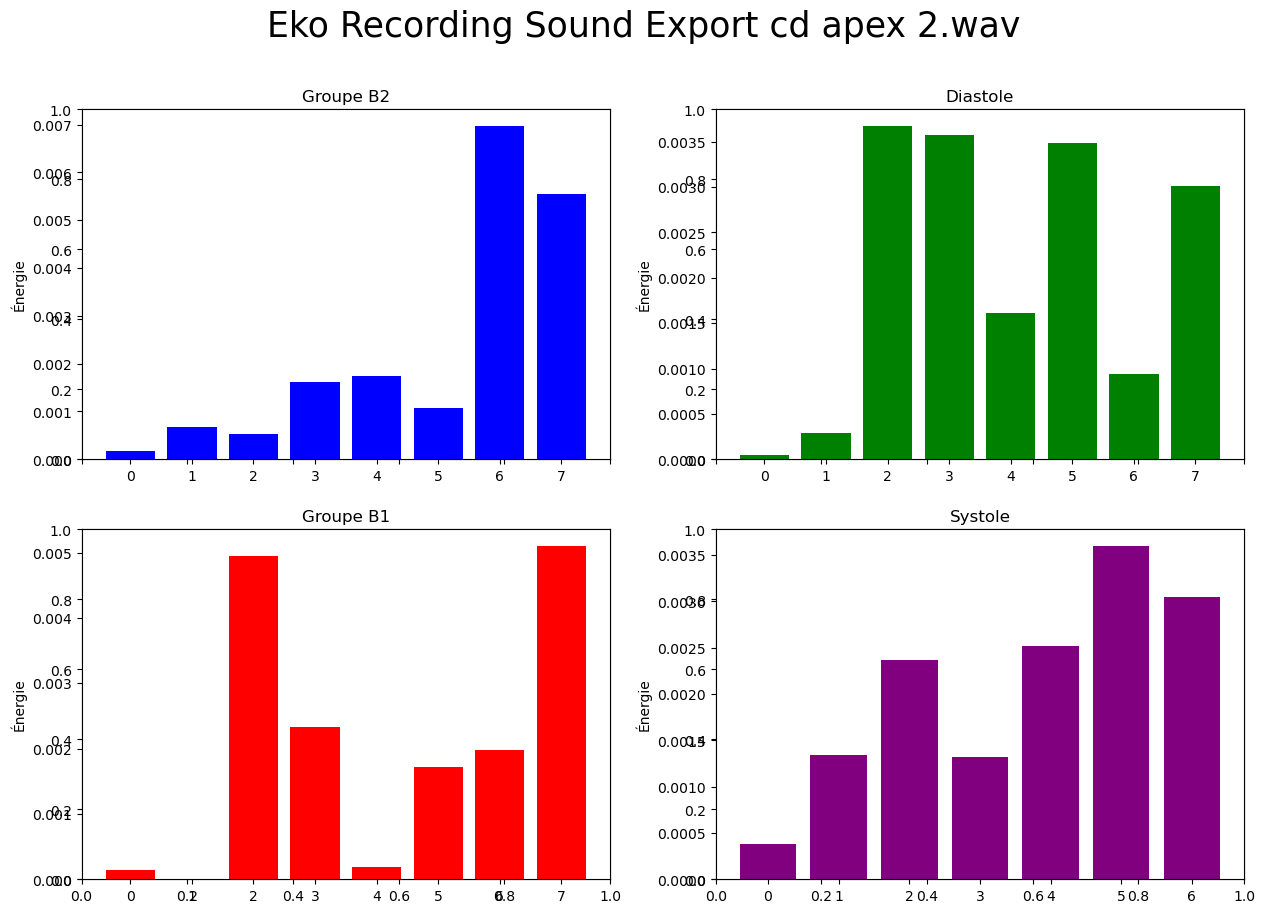

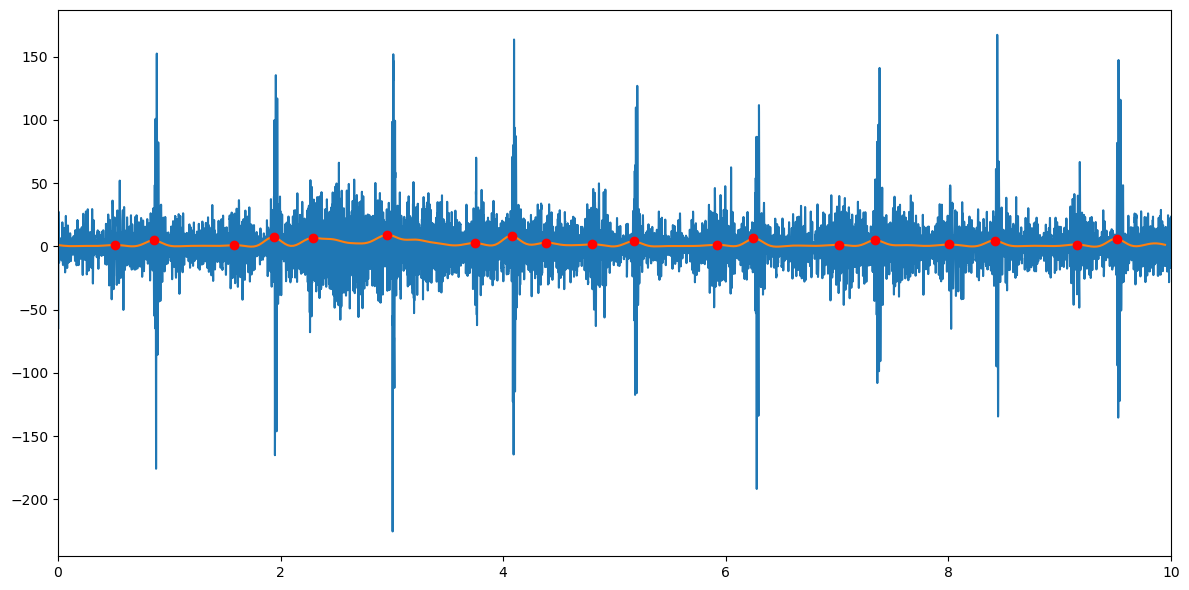

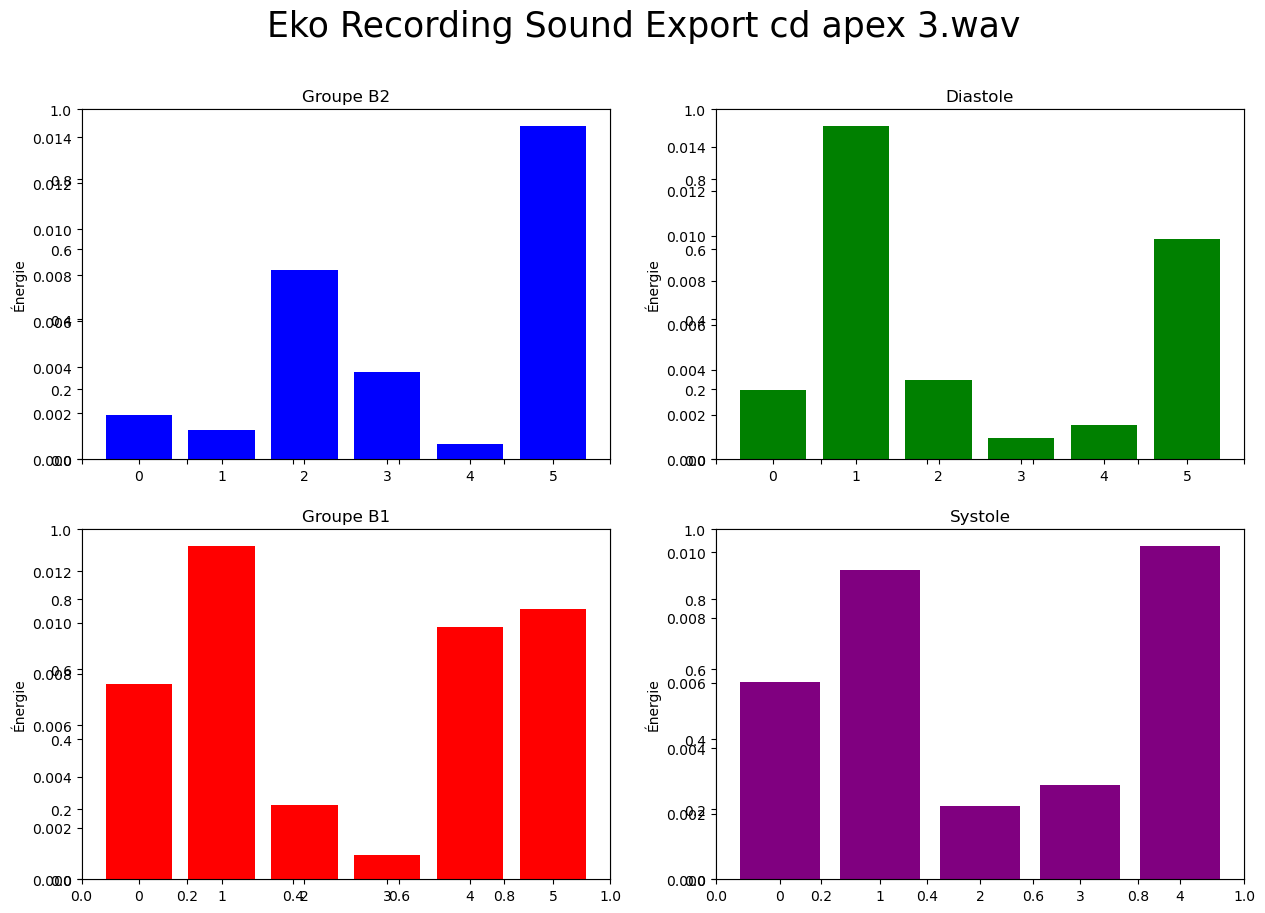

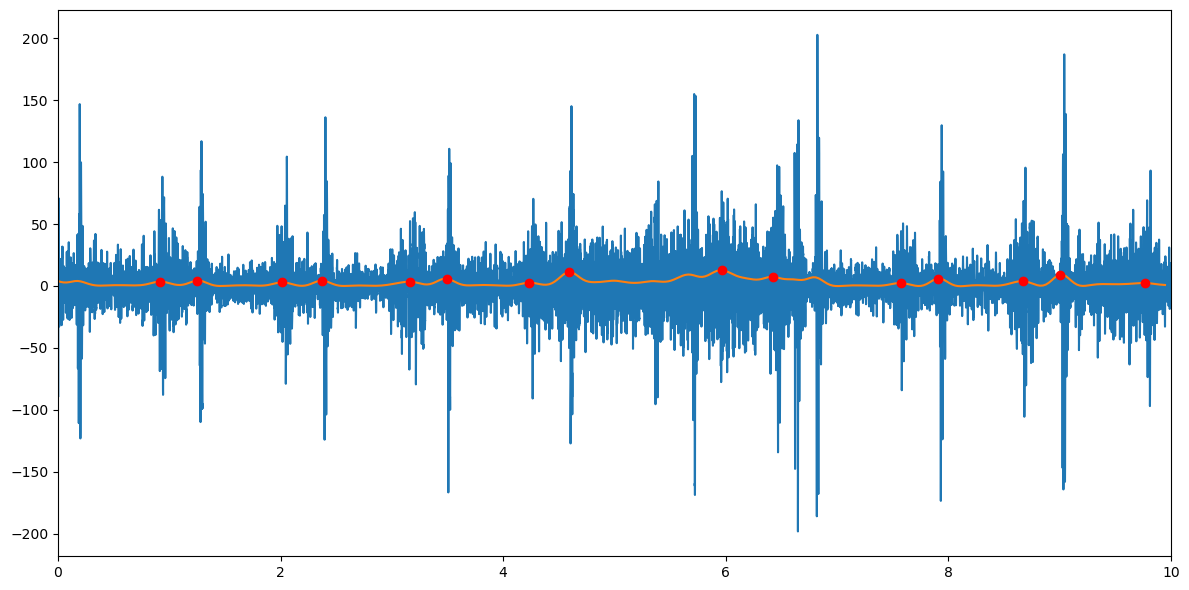

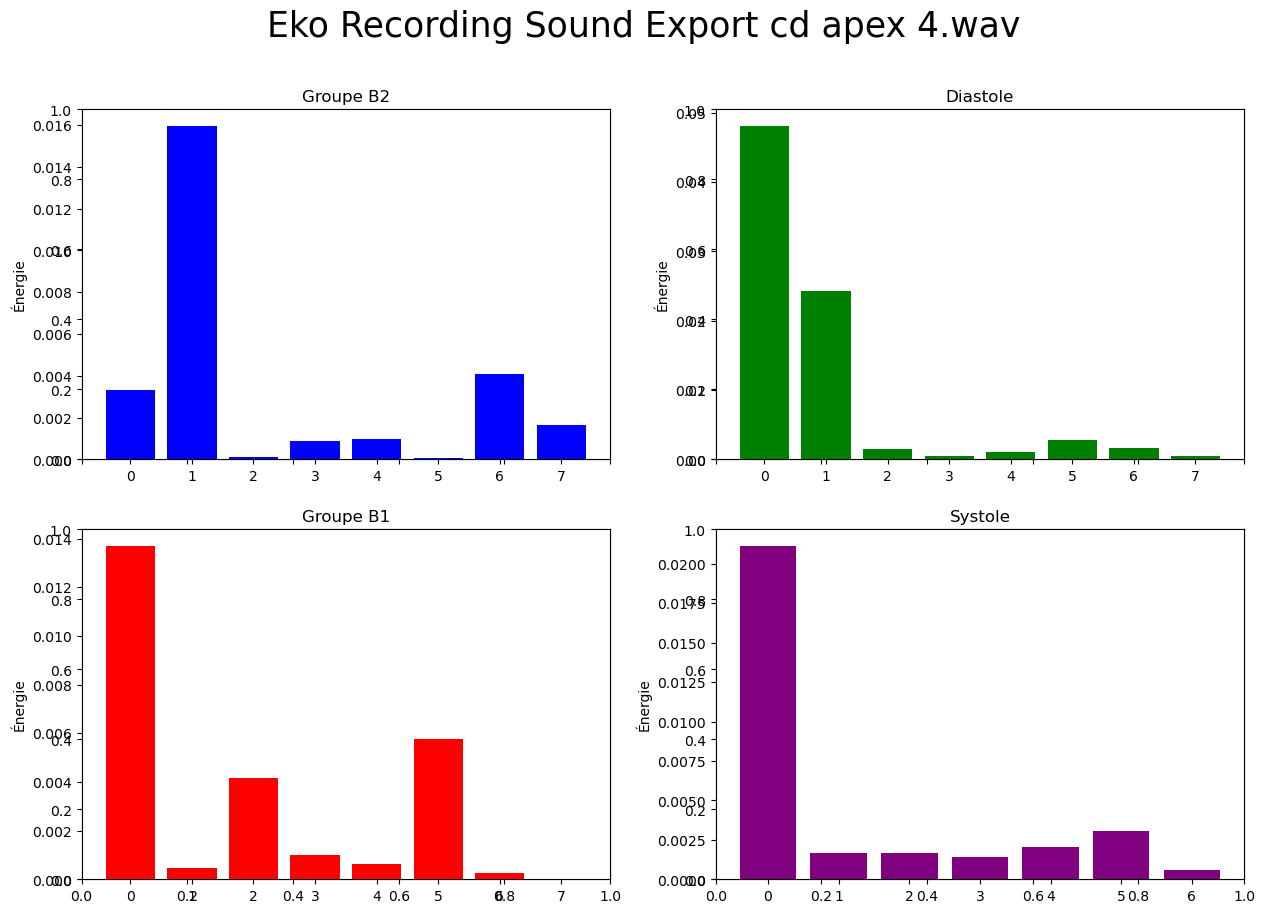

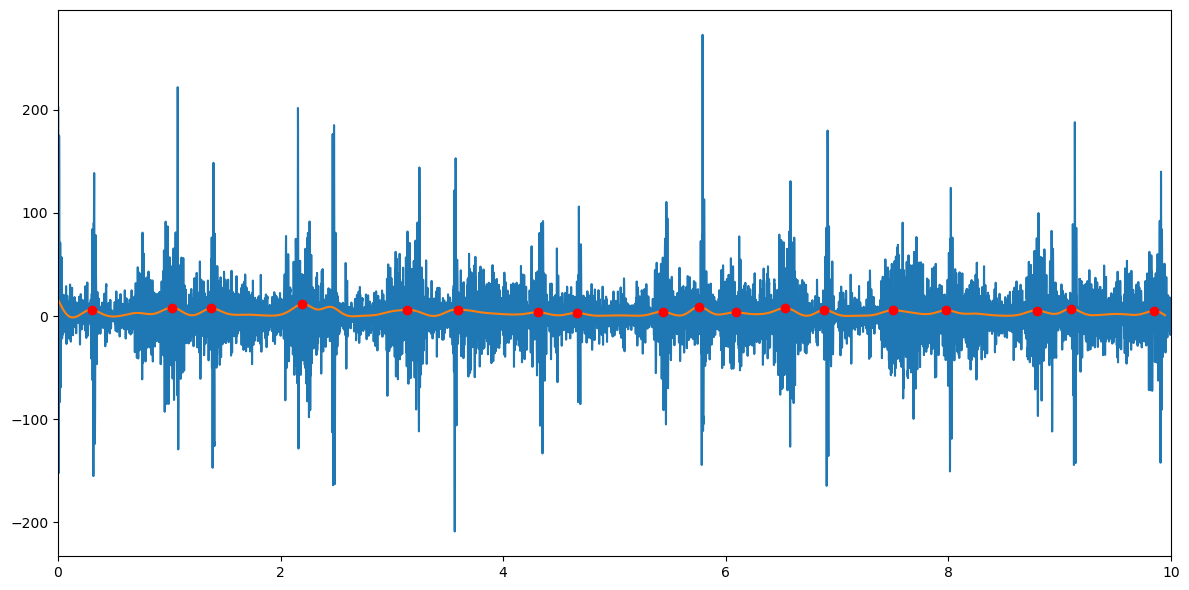

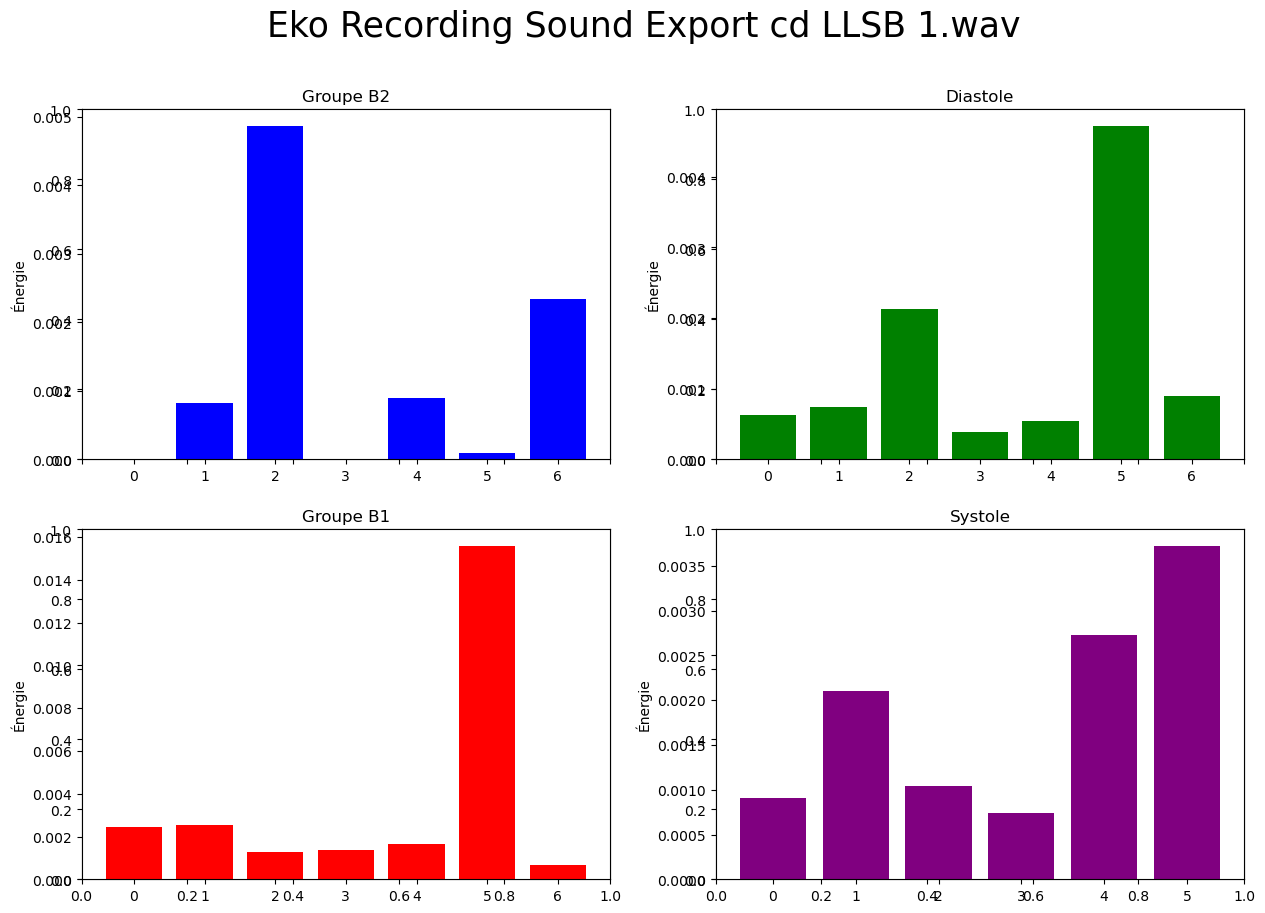

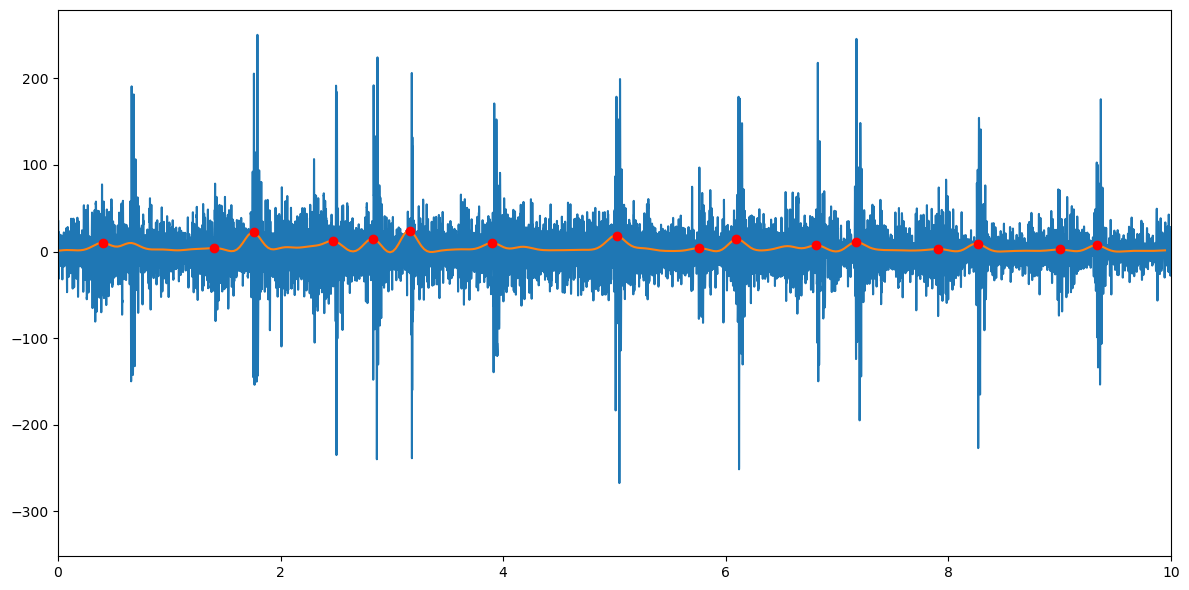

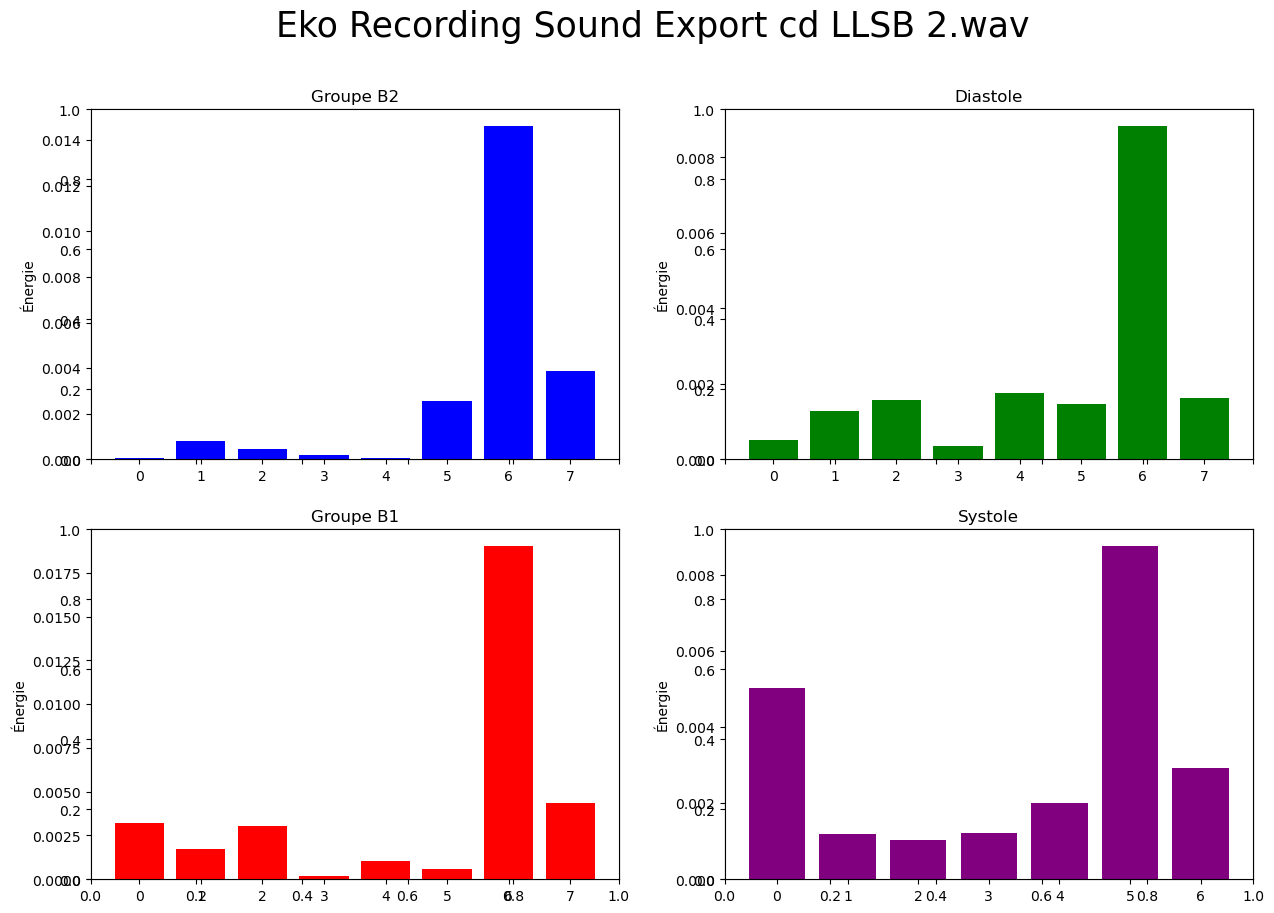

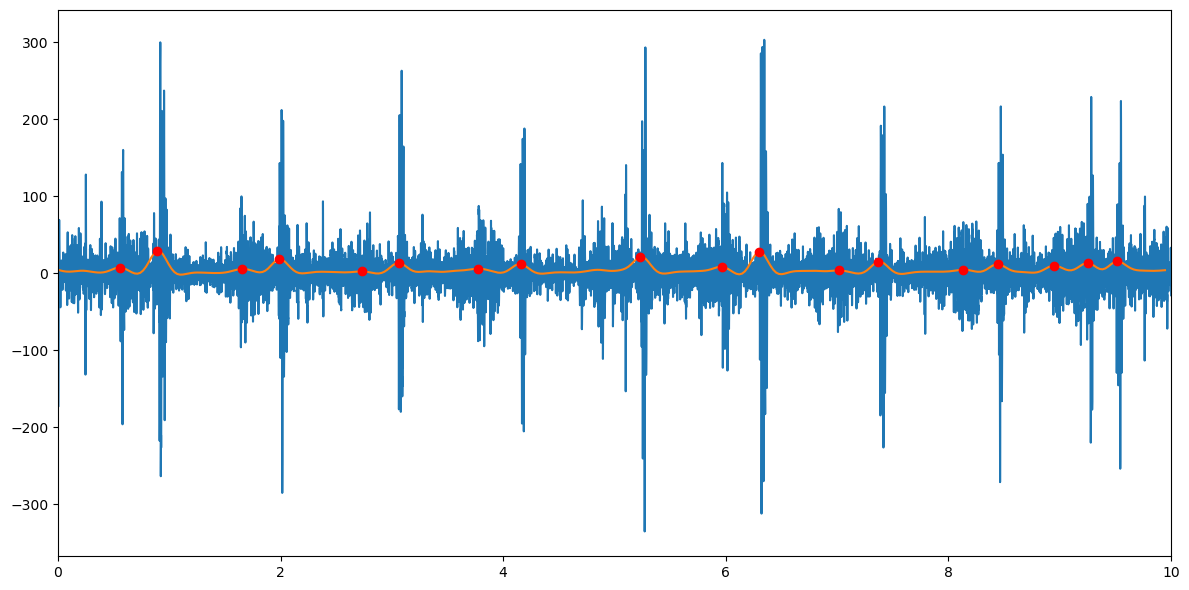

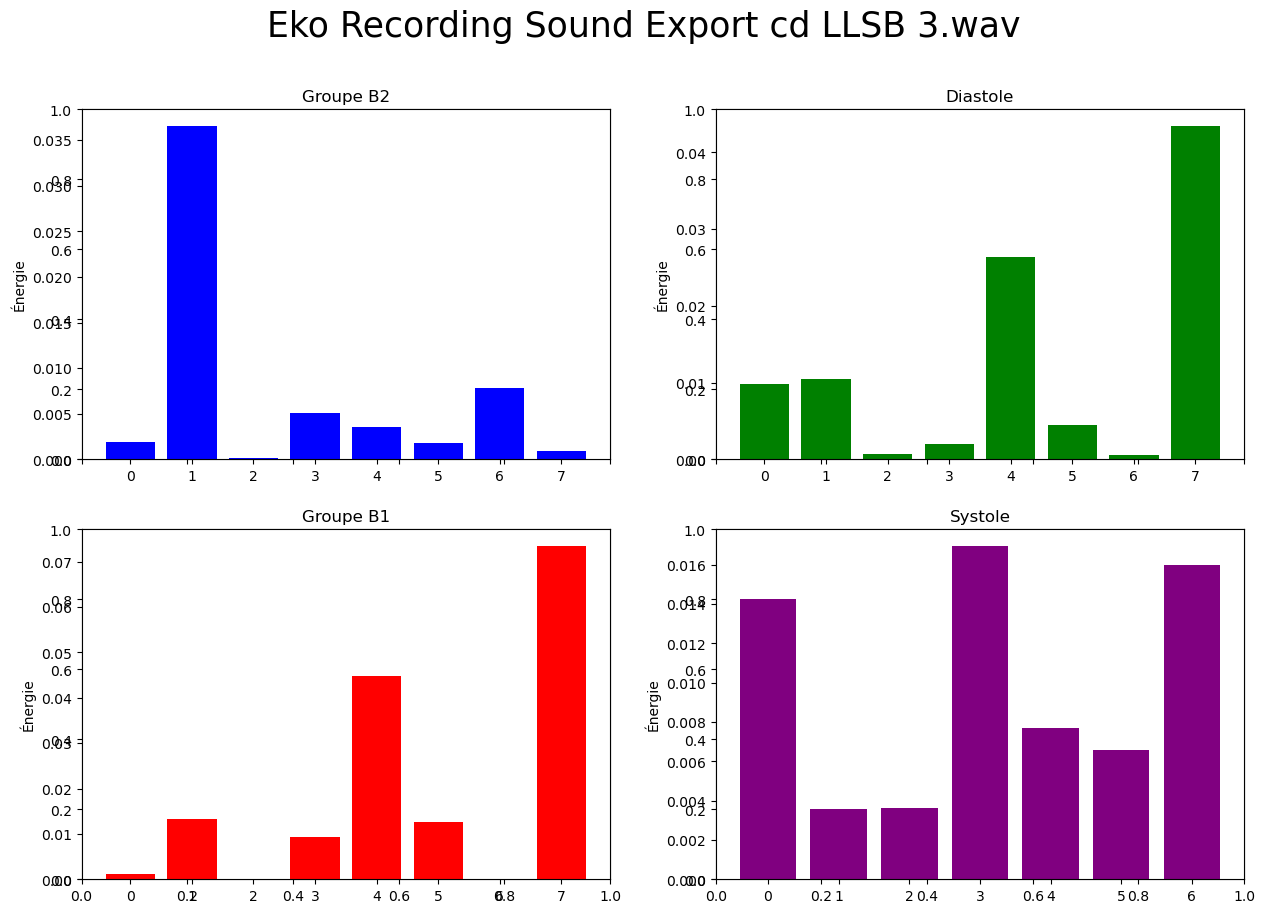

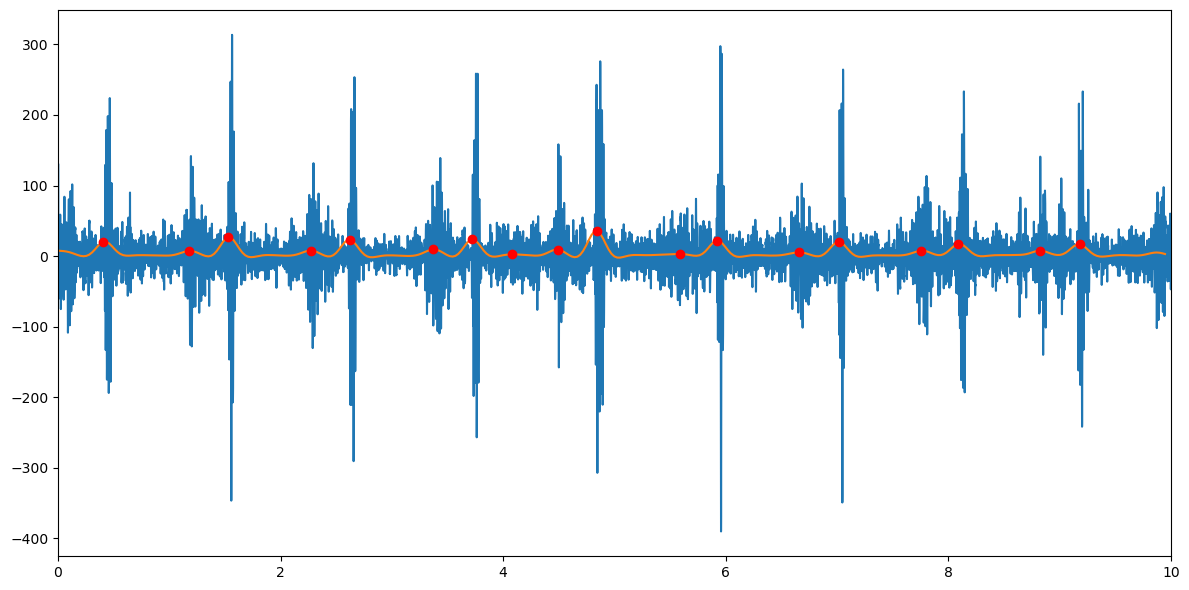

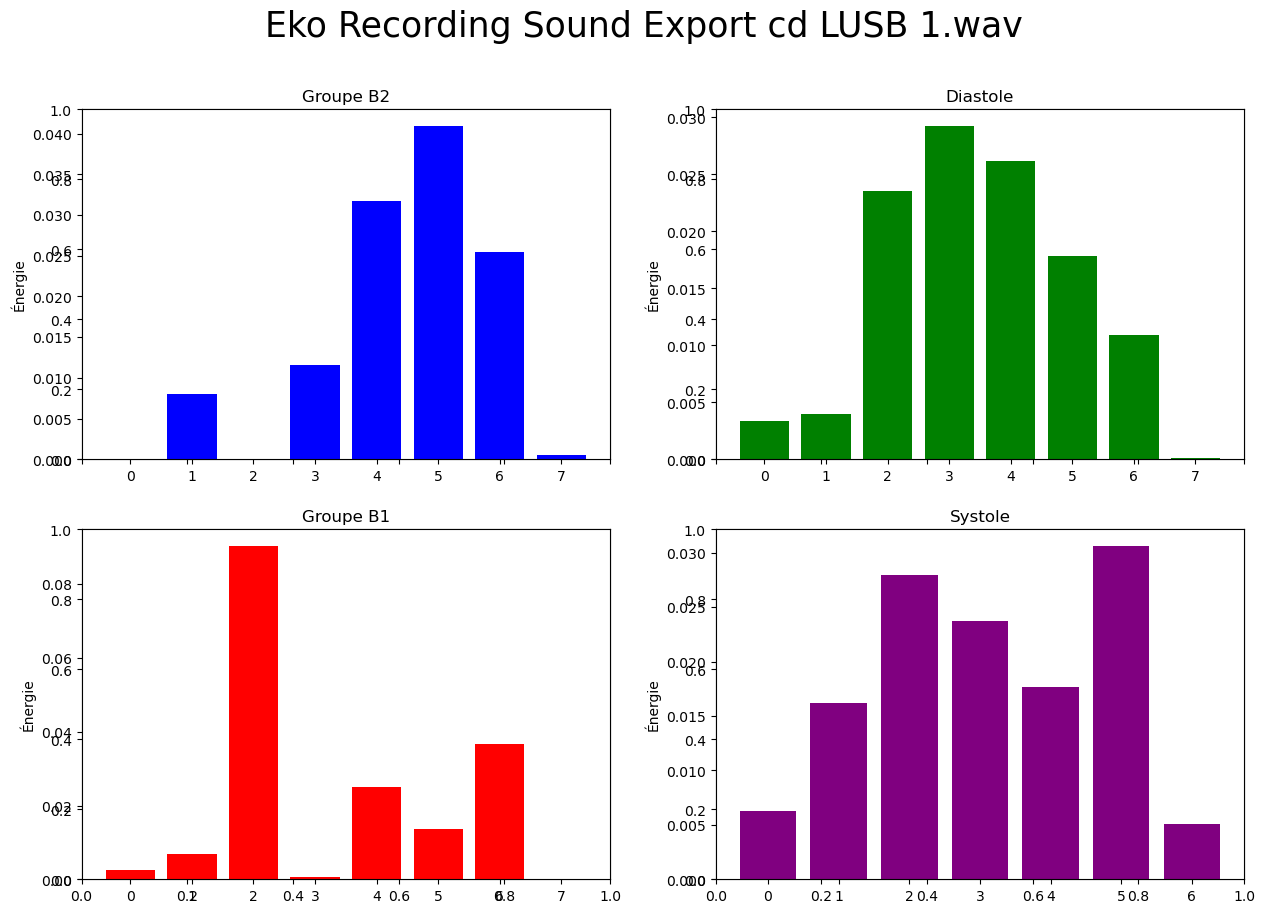

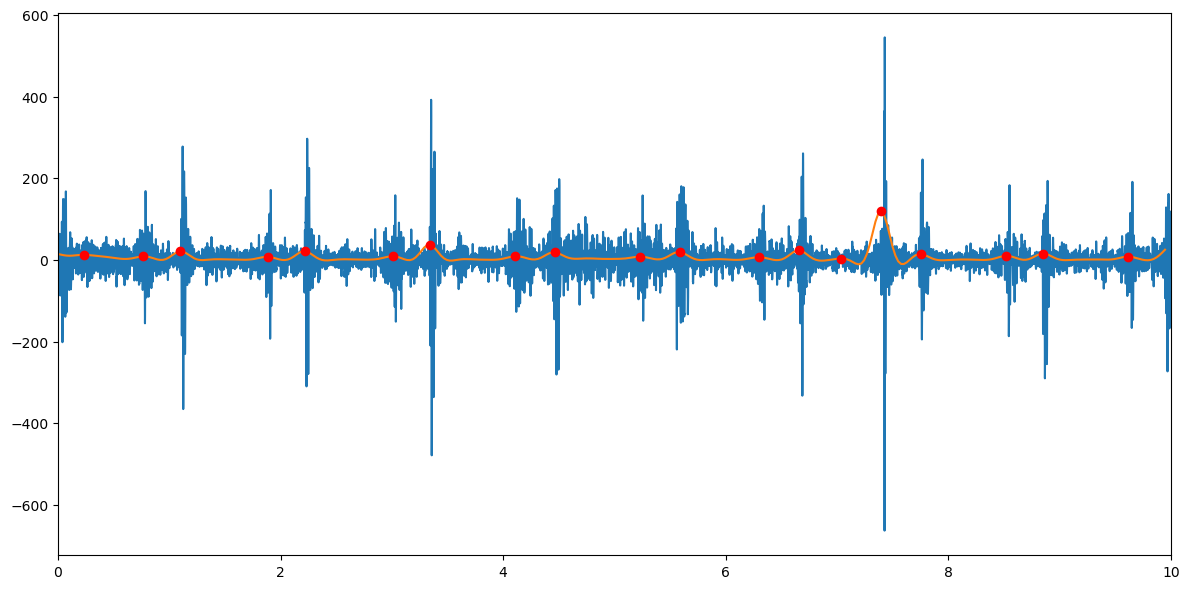

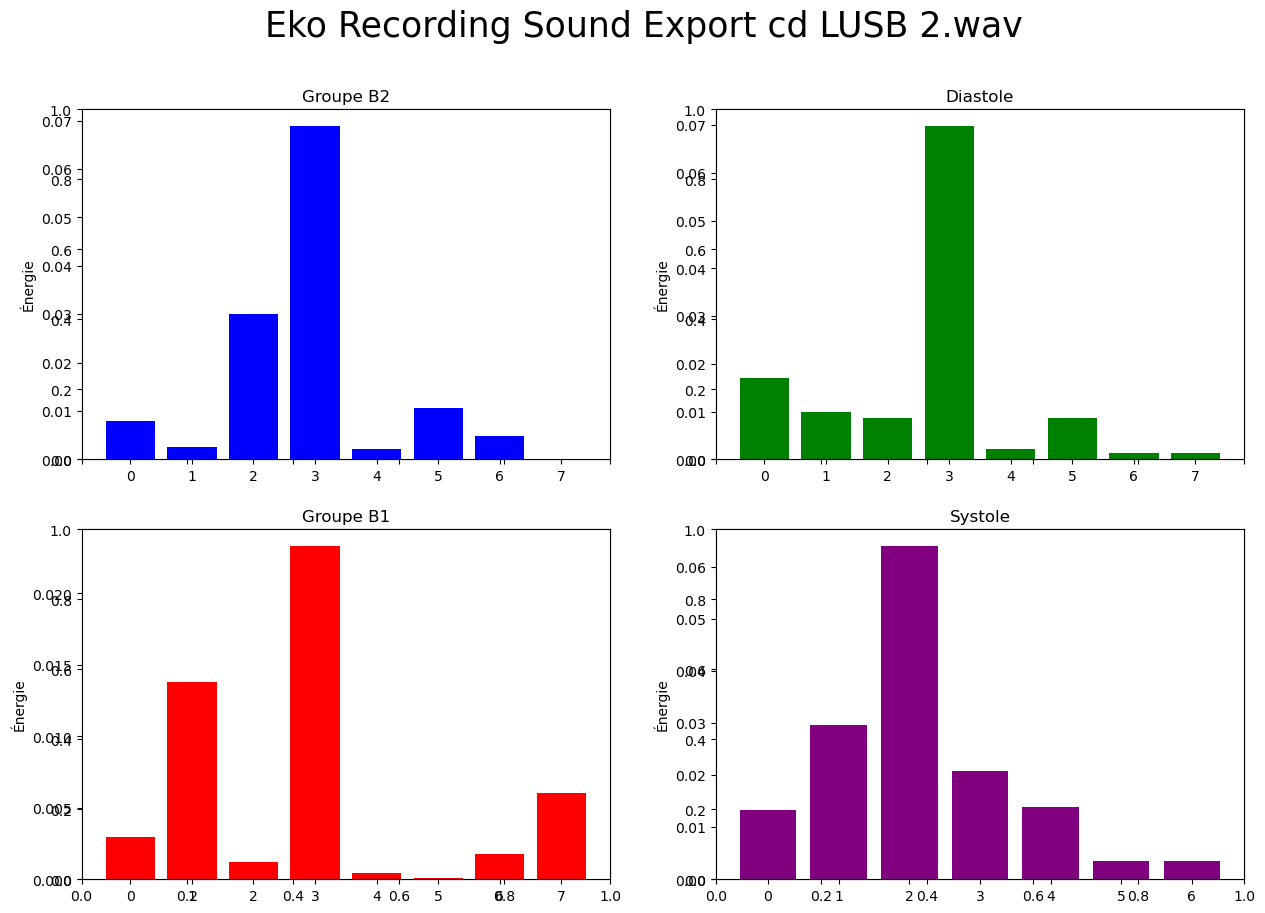

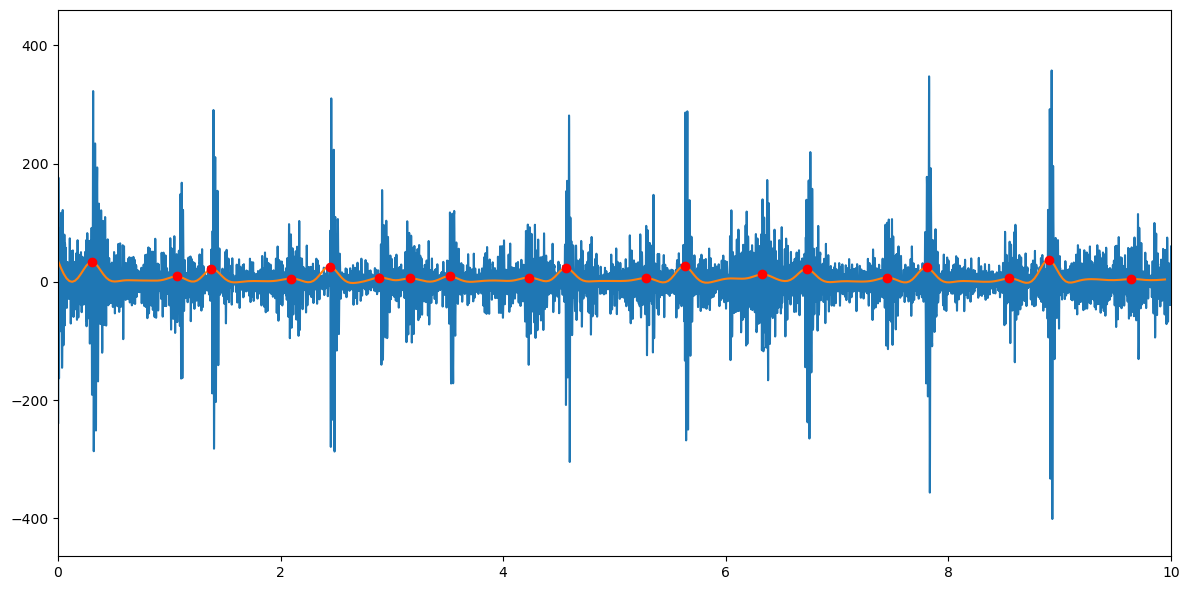

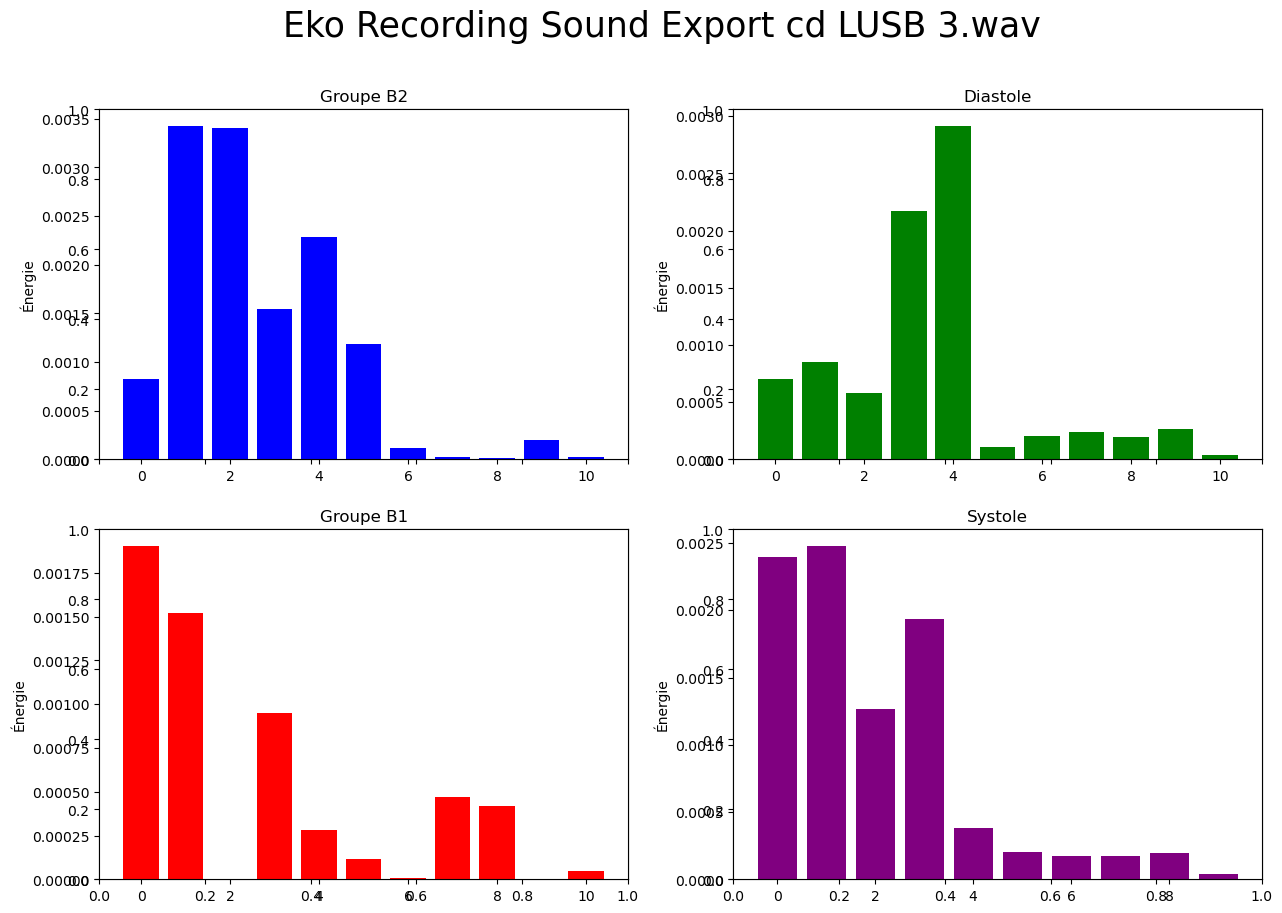

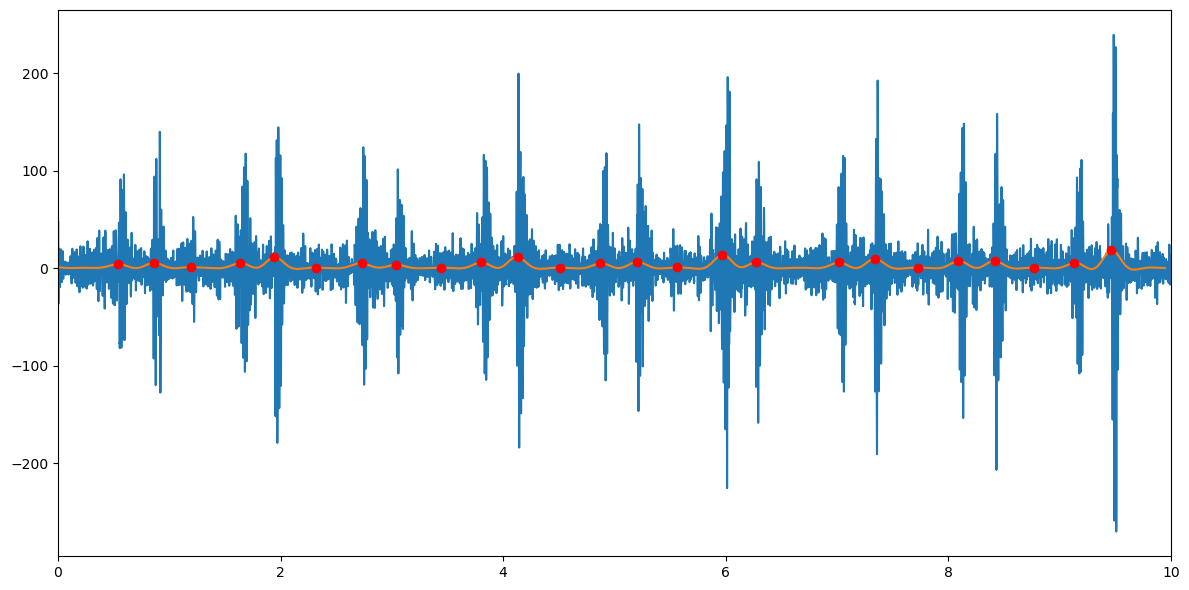

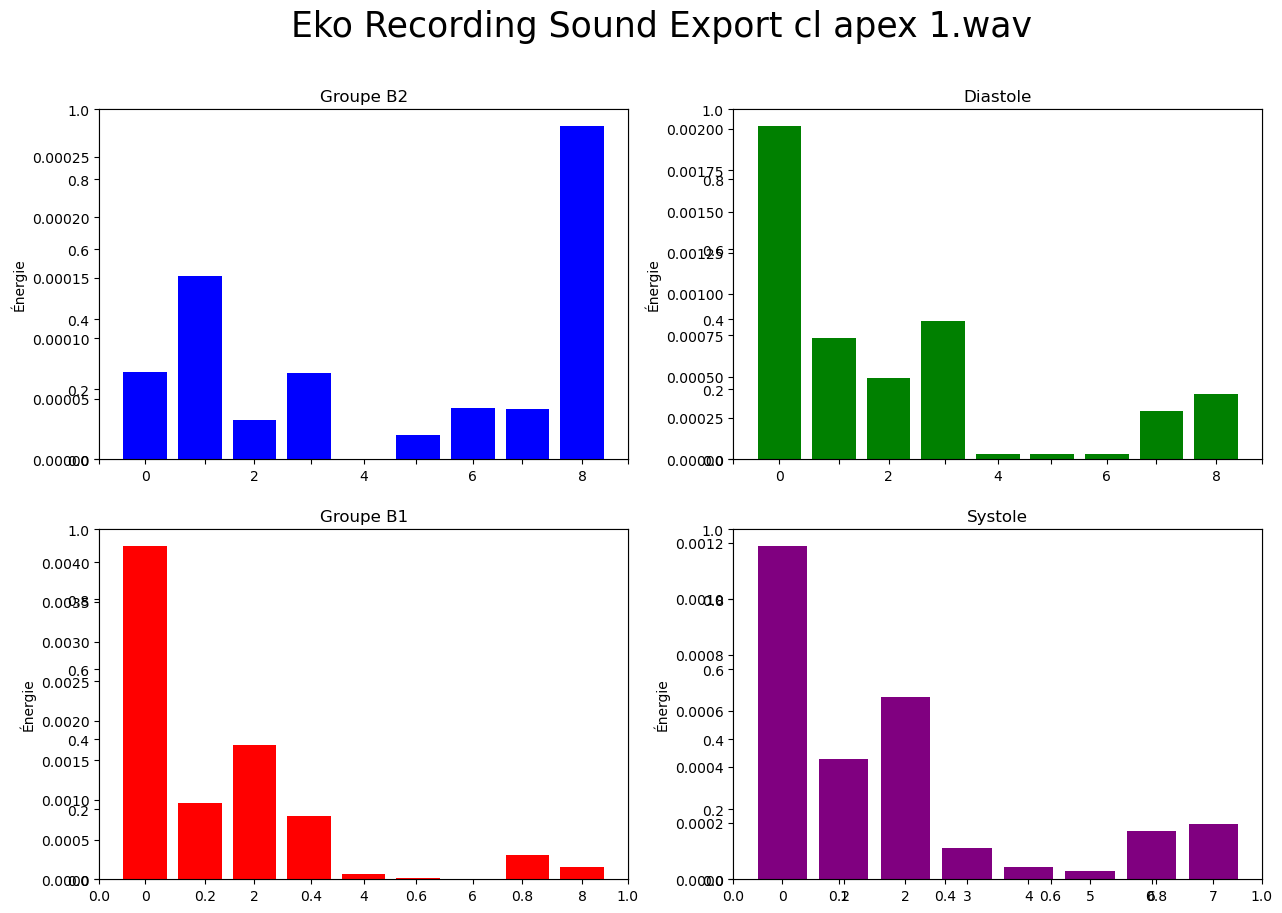

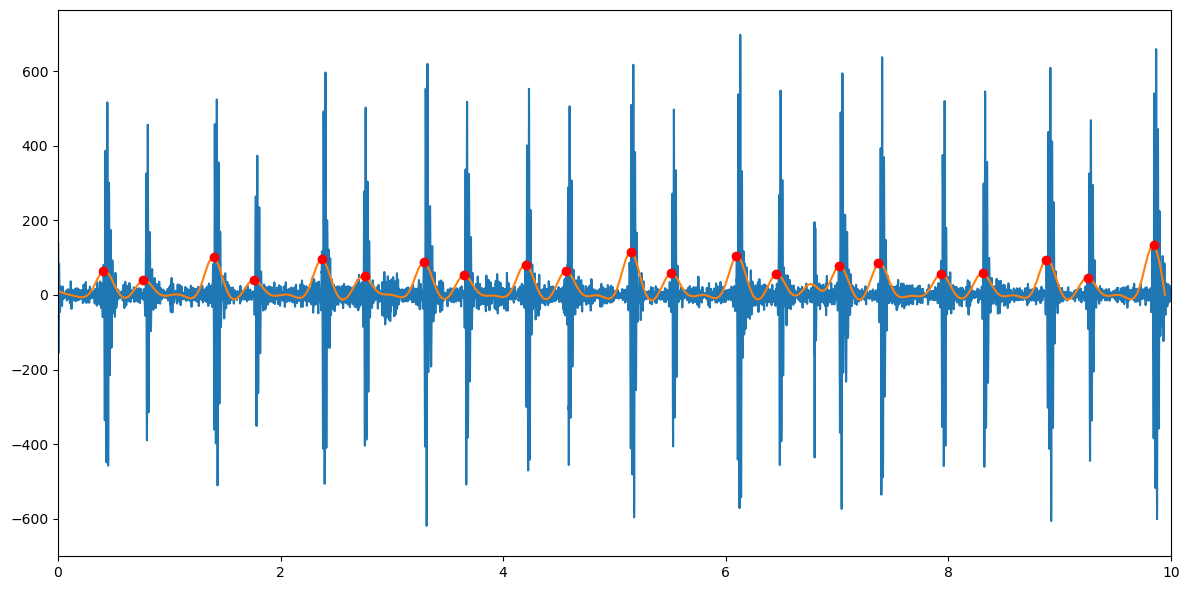

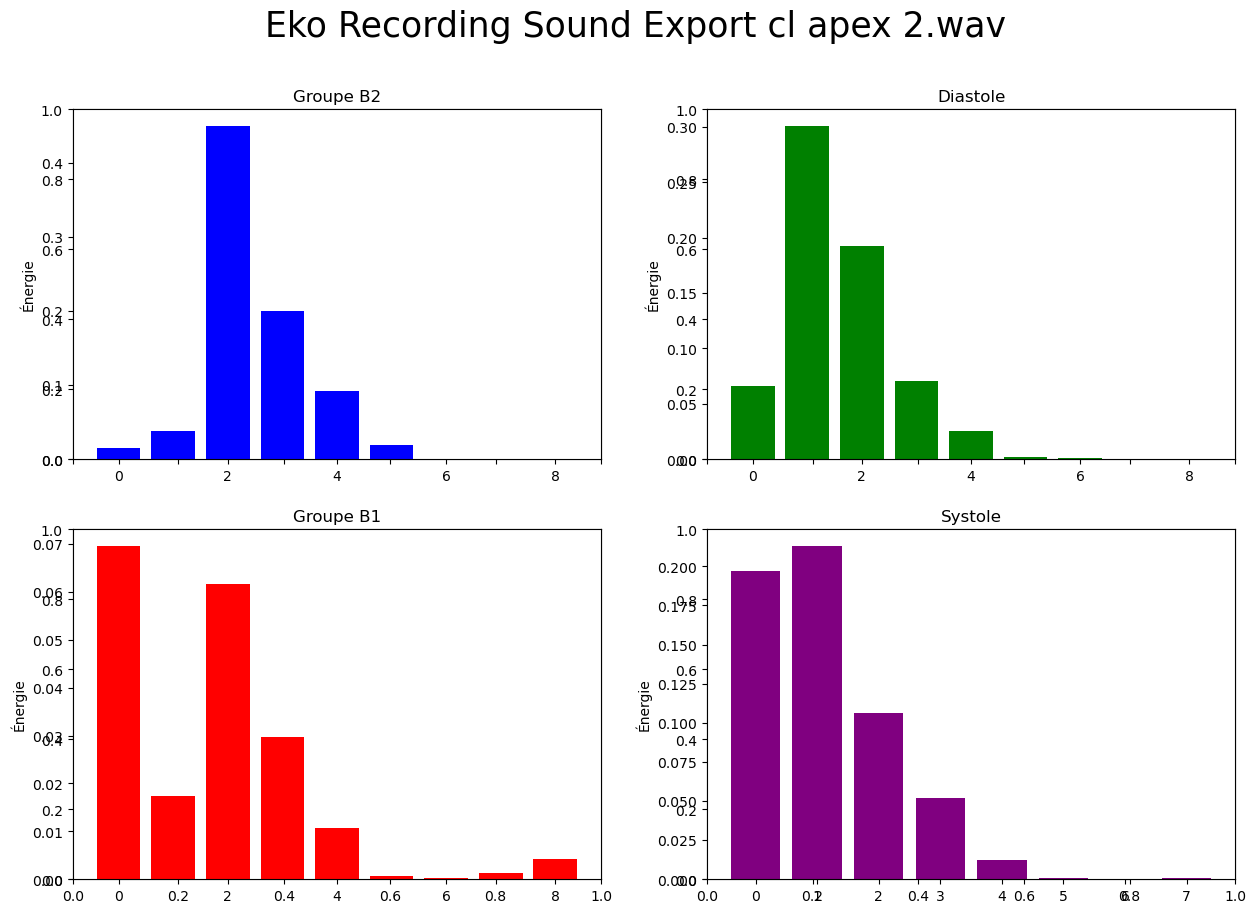

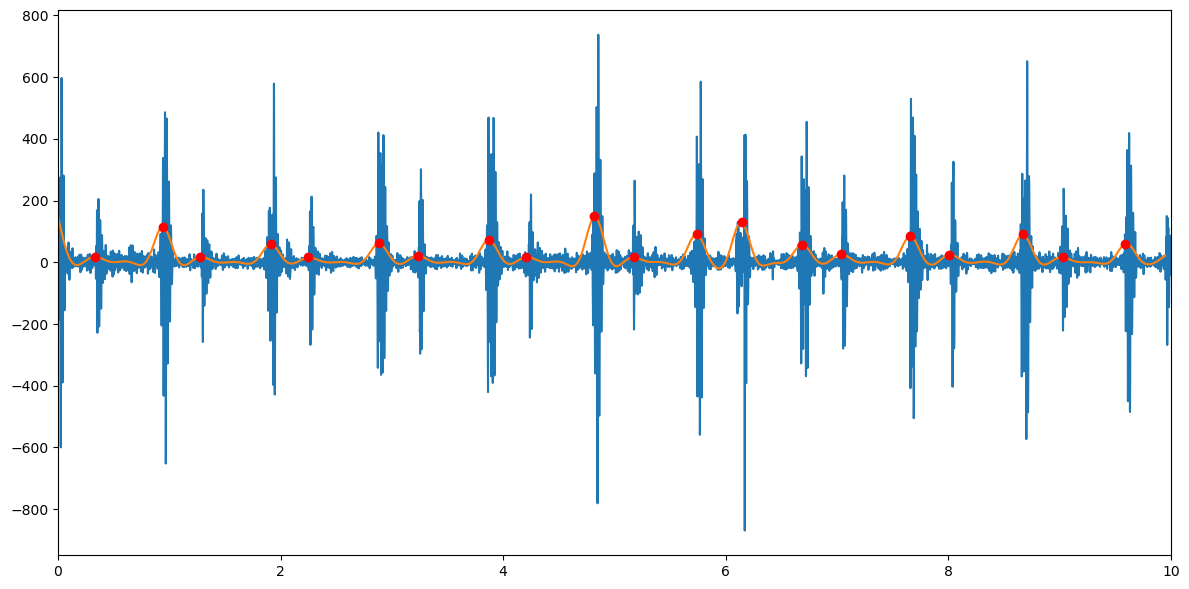

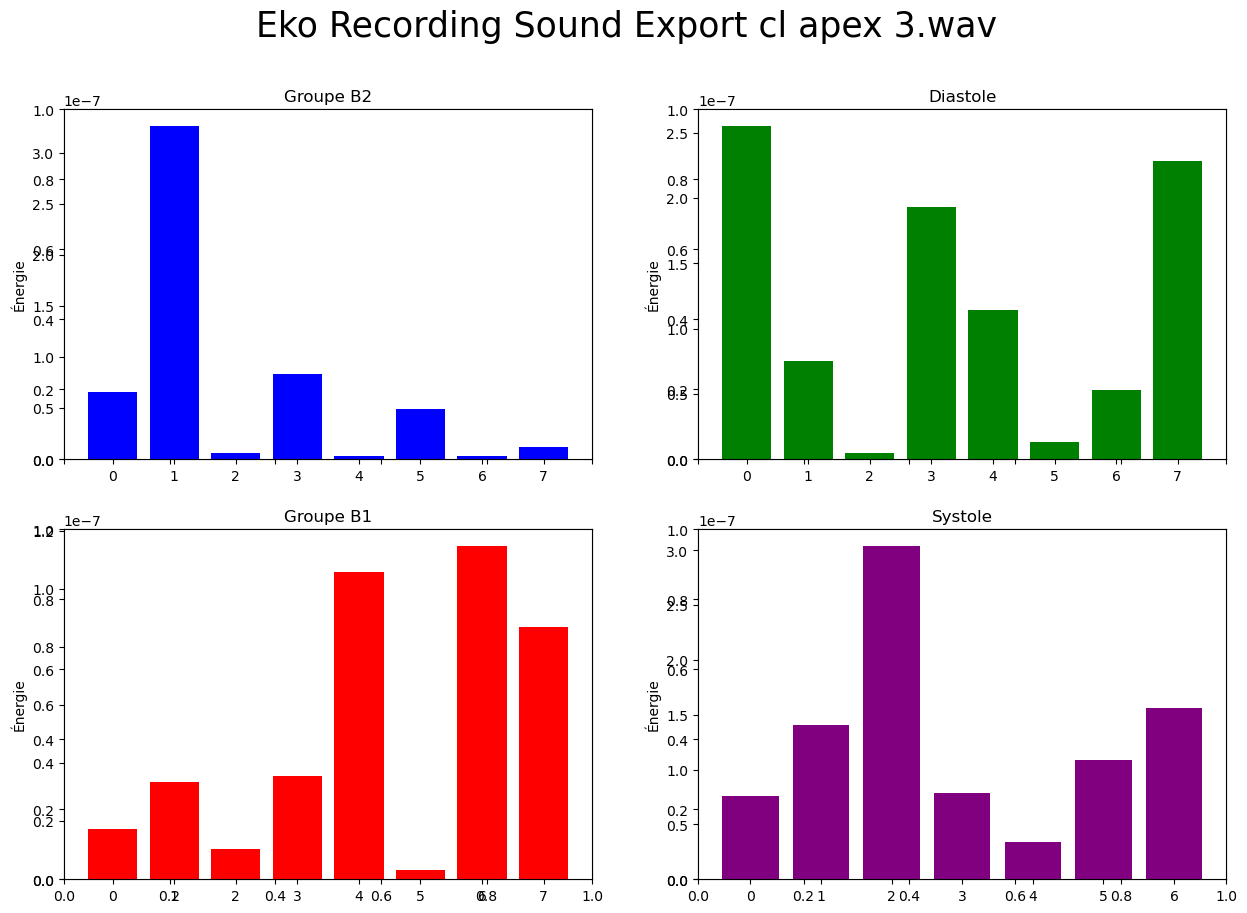

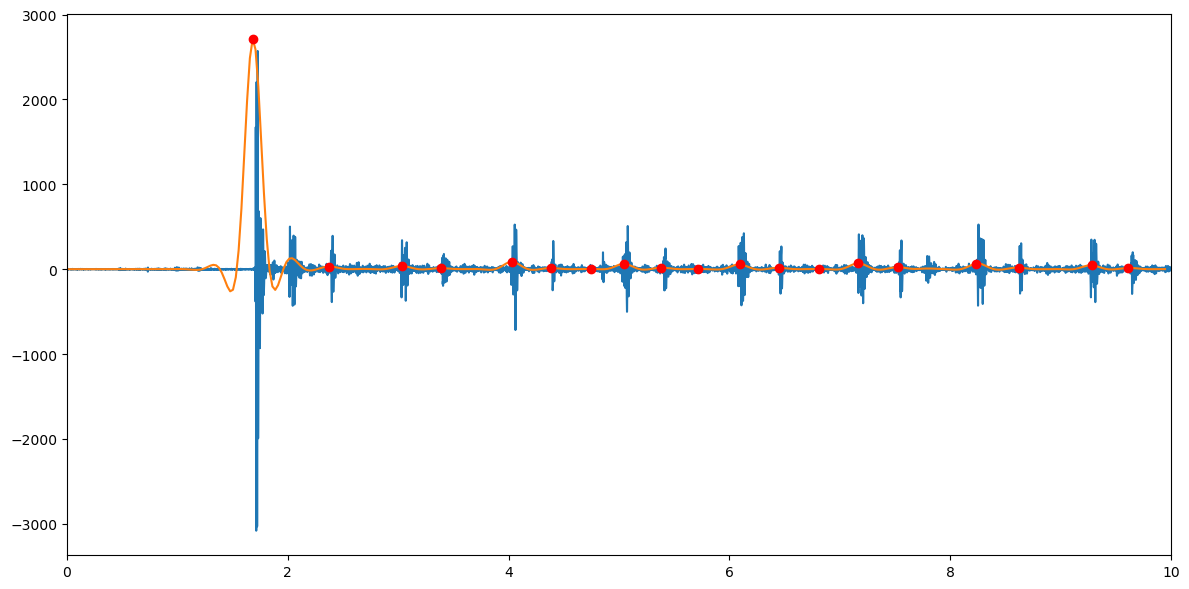

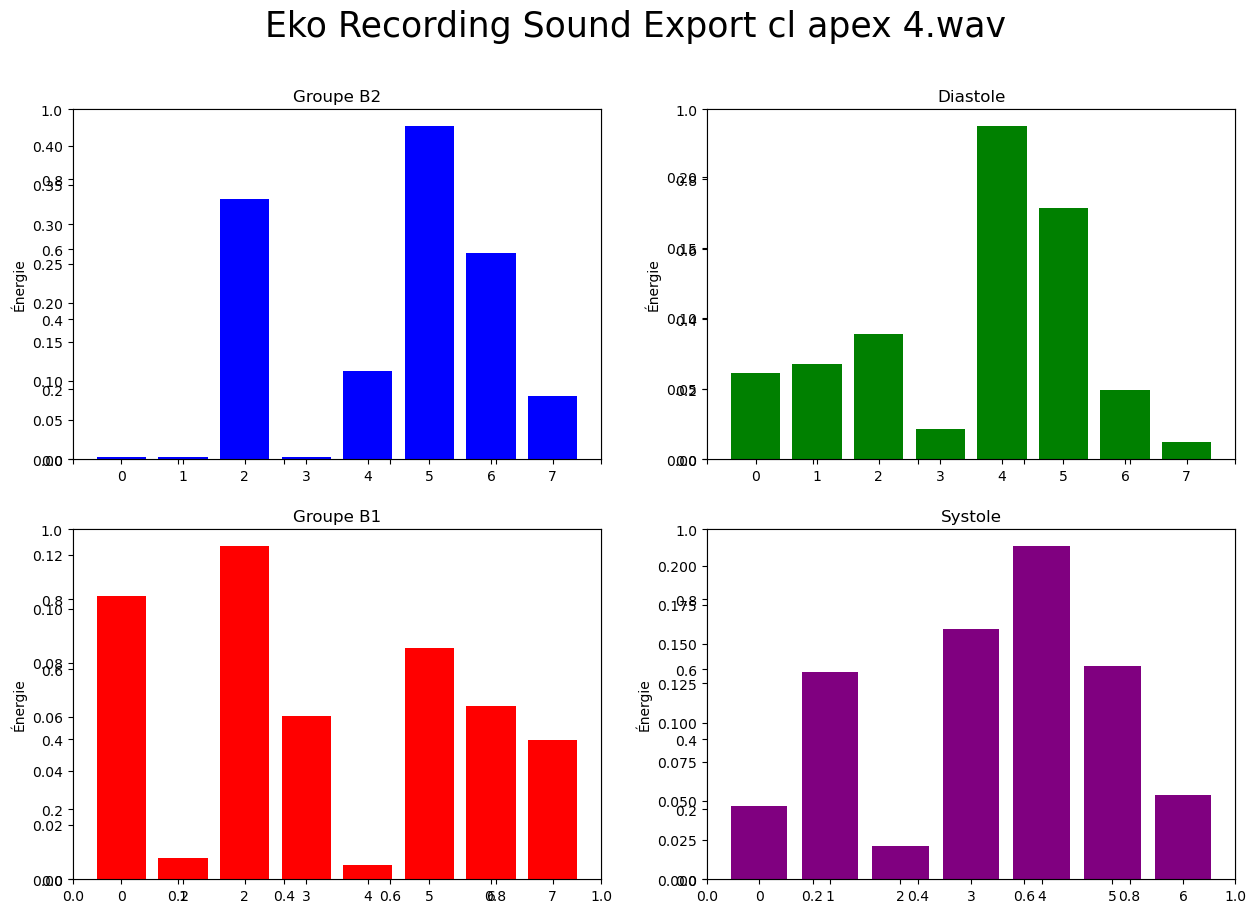

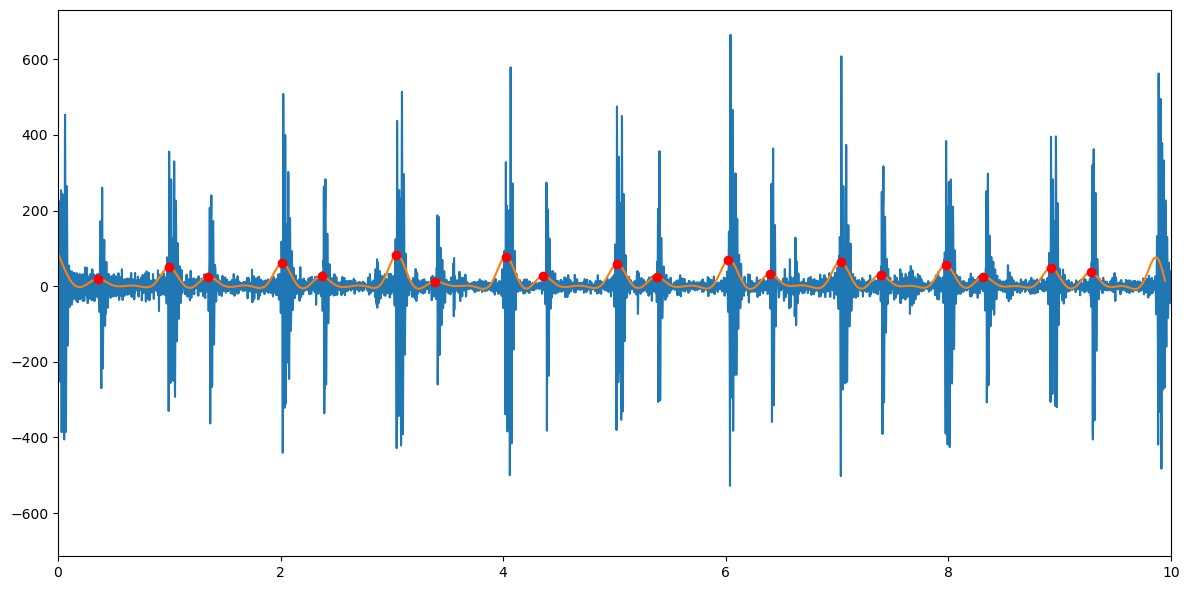

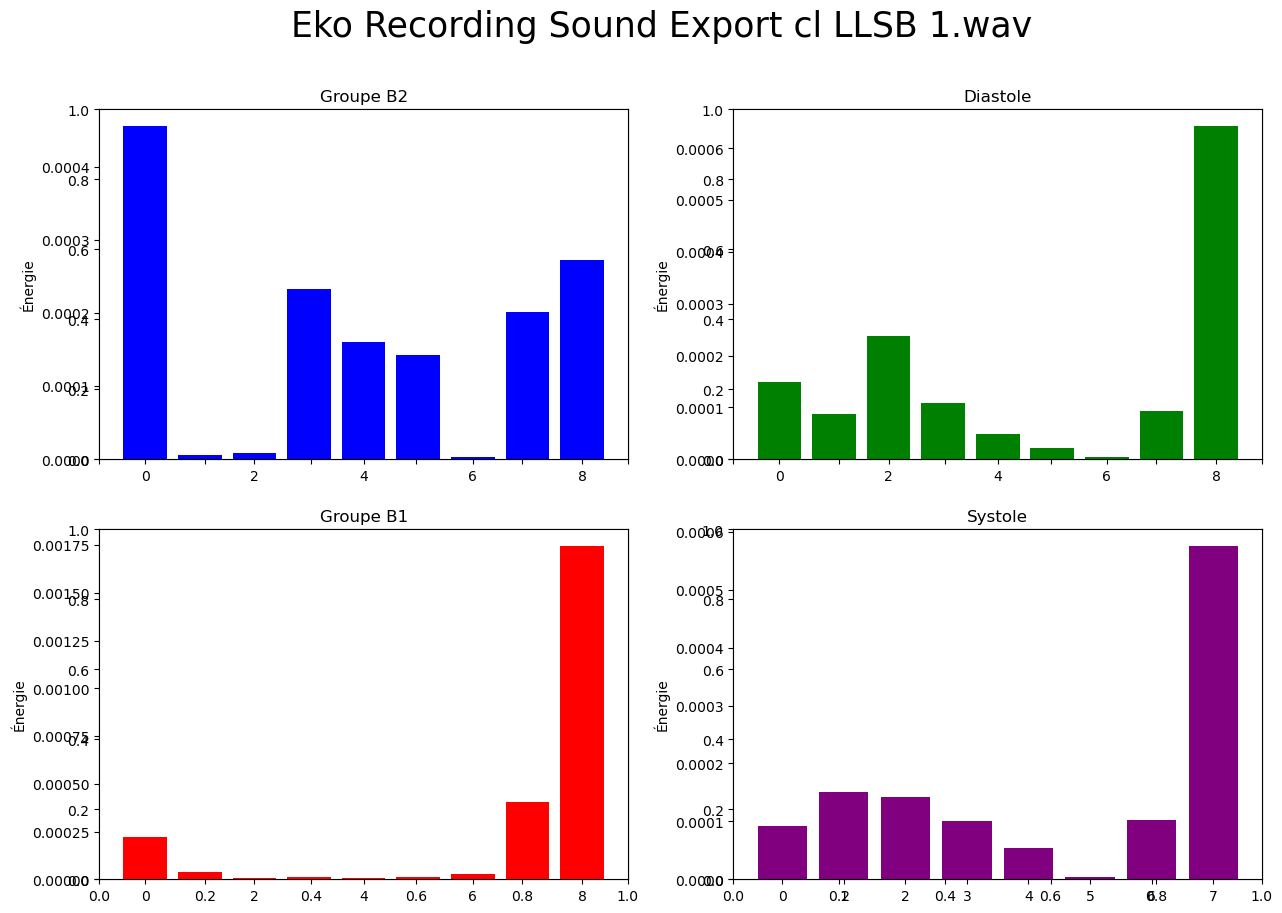

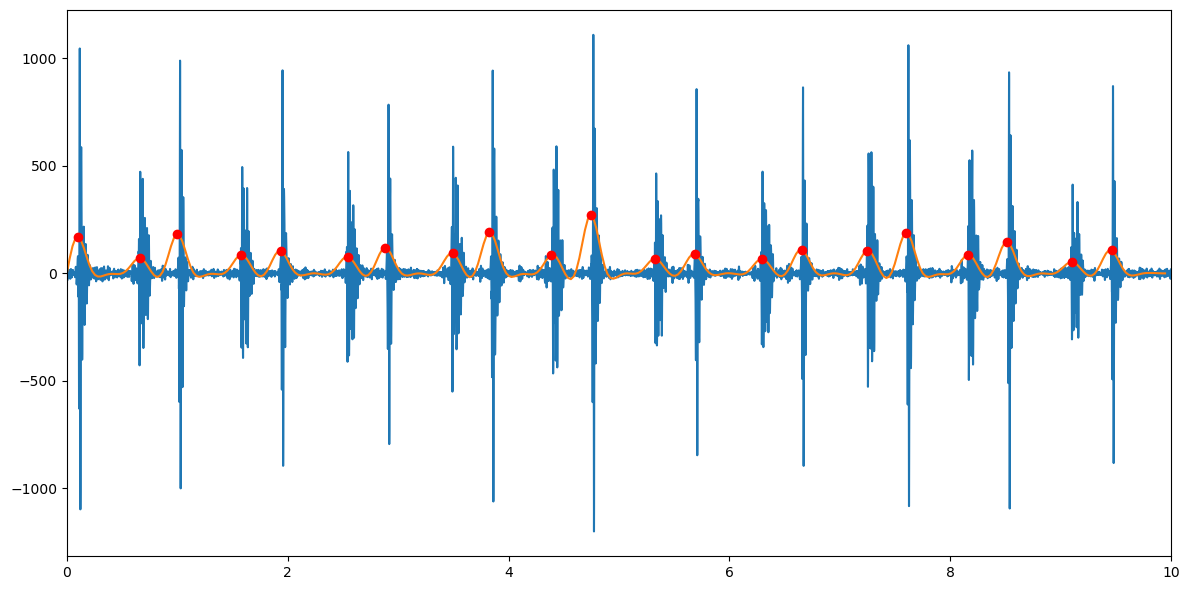

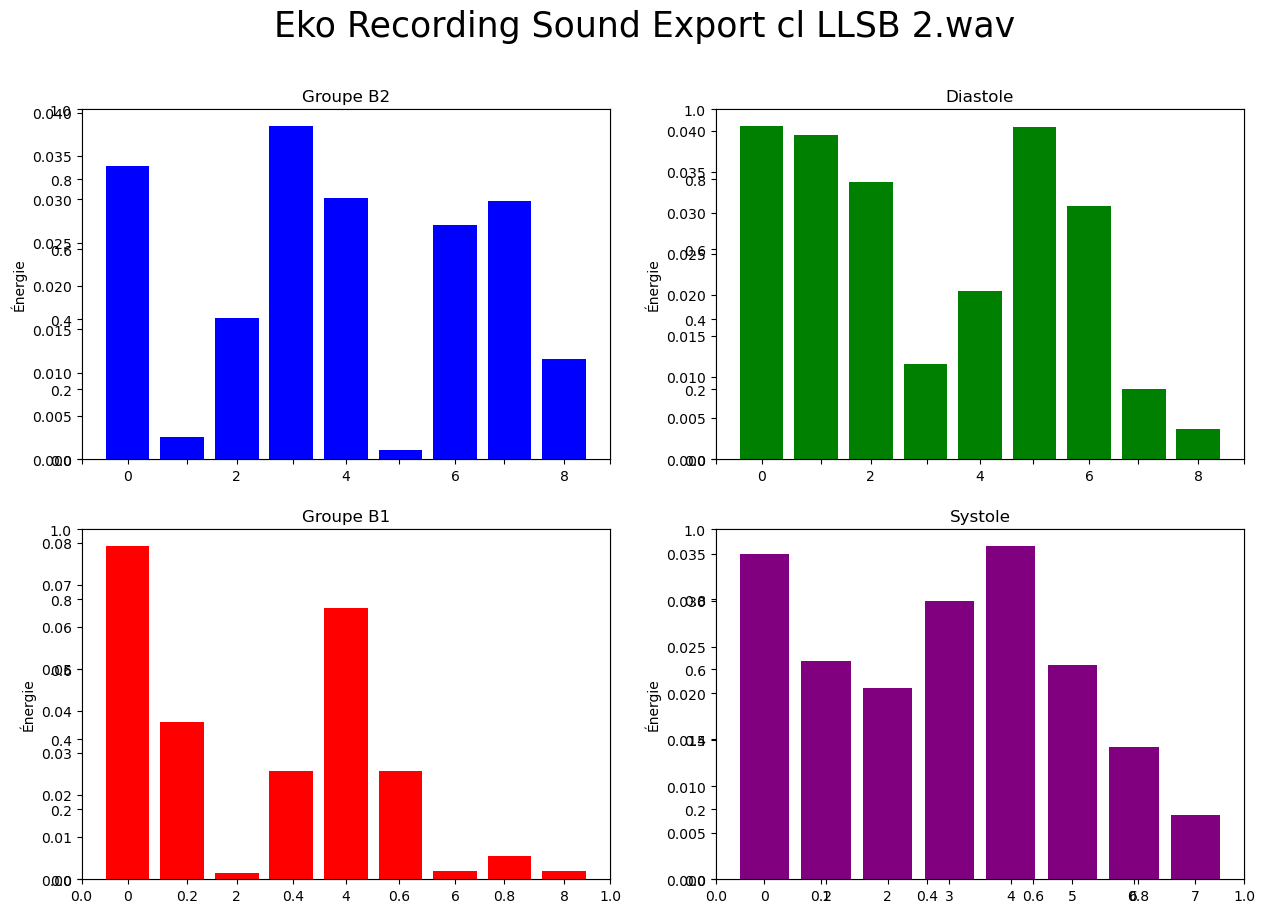

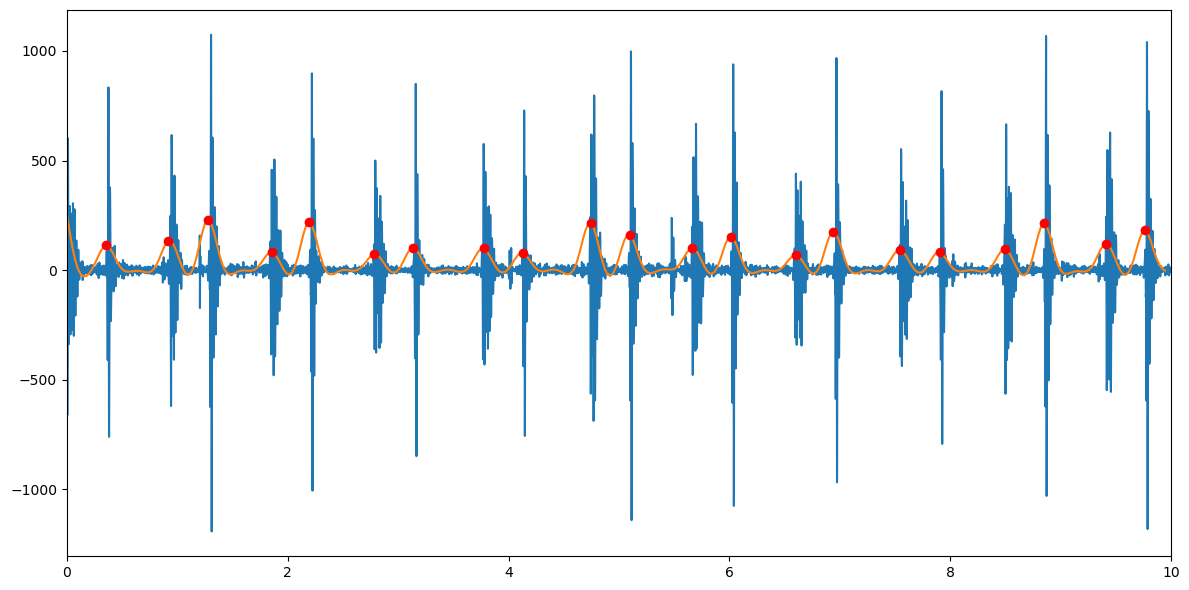

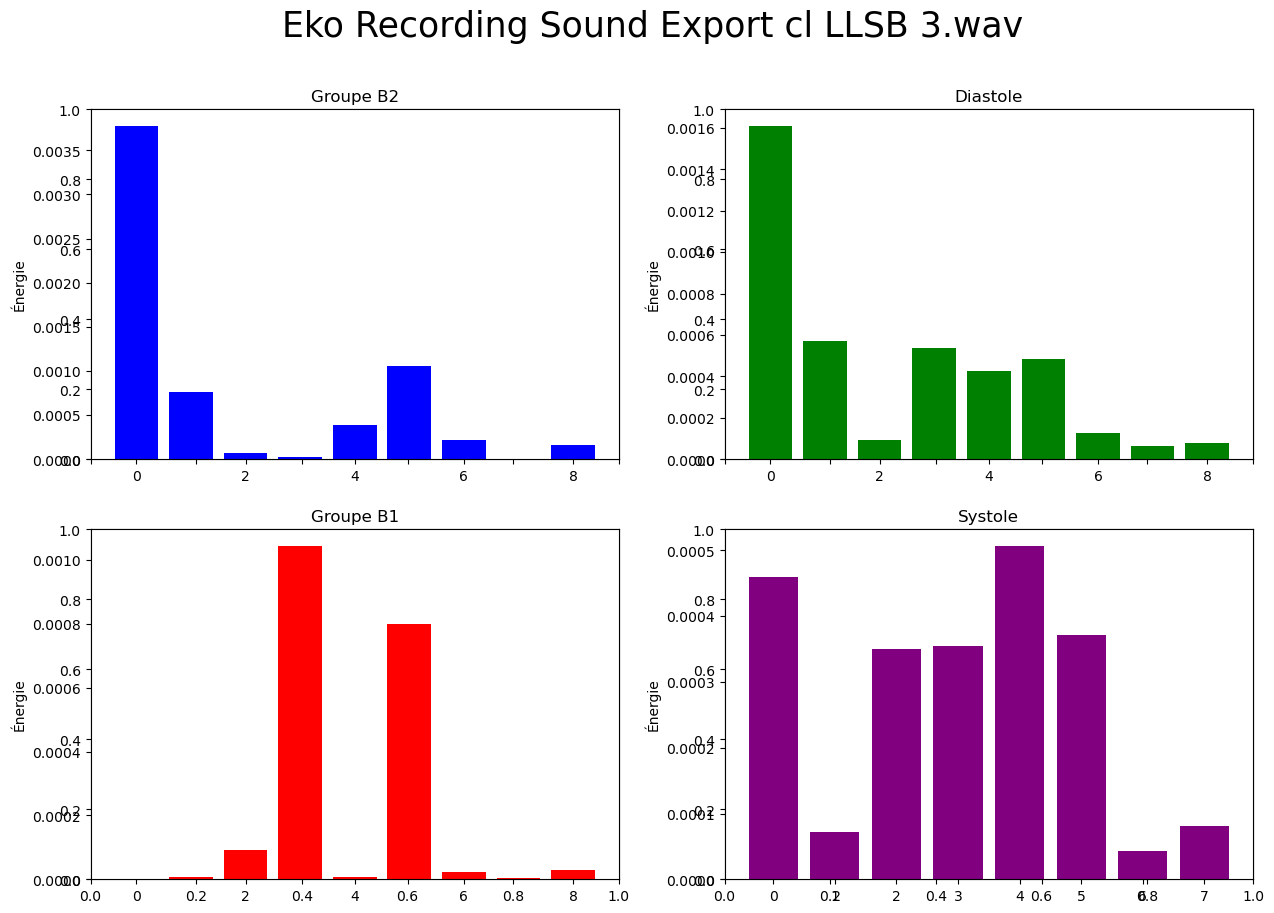

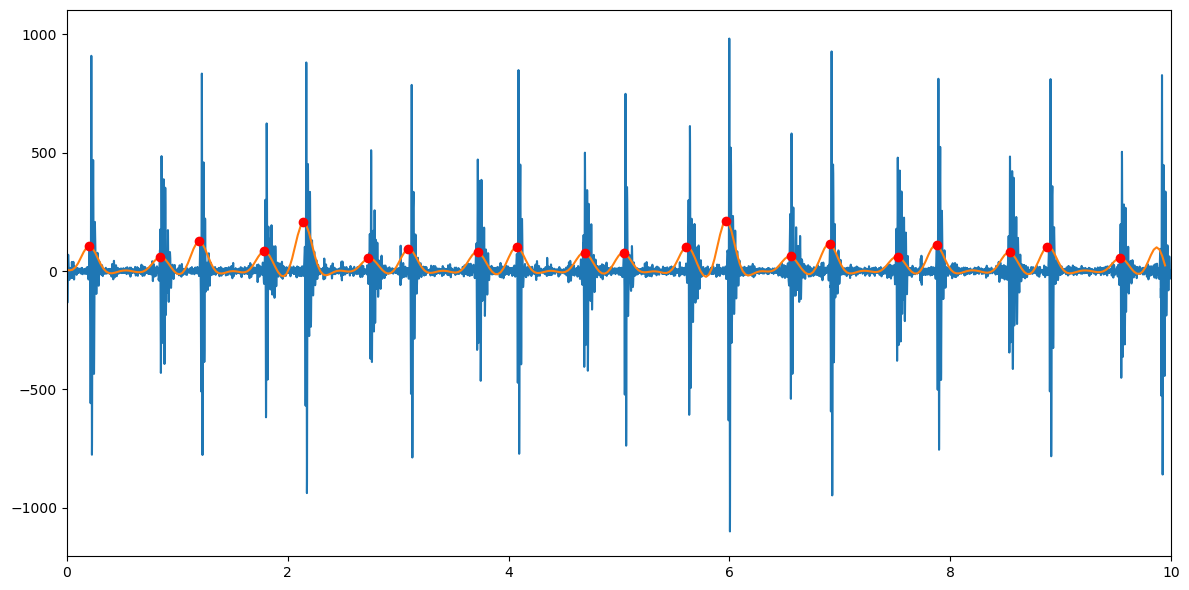

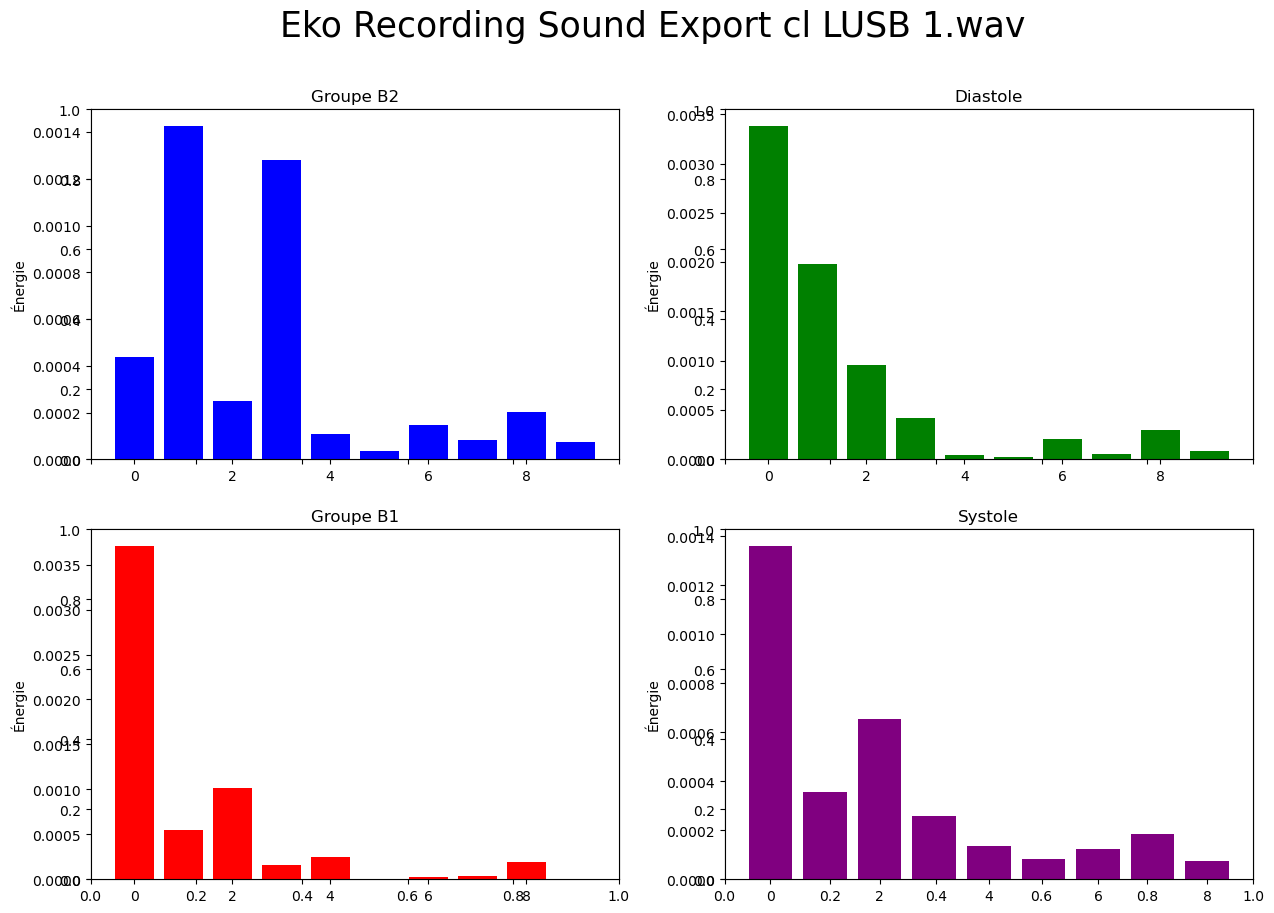

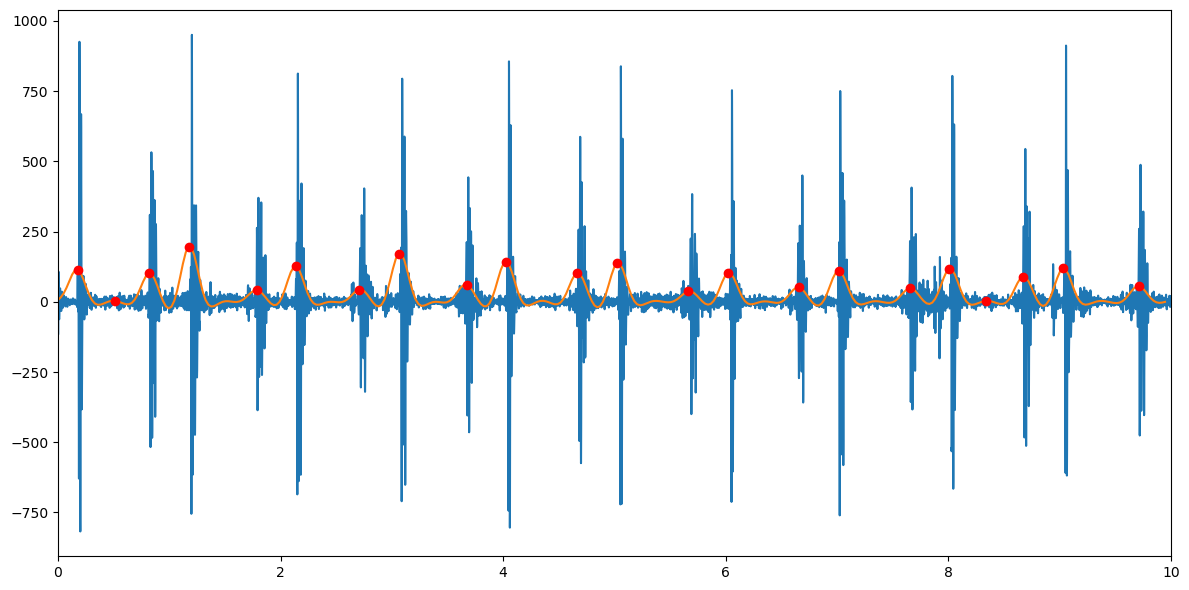

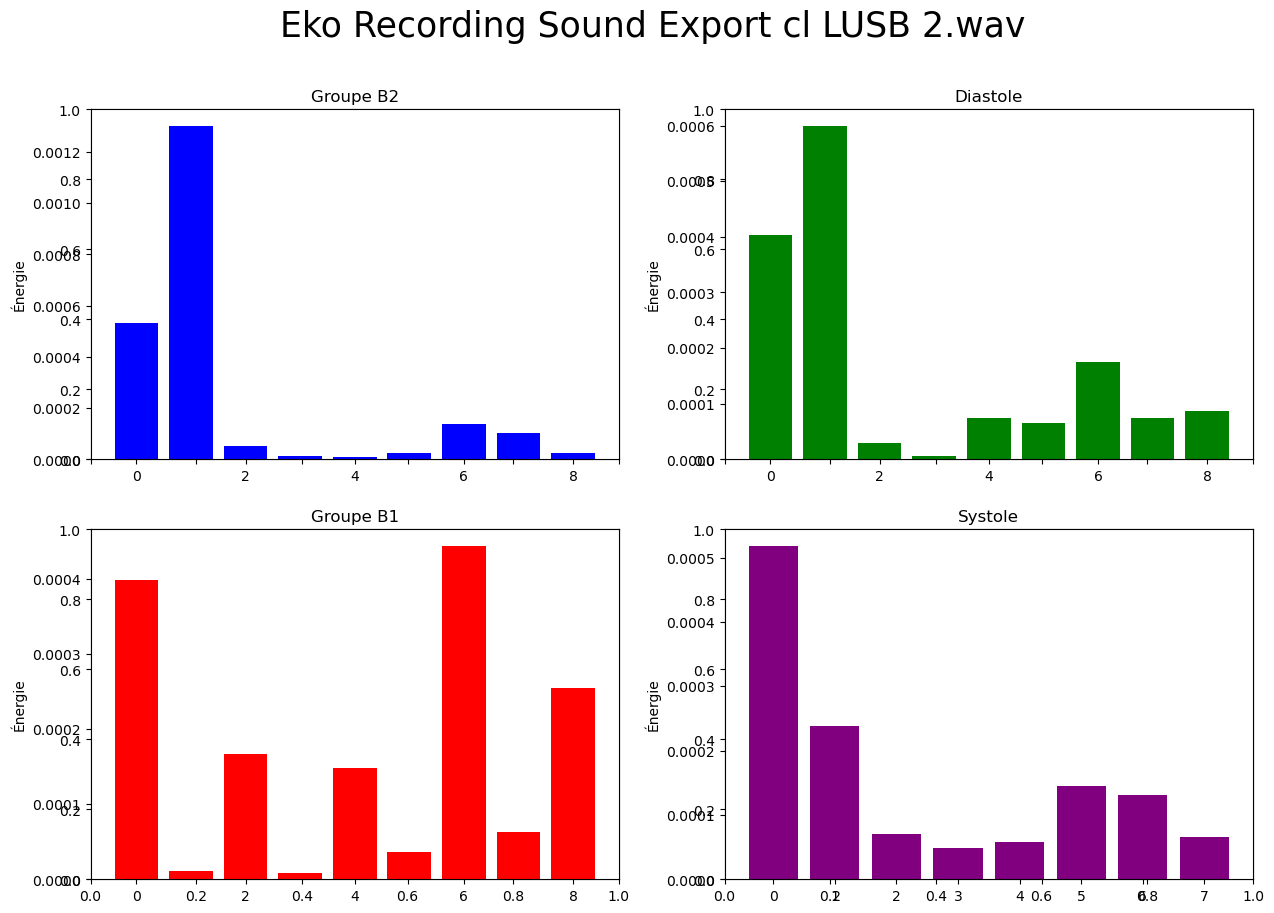

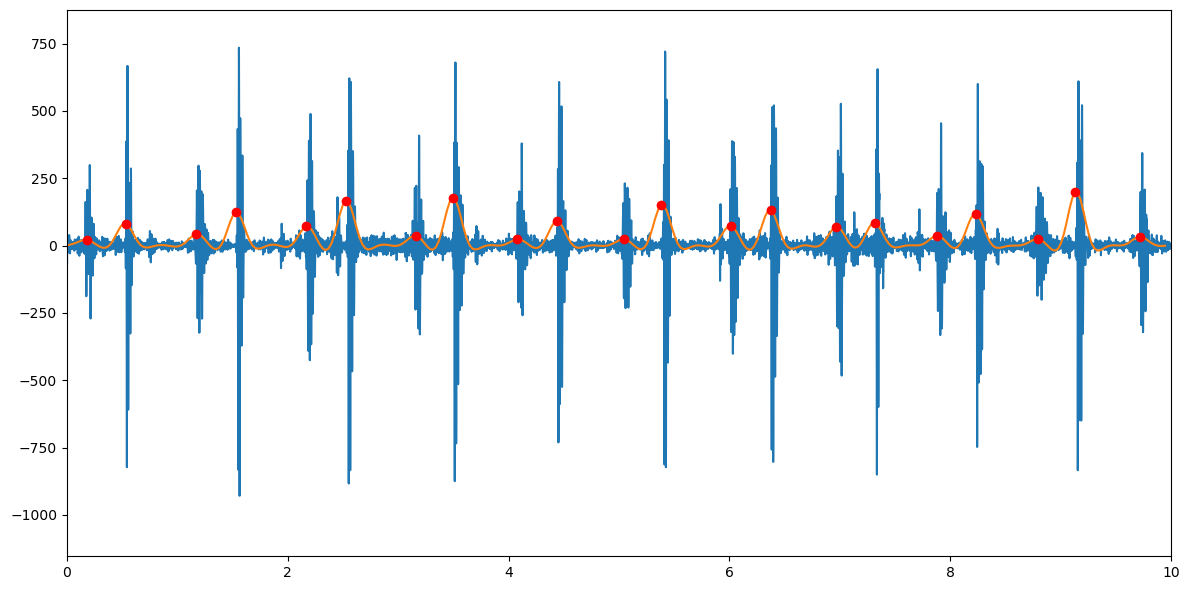

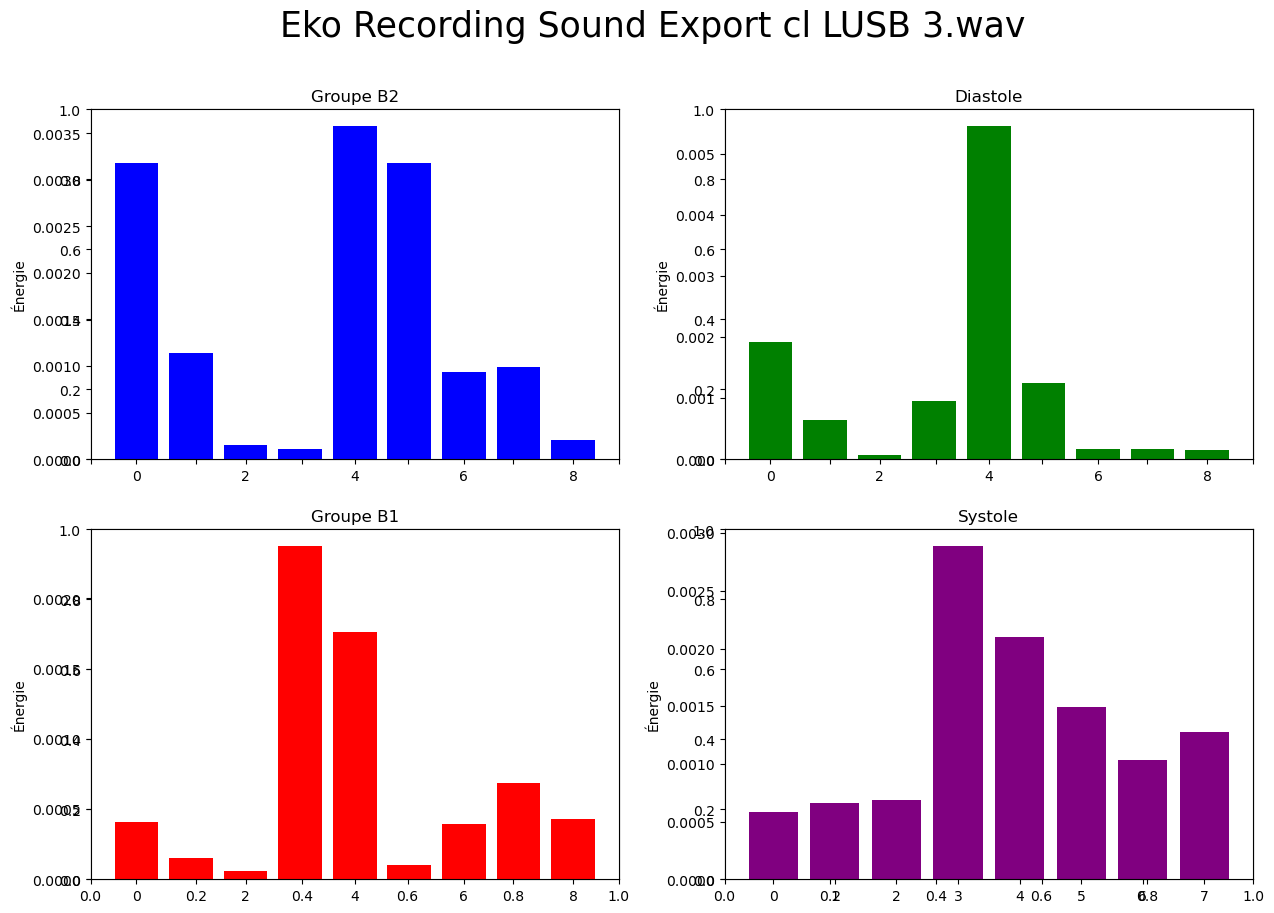

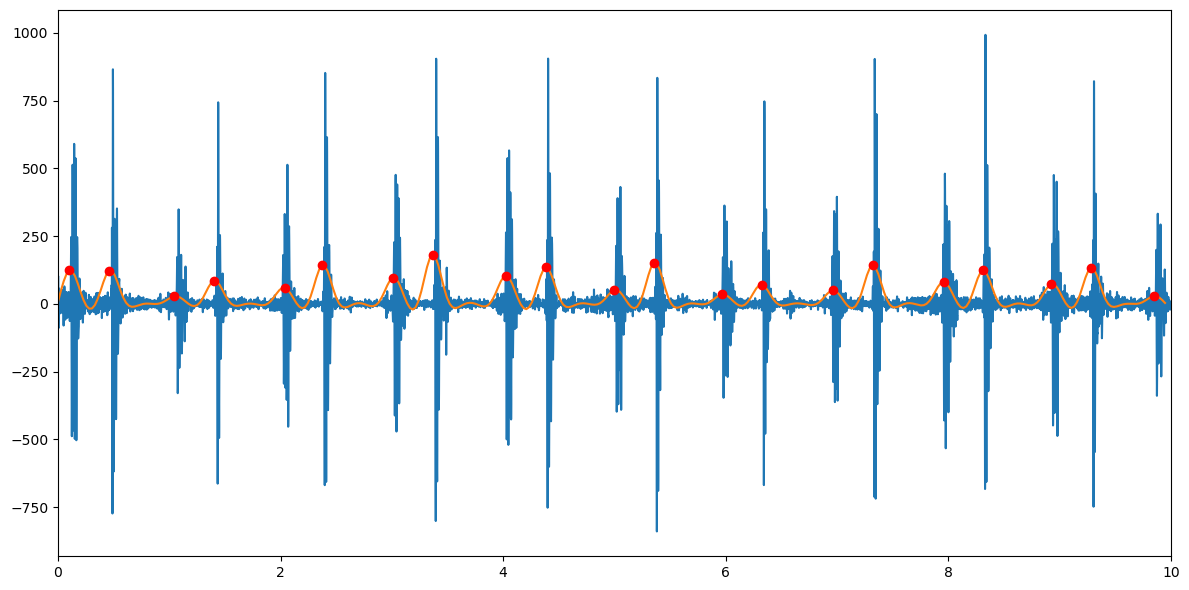

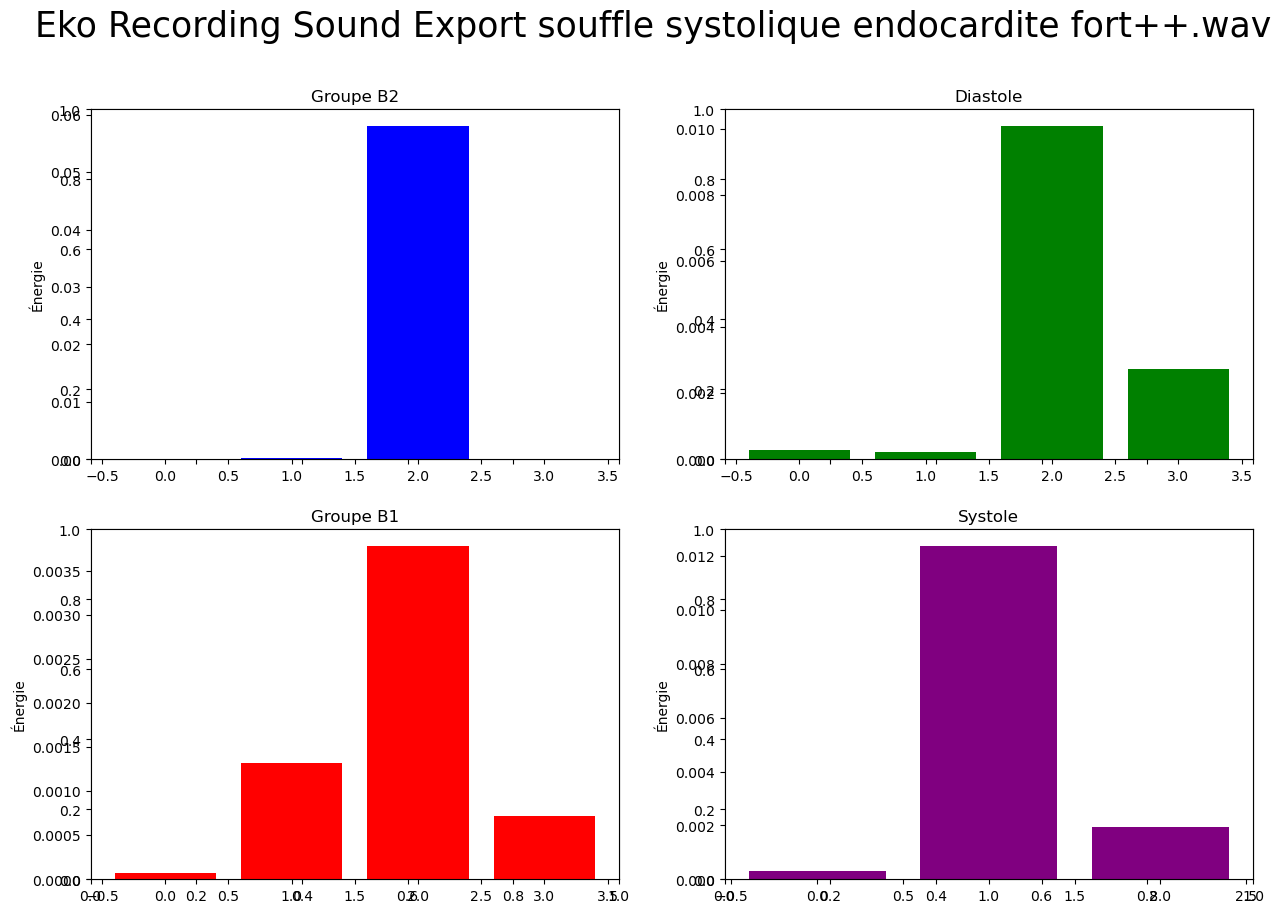

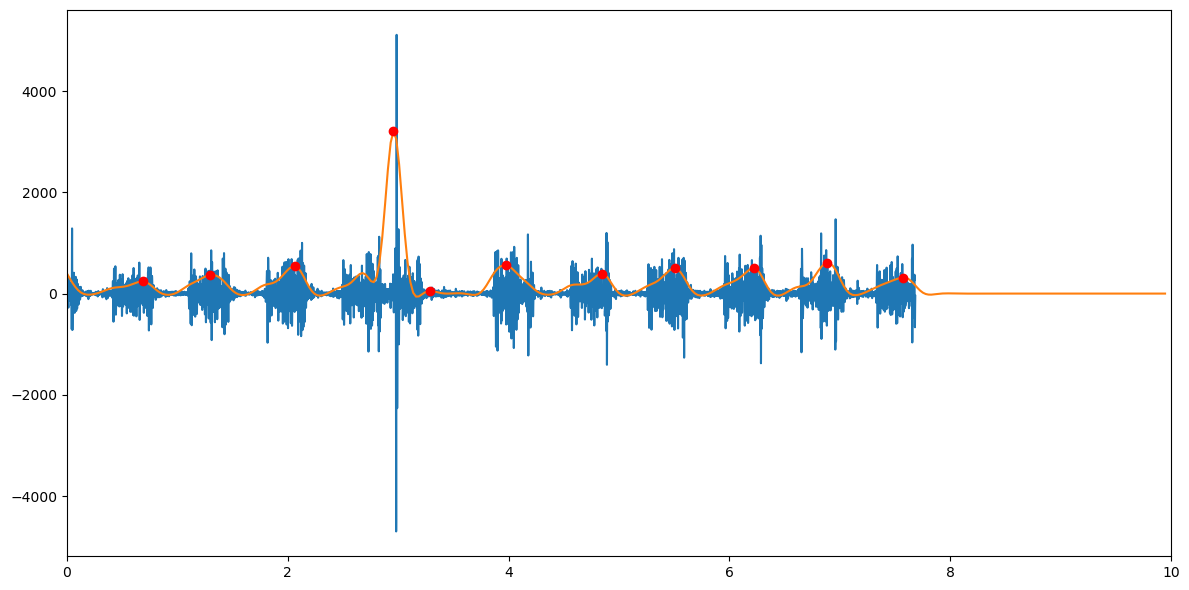

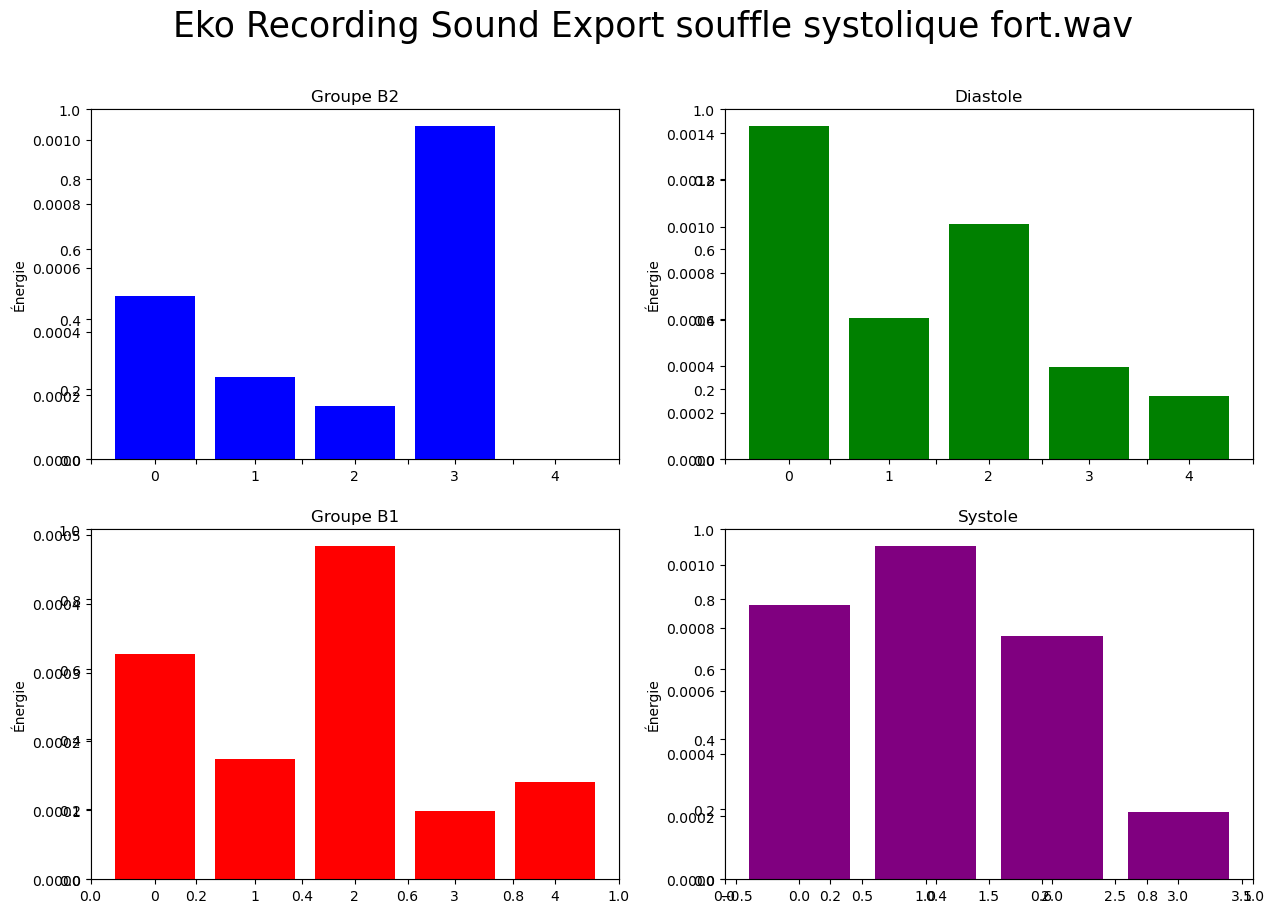

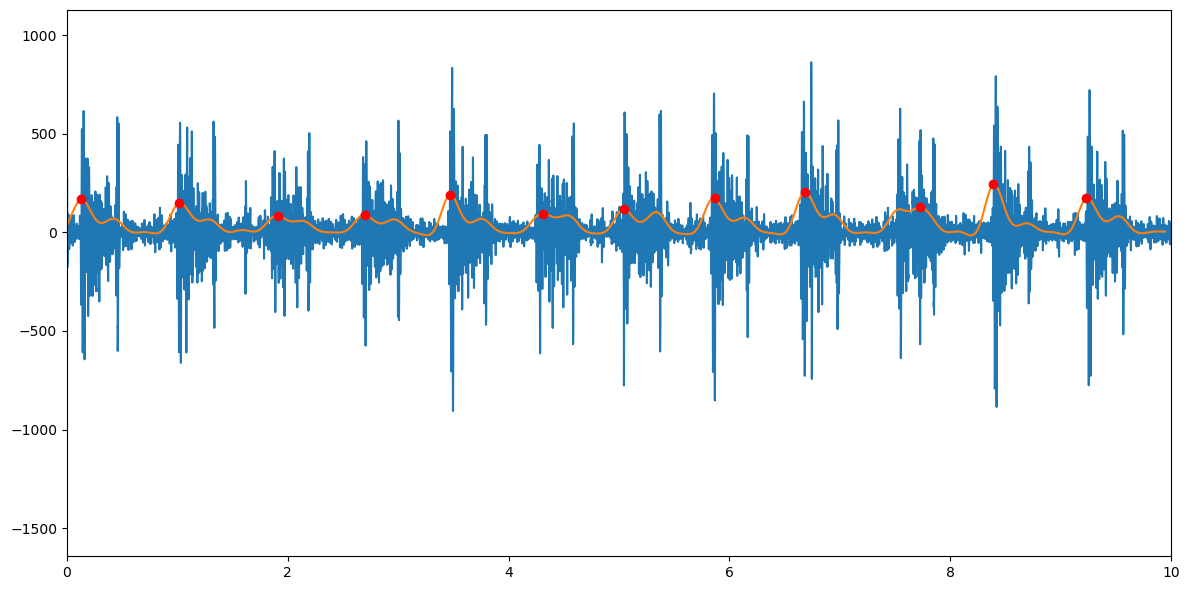

Moyenne Groupe B2 pour tous les patients: 0.013197948666545493
Moyenne Diastole pour tous les patients: 0.011718311670020553
Moyenne Groupe B1 pour tous les patients: 0.009326655417128005
Moyenne Systole pour tous les patients: 0.011957641095927094


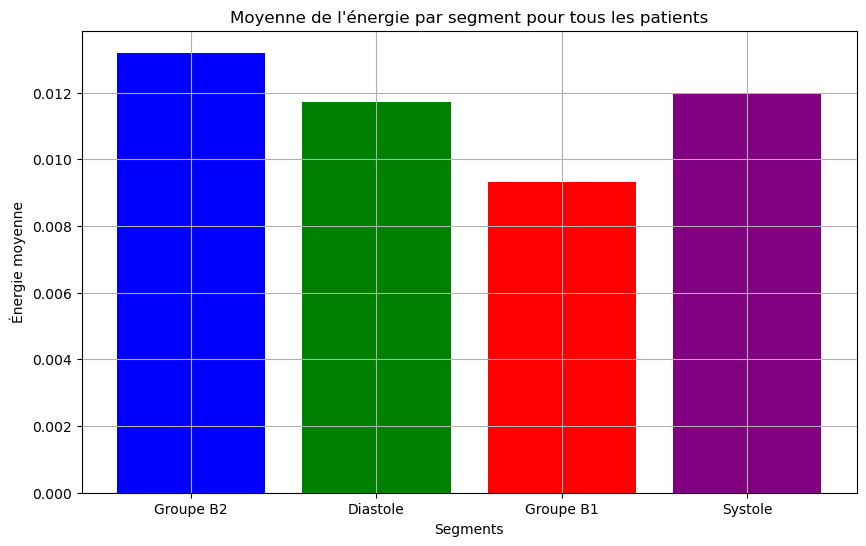

In [13]:
# Chemin du répertoire contenant les fichiers audio
directory = "Records2"

# Initialiser des listes pour stocker les moyennes de chaque segment pour chaque patient
patients_B2 = []
patients_diastole = []
patients_B1 = []
patients_systole = []

# Parcourir tous les fichiers dans le répertoire
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        # Charger le fichier audio WAV
        filepath = os.path.join(directory, filename)
        with wave.open(filepath, 'rb') as wave_file:
            # Obtenir les informations sur le fichier audio
            framerate = wave_file.getframerate()
            frames = wave_file.getnframes()
            channels = wave_file.getnchannels()
            width = wave_file.getsampwidth()

            # Lire les données audio
            audio_data = wave_file.readframes(frames)

            # Convertir les données audio en tableau numpy
            audio_data = np.frombuffer(audio_data, dtype=np.int16)

            # Calculer la durée du signal en secondes
            duration = frames / float(framerate)

            # Créer une séquence temporelle pour le signal
            time = np.linspace(0, duration, frames)

            # Charger le fichier audio WAV
            Fs, y = wav.read(filepath)

            # Vérifier si le fichier audio est stéréo ou mono
            if len(y.shape) == 1:  # Mono
                X = y
            elif len(y.shape) == 2:  # Stéréo
                X = y[:, 0] - 1j * y[:, 1]  # Combinaison en un signal complexe

            Nmax = len(X)
            TotalDuration = Nmax / Fs

            Overlap = 80 / 100
            Lwind = 512
            Delay = round(Lwind - (Lwind * Overlap))
            ED = 10  # EpoqueDuration
            NObs = int(ED * Fs)
            k = 1
            x = X[(k - 1) * NObs:k * NObs]
            tx = np.linspace(0, ED, len(x))

            # Représentation en fréquence
            X = np.fft.fft(audio_data - np.mean(audio_data))
            Xspec_fp = np.abs(X[:len(X) // 2]) ** 2
            fp = np.linspace(0, framerate / 2, len(Xspec_fp))

            # Normalisation (diviser par la valeur maximale absolue)
            normalized_audio_data = audio_data / np.max(np.abs(audio_data))

            # Fonction pour créer un filtre passe-bande Butterworth
            def butter_bandpass(lowcut, highcut, fs, order=5):
                nyquist = 0.5 * fs
                low = lowcut / nyquist
                high = highcut / nyquist
                b, a = butter(order, [low, high], btype='band', analog=False)
                return b, a

            # Fonction pour appliquer le filtre passe-bande Butterworth au signal audio
            def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
                b, a = butter_bandpass(lowcut, highcut, fs, order=order)
                y = filtfilt(b, a, data)
                return y

            # Définition des fréquences de coupure du filtre passe-bande
            lowcut_frequency = 50  # Fréquence de coupure basse en Hz
            highcut_frequency = 1000  # Fréquence de coupure haute en Hz

            # Application du filtre passe-bande au signal audio
            filtered_audio_data_bandpass = butter_bandpass_filter(audio_data, lowcut_frequency, highcut_frequency, framerate)
            
            # Définir la fonction de normalisation
            def normalize_signal(signal):
                max_abs_value = np.max(np.abs(signal))
                normalized_signal = signal / max_abs_value
                return normalized_signal

            # Appliquer la normalisation au signal filtré
            normalized_audio_data_bandpass = normalize_signal(filtered_audio_data_bandpass)

            EpoqueDuration = Lwind / Fs

            # Réduire la longueur de la fenêtre de Hamming
            Lwind = 128  # Par exemple, réduire la longueur de la fenêtre de Hamming à 128

            # Augmenter la longueur de la transformée de Fourier
            NFFT = 2048  # Par exemple, augmenter la longueur de la transformée de Fourier à 2048

            # Diminuer le taux de recouvrement
            Overlap = 50 / 100  # Par exemple, réduire le taux de recouvrement à 50%

            # Affichage de l'énergie par époque avec les nouvelles modifications
            Energy = []

            l = 1

            while (l - 1) * Delay + Lwind < NObs:
                x_wind = filtered_audio_data_bandpass[(l - 1) * Delay:l * Delay + Lwind]
                S = np.abs(np.fft.fft(x_wind, NFFT))
                FrpPos = np.arange(len(S) // 2)
                Energy.append([np.sum((S[FrpPos] * hamming(len(FrpPos))) ** 2) / len(FrpPos)])
                l += 1

            Energy = np.array(Energy)
            Sgl = Energy[:, 0]
            tx = np.linspace(0, EpoqueDuration, len(Sgl))

            # Correction de l'axe des temps
            epoch_times = np.arange(len(Sgl)) * (Delay / Fs)

            # Définition des paramètres du filtre passe-bas
            order = 3  # Ordre du filtre
            cutoff_freq = 0.09  # Fréquence de coupure du filtre (en Hz)

            # Création du filtre passe-bas
            b, a = butter(order, cutoff_freq, fs=1)

            # Application du filtre passe-bas à l'énergie par époque pour lisser le signal
            smoothed_energy = filtfilt(b, a, Sgl)

            # Trouver tous les pics initiaux pour analyser les amplitudes
            initial_peaks, _ = find_peaks(smoothed_energy)

            # Si au moins deux pics sont trouvés
            if len(initial_peaks) > 1:
                # Obtenir les valeurs des pics trouvés
                peak_values = smoothed_energy[initial_peaks]
                # Trouver l'indice du plus grand pic
                max_peak_index = np.argmax(peak_values)
                # Supprimer le plus grand pic pour obtenir le deuxième plus grand
                peak_values = np.delete(peak_values, max_peak_index)
                # Trouver la valeur du deuxième plus grand pic
                second_max_peak = np.max(peak_values)
            else:
                # Si moins de deux pics, utiliser le maximum existant pour éviter les erreurs
                second_max_peak = np.max(smoothed_energy)

            # Définir height comme une fraction du deuxième plus grand pic
            height_threshold = second_max_peak / 70

            # Définir d'autres paramètres de manière adaptative
            distance = len(smoothed_energy) // 50  # Vous pouvez ajuster ce facteur selon le signal
            prominence = (np.percentile(smoothed_energy, 50) - np.percentile(smoothed_energy, 25))  # Utilisation de l'IQR comme estimation de la prominence
            width = 5  # Valeur de largeur minimale (peut être ajustée)

            # Trouver les pics avec les paramètres calculés
            peaks, properties = find_peaks(smoothed_energy, distance=distance, height=height_threshold, prominence=prominence, width=width)
            # Recherche des indices des pics correspondant à la distance minimale
            distances = []

            for i in range(len(peaks) - 1):
                distance_time = epoch_times[peaks[i+1]] - epoch_times[peaks[i]]
                distances.append(distance_time)

            # Add debug prints
            if not distances:
                print(f"No distances found for file: {filename}")
                continue 

            distance_min = min(distances)

            # Handle floating-point precision
            min_distance_index = next((i for i, d in enumerate(distances) if math.isclose(d, distance_min)), None)

            if min_distance_index is None:
                raise ValueError(f"Min distance {distance_min} not found in distances list")
                continue  # Skip to the next file
            pic_B1_index = peaks[min_distance_index]
            pic_B2_index = peaks[min_distance_index + 1]

            # Définir des listes pour stocker les pics B1 et B2
            peaks_B1 = []
            peaks_B2 = []

            # Itérer sur les indices des pics B1 et B2
            for i in range(1, len(peaks)):
                if i % 2 == 0:
                    # Si l'indice est pair, ajouter à la liste des pics B2
                    peaks_B2.append(peaks[i])
                else:
                    # Sinon, ajouter à la liste des pics B1
                    peaks_B1.append(peaks[i])

            # Vérifier si le deuxième pic de la liste globale est égal au premier pic de B1 ou B2
            if peaks[1] == peaks_B1[0]:
                peaks_B2.append(peaks[0])
            elif peaks[1] == peaks_B2[0]:
                peaks_B1.append(peaks[0])

            # Trier les listes des pics B1 et B2 par ordre croissant
            peaks_B1.sort()
            peaks_B2.sort()

            distances_B1 = []

            # Calcul des distances entre chaque paire de pics B1 consécutifs
            for i in range(len(peaks_B1) - 1):
                distance_B1 = epoch_times[peaks_B1[i+1]] - epoch_times[peaks_B1[i]]
                distances_B1.append(distance_B1)

            # Calcul de la moyenne des distances
            moyenne_distance_B1 = sum(distances_B1) / len(distances_B1)

            # Calcul de 10% de cette moyenne pour obtenir le seuil
            marge_erreur = int(moyenne_distance_B1 * 0.10) + 1  # Définir la marge d'erreur

            # Enregistrement des points B1 avec marges d'erreur
            points_B1 = []
            for pic_B1 in peaks_B1:
                points_B1.extend(range(pic_B1 - marge_erreur, pic_B1 + marge_erreur + 1))

            # Enregistrement des points B2 avec marges d'erreur
            points_B2 = []
            for pic_B2 in peaks_B2:
                points_B2.extend(range(pic_B2 - marge_erreur, pic_B2 + marge_erreur + 1))

            # Trier et supprimer les doublons
            points_B1 = sorted(set(points_B1))
            points_B2 = sorted(set(points_B2))

            # Fonction pour regrouper les indices consécutifs
            def regrouper_indices(indices):
                groups = []
                temp_group = [indices[0]]
                for i in range(1, len(indices)):
                    if indices[i] - indices[i-1] == 1:
                        temp_group.append(indices[i])
                    else:
                        groups.append(temp_group)
                        temp_group = [indices[i]]
                groups.append(temp_group)
                return groups

            # Enregistrement des points B1 avec marges d'erreur et le nombre de positions qu'ils comprennent
            points_B1_groupes = regrouper_indices(points_B1)
            # Enregistrement des points B2 avec marges d'erreur et le nombre de positions qu'ils comprennent
            points_B2_groupes = regrouper_indices(points_B2)

            # Initialisation des listes pour stocker les valeurs moyennes
            B2 = []
            diastole = []
            B1 = []
            systole = []

            # Itérer sur les groupes B1 et B2
            for i in range(len(points_B1_groupes)):
                # Extraire les indices de début et de fin pour chaque groupe B1 et B2
                start_B1 = points_B1_groupes[i][0]
                end_B1 = points_B1_groupes[i][-1]
                start_B2 = points_B2_groupes[i][0]
                end_B2 = points_B2_groupes[i][-1]

                # Calculer la moyenne de chaque point élevé au carré pour chaque segment
                mean_squared_B2 = np.mean(normalized_audio_data_bandpass[start_B2:end_B2+1] ** 2)
                mean_squared_diastole = np.mean(normalized_audio_data_bandpass[end_B2+1:start_B1] ** 2)
                mean_squared_B1 = np.mean(normalized_audio_data_bandpass[start_B1:end_B1+1] ** 2)

                # Vérifier si ce n'est pas la dernière itération
                if i != len(points_B1_groupes) - 1:
                    mean_squared_systole = np.mean(normalized_audio_data_bandpass[end_B1+1:points_B1_groupes[i+1][0]] ** 2)
                else:
                    # Si c'est la dernière itération, définir la valeur de mean_squared_systole à 0
                    mean_squared_systole = 0

                # Vérifier si la valeur pour B2 n'est pas égale à zéro
                if mean_squared_B2 != 0:
                    B2.append(mean_squared_B2)

                # Vérifier si la valeur pour diastole n'est pas égale à zéro
                if mean_squared_diastole != 0:
                    diastole.append(mean_squared_diastole)

                # Vérifier si la valeur pour B1 n'est pas égale à zéro
                if mean_squared_B1 != 0:
                    B1.append(mean_squared_B1)

                # Vérifier si la valeur pour systole n'est pas égale à zéro
                if mean_squared_systole != 0:
                    systole.append(mean_squared_systole)
                
            #Supression du premier cycle car il'y a souvent des erreurs
            del B2[0]
            del diastole[0]
            del B1[0]
            del systole[0]

            # Créer une liste contenant les noms des segments
            segments = ['Groupe B2', 'Diastole', 'Groupe B1', 'Systole']

            # Créer une liste contenant les valeurs moyennes pour chaque segment
            mean_squared_values = [B2, diastole, B1, systole]

            # Créer une liste contenant les couleurs à utiliser pour chaque segment
            colors = ['blue', 'green', 'red', 'purple']

            # Créer une figure et des sous-graphiques
            fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

            # Titre du fichier
            fig.suptitle(filename, fontsize=25)
            
            plt.figure(figsize=(12, 6))
            plt.plot(time, filtered_audio_data_bandpass, label='Signal Filtré (Passe-bande)')
            plt.xlim([0,10])
            plt.plot(epoch_times, smoothed_energy/1000, label='Signal d\'énergie par époque lissé')
            plt.plot(epoch_times[peaks], smoothed_energy[peaks]/1000,'ro',  label='PICS')

            # Créer des sous-graphiques pour les moyennes des segments
            for i in range(4):
                ax_subplot = fig.add_subplot(2, 2, i+1)  # 2 lignes, 2 colonnes, emplacements à partir du 1er
                ax_subplot.bar(range(len(mean_squared_values[i])), mean_squared_values[i], color=colors[i])
                ax_subplot.set_ylabel('Énergie')
                ax_subplot.set_title(segments[i])

            # Afficher les moyennes de chaque segment pour tous les patients
            plt.tight_layout()
            plt.show()
            
            # Enregistrer les valeurs moyennes de chaque segment pour chaque patient
            patients_B2.append(np.mean(B2))
            patients_diastole.append(np.mean(diastole))
            patients_B1.append(np.mean(B1))
            patients_systole.append(np.mean(systole))

# Calculer la moyenne de chaque segment pour tous les patients
mean_B2 = np.mean(patients_B2)
mean_diastole = np.mean(patients_diastole)
mean_B1 = np.mean(patients_B1)
mean_systole = np.mean(patients_systole)

# Afficher les moyennes de chaque segment pour tous les patients
print("Moyenne Groupe B2 pour tous les patients:", mean_B2)
print("Moyenne Diastole pour tous les patients:", mean_diastole)
print("Moyenne Groupe B1 pour tous les patients:", mean_B1)
print("Moyenne Systole pour tous les patients:", mean_systole)

# Créer des graphiques pour afficher les moyennes de chaque segment pour tous les patients
segments = ['Groupe B2', 'Diastole', 'Groupe B1', 'Systole']
mean_values = [mean_B2, mean_diastole, mean_B1, mean_systole]

plt.figure(figsize=(10, 6))
plt.bar(segments, mean_values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Segments')
plt.ylabel('Énergie moyenne')
plt.title('Moyenne de l\'énergie par segment pour tous les patients')
plt.grid(True)
plt.show()


### Création de graphiques affichant les moyennes de chaque phase pour chaque patient

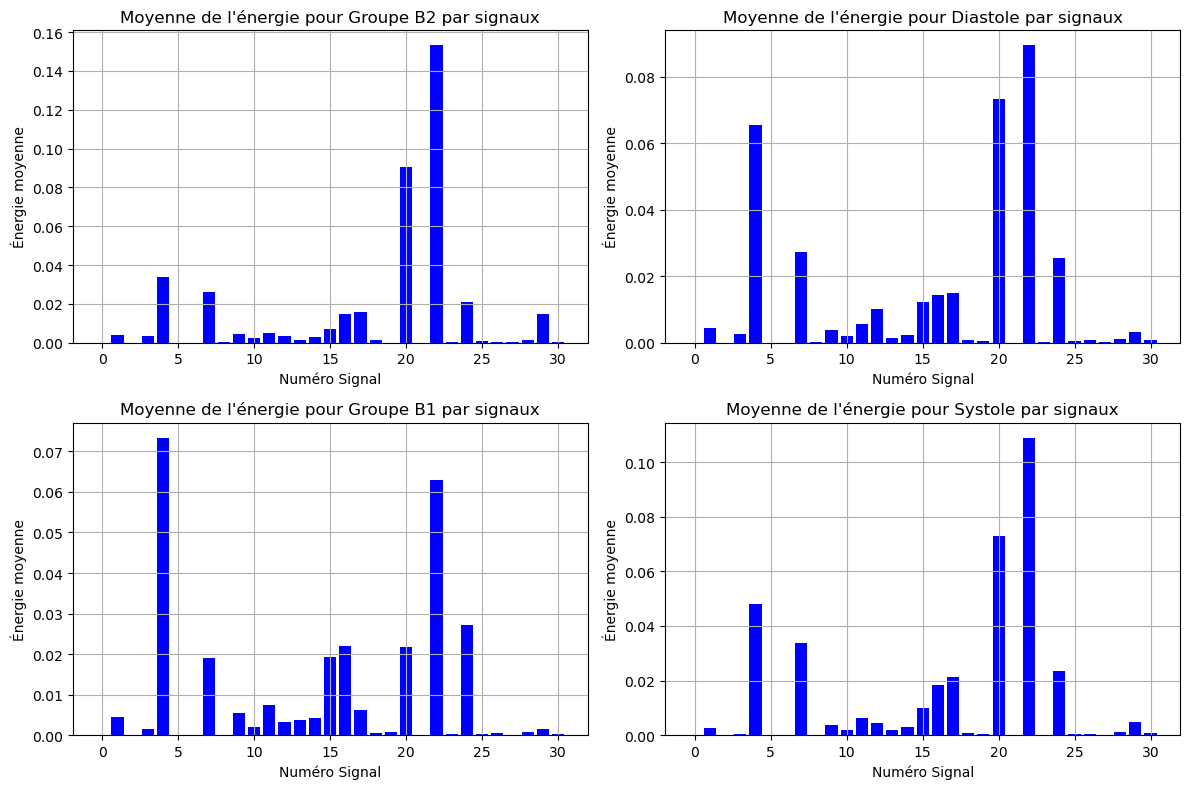

In [14]:
# Créer des graphiques pour afficher les moyennes de chaque segment pour chaque patient
segments = ['Groupe B2', 'Diastole', 'Groupe B1', 'Systole']
mean_values = [patients_B2, patients_diastole, patients_B1, patients_systole]

plt.figure(figsize=(12, 8))

for i in range(len(segments)):
    plt.subplot(2, 2, i+1)
    plt.bar(range(len(mean_values[i])), mean_values[i], color='b')
    plt.xlabel('Numéro Signal')
    plt.ylabel('Énergie moyenne')
    plt.title('Moyenne de l\'énergie pour {} par signaux'.format(segments[i]))
    plt.grid(True)

plt.tight_layout()
plt.show()
